In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 11:21 - loss: 2.3317 - STD: 0.0806 - MAE: 0.2196

  3/395 [..............................] - ETA: 10s - loss: 2.1801 - STD: 0.0600 - MAE: 0.2175  

  6/395 [..............................] - ETA: 9s - loss: 2.1285 - STD: 0.0551 - MAE: 0.2168 

  9/395 [..............................] - ETA: 9s - loss: 2.1158 - STD: 0.0517 - MAE: 0.2168

 12/395 [..............................] - ETA: 8s - loss: 2.1023 - STD: 0.0490 - MAE: 0.2167

 15/395 [>.............................] - ETA: 32s - loss: 2.0930 - STD: 0.0469 - MAE: 0.2165

 18/395 [>.............................] - ETA: 28s - loss: 2.0873 - STD: 0.0446 - MAE: 0.2166

 21/395 [>.............................] - ETA: 25s - loss: 2.0824 - STD: 0.0423 - MAE: 0.2167

 24/395 [>.............................] - ETA: 22s - loss: 2.0773 - STD: 0.0408 - MAE: 0.2166

 27/395 [=>............................] - ETA: 20s - loss: 2.0724 - STD: 0.0403 - MAE: 0.2165

 30/395 [=>............................] - ETA: 19s - loss: 2.0678 - STD: 0.0399 - MAE: 0.2164

 33/395 [=>............................] - ETA: 18s - loss: 2.0622 - STD: 0.0396 - MAE: 0.2163

 36/395 [=>............................] - ETA: 17s - loss: 2.0555 - STD: 0.0399 - MAE: 0.2160

 39/395 [=>............................] - ETA: 16s - loss: 2.0478 - STD: 0.0403 - MAE: 0.2158

 42/395 [==>...........................] - ETA: 15s - loss: 2.0393 - STD: 0.0412 - MAE: 0.2154

 45/395 [==>...........................] - ETA: 15s - loss: 2.0304 - STD: 0.0426 - MAE: 0.2150

 48/395 [==>...........................] - ETA: 14s - loss: 2.0210 - STD: 0.0442 - MAE: 0.2146

 51/395 [==>...........................] - ETA: 13s - loss: 2.0114 - STD: 0.0458 - MAE: 0.2141

 54/395 [===>..........................] - ETA: 13s - loss: 2.0021 - STD: 0.0474 - MAE: 0.2136

 57/395 [===>..........................] - ETA: 13s - loss: 1.9929 - STD: 0.0490 - MAE: 0.2132

 60/395 [===>..........................] - ETA: 12s - loss: 1.9839 - STD: 0.0506 - MAE: 0.2127

 63/395 [===>..........................] - ETA: 12s - loss: 1.9751 - STD: 0.0520 - MAE: 0.2122

 66/395 [====>.........................] - ETA: 11s - loss: 1.9658 - STD: 0.0535 - MAE: 0.2118

 69/395 [====>.........................] - ETA: 11s - loss: 1.9563 - STD: 0.0549 - MAE: 0.2113

 72/395 [====>.........................] - ETA: 11s - loss: 1.9464 - STD: 0.0562 - MAE: 0.2108

 75/395 [====>.........................] - ETA: 11s - loss: 1.9356 - STD: 0.0577 - MAE: 0.2102

 78/395 [====>.........................] - ETA: 10s - loss: 1.9240 - STD: 0.0592 - MAE: 0.2096

 81/395 [=====>........................] - ETA: 10s - loss: 1.9113 - STD: 0.0607 - MAE: 0.2090

 84/395 [=====>........................] - ETA: 10s - loss: 1.8978 - STD: 0.0625 - MAE: 0.2082

 87/395 [=====>........................] - ETA: 10s - loss: 1.8839 - STD: 0.0645 - MAE: 0.2074

 90/395 [=====>........................] - ETA: 9s - loss: 1.8702 - STD: 0.0665 - MAE: 0.2066 

 93/395 [======>.......................] - ETA: 9s - loss: 1.8565 - STD: 0.0686 - MAE: 0.2057

 96/395 [======>.......................] - ETA: 9s - loss: 1.8435 - STD: 0.0707 - MAE: 0.2049

 99/395 [======>.......................] - ETA: 9s - loss: 1.8307 - STD: 0.0727 - MAE: 0.2040

102/395 [======>.......................] - ETA: 9s - loss: 1.8178 - STD: 0.0747 - MAE: 0.2032

105/395 [======>.......................] - ETA: 9s - loss: 1.8054 - STD: 0.0766 - MAE: 0.2023

108/395 [=======>......................] - ETA: 8s - loss: 1.7936 - STD: 0.0785 - MAE: 0.2015

111/395 [=======>......................] - ETA: 8s - loss: 1.7823 - STD: 0.0804 - MAE: 0.2007

114/395 [=======>......................] - ETA: 8s - loss: 1.7713 - STD: 0.0822 - MAE: 0.1999

117/395 [=======>......................] - ETA: 8s - loss: 1.7606 - STD: 0.0839 - MAE: 0.1992

120/395 [========>.....................] - ETA: 8s - loss: 1.7502 - STD: 0.0856 - MAE: 0.1984

123/395 [========>.....................] - ETA: 8s - loss: 1.7402 - STD: 0.0872 - MAE: 0.1977

126/395 [========>.....................] - ETA: 8s - loss: 1.7305 - STD: 0.0889 - MAE: 0.1970

129/395 [========>.....................] - ETA: 7s - loss: 1.7213 - STD: 0.0904 - MAE: 0.1963

132/395 [=========>....................] - ETA: 7s - loss: 1.7123 - STD: 0.0920 - MAE: 0.1956

135/395 [=========>....................] - ETA: 7s - loss: 1.7036 - STD: 0.0934 - MAE: 0.1950

138/395 [=========>....................] - ETA: 7s - loss: 1.6952 - STD: 0.0948 - MAE: 0.1944

141/395 [=========>....................] - ETA: 7s - loss: 1.6872 - STD: 0.0962 - MAE: 0.1937

144/395 [=========>....................] - ETA: 7s - loss: 1.6792 - STD: 0.0975 - MAE: 0.1932

147/395 [==========>...................] - ETA: 7s - loss: 1.6716 - STD: 0.0988 - MAE: 0.1926

150/395 [==========>...................] - ETA: 7s - loss: 1.6643 - STD: 0.1000 - MAE: 0.1920

153/395 [==========>...................] - ETA: 6s - loss: 1.6572 - STD: 0.1012 - MAE: 0.1915

156/395 [==========>...................] - ETA: 6s - loss: 1.6503 - STD: 0.1024 - MAE: 0.1909

159/395 [===========>..................] - ETA: 6s - loss: 1.6436 - STD: 0.1036 - MAE: 0.1904

162/395 [===========>..................] - ETA: 6s - loss: 1.6369 - STD: 0.1047 - MAE: 0.1899

165/395 [===========>..................] - ETA: 6s - loss: 1.6304 - STD: 0.1058 - MAE: 0.1894

168/395 [===========>..................] - ETA: 6s - loss: 1.6241 - STD: 0.1068 - MAE: 0.1889

171/395 [===========>..................] - ETA: 6s - loss: 1.6178 - STD: 0.1079 - MAE: 0.1884

174/395 [============>.................] - ETA: 6s - loss: 1.6118 - STD: 0.1089 - MAE: 0.1879

177/395 [============>.................] - ETA: 6s - loss: 1.6059 - STD: 0.1099 - MAE: 0.1875

180/395 [============>.................] - ETA: 5s - loss: 1.6002 - STD: 0.1109 - MAE: 0.1870

183/395 [============>.................] - ETA: 5s - loss: 1.5946 - STD: 0.1118 - MAE: 0.1866

186/395 [=============>................] - ETA: 5s - loss: 1.5889 - STD: 0.1127 - MAE: 0.1861

189/395 [=============>................] - ETA: 5s - loss: 1.5836 - STD: 0.1136 - MAE: 0.1857

192/395 [=============>................] - ETA: 5s - loss: 1.5784 - STD: 0.1145 - MAE: 0.1853

195/395 [=============>................] - ETA: 5s - loss: 1.5733 - STD: 0.1154 - MAE: 0.1848

198/395 [==============>...............] - ETA: 5s - loss: 1.5682 - STD: 0.1163 - MAE: 0.1844

201/395 [==============>...............] - ETA: 5s - loss: 1.5633 - STD: 0.1171 - MAE: 0.1840

204/395 [==============>...............] - ETA: 5s - loss: 1.5584 - STD: 0.1179 - MAE: 0.1836

207/395 [==============>...............] - ETA: 5s - loss: 1.5537 - STD: 0.1187 - MAE: 0.1832

210/395 [==============>...............] - ETA: 4s - loss: 1.5490 - STD: 0.1195 - MAE: 0.1828

213/395 [===============>..............] - ETA: 4s - loss: 1.5444 - STD: 0.1203 - MAE: 0.1825

216/395 [===============>..............] - ETA: 4s - loss: 1.5400 - STD: 0.1210 - MAE: 0.1821

219/395 [===============>..............] - ETA: 4s - loss: 1.5356 - STD: 0.1218 - MAE: 0.1817

222/395 [===============>..............] - ETA: 4s - loss: 1.5313 - STD: 0.1225 - MAE: 0.1814

225/395 [================>.............] - ETA: 4s - loss: 1.5271 - STD: 0.1232 - MAE: 0.1810

228/395 [================>.............] - ETA: 4s - loss: 1.5228 - STD: 0.1239 - MAE: 0.1807

231/395 [================>.............] - ETA: 4s - loss: 1.5187 - STD: 0.1246 - MAE: 0.1803

234/395 [================>.............] - ETA: 4s - loss: 1.5146 - STD: 0.1253 - MAE: 0.1800

237/395 [=================>............] - ETA: 4s - loss: 1.5106 - STD: 0.1260 - MAE: 0.1796

240/395 [=================>............] - ETA: 4s - loss: 1.5066 - STD: 0.1267 - MAE: 0.1793

243/395 [=================>............] - ETA: 3s - loss: 1.5029 - STD: 0.1273 - MAE: 0.1790

246/395 [=================>............] - ETA: 3s - loss: 1.4993 - STD: 0.1279 - MAE: 0.1787

249/395 [=================>............] - ETA: 3s - loss: 1.4956 - STD: 0.1285 - MAE: 0.1784

252/395 [==================>...........] - ETA: 3s - loss: 1.4921 - STD: 0.1291 - MAE: 0.1780

255/395 [==================>...........] - ETA: 3s - loss: 1.4886 - STD: 0.1298 - MAE: 0.1777

258/395 [==================>...........] - ETA: 3s - loss: 1.4850 - STD: 0.1304 - MAE: 0.1774

261/395 [==================>...........] - ETA: 3s - loss: 1.4814 - STD: 0.1309 - MAE: 0.1771

263/395 [==================>...........] - ETA: 3s - loss: 1.4792 - STD: 0.1313 - MAE: 0.1769

266/395 [===================>..........] - ETA: 3s - loss: 1.4758 - STD: 0.1319 - MAE: 0.1767

269/395 [===================>..........] - ETA: 3s - loss: 1.4725 - STD: 0.1324 - MAE: 0.1764

272/395 [===================>..........] - ETA: 3s - loss: 1.4692 - STD: 0.1330 - MAE: 0.1761

275/395 [===================>..........] - ETA: 3s - loss: 1.4660 - STD: 0.1335 - MAE: 0.1758

278/395 [====================>.........] - ETA: 3s - loss: 1.4629 - STD: 0.1341 - MAE: 0.1755

281/395 [====================>.........] - ETA: 2s - loss: 1.4598 - STD: 0.1346 - MAE: 0.1753

284/395 [====================>.........] - ETA: 2s - loss: 1.4567 - STD: 0.1351 - MAE: 0.1750

287/395 [====================>.........] - ETA: 2s - loss: 1.4536 - STD: 0.1356 - MAE: 0.1747

290/395 [=====================>........] - ETA: 2s - loss: 1.4507 - STD: 0.1361 - MAE: 0.1745

293/395 [=====================>........] - ETA: 2s - loss: 1.4476 - STD: 0.1366 - MAE: 0.1742

296/395 [=====================>........] - ETA: 2s - loss: 1.4448 - STD: 0.1371 - MAE: 0.1740

299/395 [=====================>........] - ETA: 2s - loss: 1.4418 - STD: 0.1375 - MAE: 0.1737

302/395 [=====================>........] - ETA: 2s - loss: 1.4390 - STD: 0.1380 - MAE: 0.1735

305/395 [======================>.......] - ETA: 2s - loss: 1.4361 - STD: 0.1385 - MAE: 0.1732

308/395 [======================>.......] - ETA: 2s - loss: 1.4334 - STD: 0.1389 - MAE: 0.1730

311/395 [======================>.......] - ETA: 2s - loss: 1.4306 - STD: 0.1394 - MAE: 0.1727

314/395 [======================>.......] - ETA: 2s - loss: 1.4278 - STD: 0.1399 - MAE: 0.1725

317/395 [=======================>......] - ETA: 1s - loss: 1.4251 - STD: 0.1403 - MAE: 0.1722

320/395 [=======================>......] - ETA: 1s - loss: 1.4225 - STD: 0.1408 - MAE: 0.1720

323/395 [=======================>......] - ETA: 1s - loss: 1.4198 - STD: 0.1412 - MAE: 0.1718

326/395 [=======================>......] - ETA: 1s - loss: 1.4173 - STD: 0.1416 - MAE: 0.1716

329/395 [=======================>......] - ETA: 1s - loss: 1.4148 - STD: 0.1420 - MAE: 0.1713

332/395 [========================>.....] - ETA: 1s - loss: 1.4124 - STD: 0.1424 - MAE: 0.1711

335/395 [========================>.....] - ETA: 1s - loss: 1.4098 - STD: 0.1428 - MAE: 0.1709

338/395 [========================>.....] - ETA: 1s - loss: 1.4074 - STD: 0.1432 - MAE: 0.1707

341/395 [========================>.....] - ETA: 1s - loss: 1.4050 - STD: 0.1436 - MAE: 0.1705

344/395 [=========================>....] - ETA: 1s - loss: 1.4025 - STD: 0.1440 - MAE: 0.1702

347/395 [=========================>....] - ETA: 1s - loss: 1.4002 - STD: 0.1444 - MAE: 0.1700

350/395 [=========================>....] - ETA: 1s - loss: 1.3977 - STD: 0.1448 - MAE: 0.1698

353/395 [=========================>....] - ETA: 1s - loss: 1.3954 - STD: 0.1452 - MAE: 0.1696

356/395 [==========================>...] - ETA: 0s - loss: 1.3931 - STD: 0.1455 - MAE: 0.1694

359/395 [==========================>...] - ETA: 0s - loss: 1.3907 - STD: 0.1459 - MAE: 0.1692

362/395 [==========================>...] - ETA: 0s - loss: 1.3883 - STD: 0.1463 - MAE: 0.1690

365/395 [==========================>...] - ETA: 0s - loss: 1.3859 - STD: 0.1466 - MAE: 0.1688

368/395 [==========================>...] - ETA: 0s - loss: 1.3841 - STD: 0.1470 - MAE: 0.1686

371/395 [===========================>..] - ETA: 0s - loss: 1.3823 - STD: 0.1474 - MAE: 0.1684

374/395 [===========================>..] - ETA: 0s - loss: 1.3803 - STD: 0.1477 - MAE: 0.1682

377/395 [===========================>..] - ETA: 0s - loss: 1.3784 - STD: 0.1481 - MAE: 0.1680

380/395 [===========================>..] - ETA: 0s - loss: 1.3763 - STD: 0.1484 - MAE: 0.1679

383/395 [============================>.] - ETA: 0s - loss: 1.3743 - STD: 0.1487 - MAE: 0.1677

386/395 [============================>.] - ETA: 0s - loss: 1.3721 - STD: 0.1491 - MAE: 0.1675

389/395 [============================>.] - ETA: 0s - loss: 1.3700 - STD: 0.1494 - MAE: 0.1673

392/395 [============================>.] - ETA: 0s - loss: 1.3680 - STD: 0.1497 - MAE: 0.1671

395/395 [==============================] - ETA: 0s - loss: 1.3659 - STD: 0.1500 - MAE: 0.1669

395/395 [==============================] - 13s 28ms/step - loss: 1.3659 - STD: 0.1500 - MAE: 0.1669 - val_loss: 1.1705 - val_STD: 0.1921 - val_MAE: 0.1436


Epoch 2/10000


  1/395 [..............................] - ETA: 21s - loss: 1.0950 - STD: 0.1928 - MAE: 0.1420

  4/395 [..............................] - ETA: 8s - loss: 1.0921 - STD: 0.1923 - MAE: 0.1422 

  7/395 [..............................] - ETA: 8s - loss: 1.0916 - STD: 0.1924 - MAE: 0.1423

 10/395 [..............................] - ETA: 8s - loss: 1.0893 - STD: 0.1925 - MAE: 0.1421

 13/395 [..............................] - ETA: 8s - loss: 1.0889 - STD: 0.1926 - MAE: 0.1421

 16/395 [>.............................] - ETA: 8s - loss: 1.0885 - STD: 0.1927 - MAE: 0.1421

 19/395 [>.............................] - ETA: 8s - loss: 1.0884 - STD: 0.1931 - MAE: 0.1420

 22/395 [>.............................] - ETA: 8s - loss: 1.0874 - STD: 0.1932 - MAE: 0.1419

 25/395 [>.............................] - ETA: 8s - loss: 1.0868 - STD: 0.1933 - MAE: 0.1418

 28/395 [=>............................] - ETA: 8s - loss: 1.0870 - STD: 0.1935 - MAE: 0.1418

 31/395 [=>............................] - ETA: 8s - loss: 1.0863 - STD: 0.1937 - MAE: 0.1417

 34/395 [=>............................] - ETA: 8s - loss: 1.0852 - STD: 0.1938 - MAE: 0.1415

 37/395 [=>............................] - ETA: 8s - loss: 1.0842 - STD: 0.1939 - MAE: 0.1414

 40/395 [==>...........................] - ETA: 8s - loss: 1.0837 - STD: 0.1941 - MAE: 0.1413

 43/395 [==>...........................] - ETA: 7s - loss: 1.0834 - STD: 0.1942 - MAE: 0.1413

 46/395 [==>...........................] - ETA: 7s - loss: 1.0820 - STD: 0.1943 - MAE: 0.1412

 49/395 [==>...........................] - ETA: 7s - loss: 1.0814 - STD: 0.1944 - MAE: 0.1411

 52/395 [==>...........................] - ETA: 7s - loss: 1.0813 - STD: 0.1946 - MAE: 0.1410

 55/395 [===>..........................] - ETA: 7s - loss: 1.0814 - STD: 0.1947 - MAE: 0.1409

 58/395 [===>..........................] - ETA: 7s - loss: 1.0816 - STD: 0.1948 - MAE: 0.1409

 61/395 [===>..........................] - ETA: 7s - loss: 1.0807 - STD: 0.1949 - MAE: 0.1409

 64/395 [===>..........................] - ETA: 7s - loss: 1.0798 - STD: 0.1950 - MAE: 0.1408

 67/395 [====>.........................] - ETA: 7s - loss: 1.0793 - STD: 0.1951 - MAE: 0.1407

 70/395 [====>.........................] - ETA: 7s - loss: 1.0794 - STD: 0.1952 - MAE: 0.1407

 73/395 [====>.........................] - ETA: 7s - loss: 1.0790 - STD: 0.1953 - MAE: 0.1406

 76/395 [====>.........................] - ETA: 7s - loss: 1.0792 - STD: 0.1953 - MAE: 0.1406

 79/395 [=====>........................] - ETA: 7s - loss: 1.0793 - STD: 0.1954 - MAE: 0.1406

 82/395 [=====>........................] - ETA: 7s - loss: 1.0789 - STD: 0.1955 - MAE: 0.1405

 85/395 [=====>........................] - ETA: 7s - loss: 1.0783 - STD: 0.1956 - MAE: 0.1405

 88/395 [=====>........................] - ETA: 6s - loss: 1.0776 - STD: 0.1957 - MAE: 0.1404

 91/395 [=====>........................] - ETA: 6s - loss: 1.0772 - STD: 0.1957 - MAE: 0.1404

 94/395 [======>.......................] - ETA: 6s - loss: 1.0765 - STD: 0.1958 - MAE: 0.1403

 97/395 [======>.......................] - ETA: 6s - loss: 1.0757 - STD: 0.1959 - MAE: 0.1402

100/395 [======>.......................] - ETA: 6s - loss: 1.0750 - STD: 0.1960 - MAE: 0.1401

103/395 [======>.......................] - ETA: 6s - loss: 1.0742 - STD: 0.1961 - MAE: 0.1401

106/395 [=======>......................] - ETA: 6s - loss: 1.0734 - STD: 0.1962 - MAE: 0.1400

109/395 [=======>......................] - ETA: 6s - loss: 1.0728 - STD: 0.1963 - MAE: 0.1399

112/395 [=======>......................] - ETA: 6s - loss: 1.0721 - STD: 0.1964 - MAE: 0.1398

115/395 [=======>......................] - ETA: 6s - loss: 1.0716 - STD: 0.1964 - MAE: 0.1398

118/395 [=======>......................] - ETA: 6s - loss: 1.0711 - STD: 0.1965 - MAE: 0.1397

121/395 [========>.....................] - ETA: 6s - loss: 1.0707 - STD: 0.1966 - MAE: 0.1397

124/395 [========>.....................] - ETA: 6s - loss: 1.0702 - STD: 0.1967 - MAE: 0.1396

127/395 [========>.....................] - ETA: 6s - loss: 1.0698 - STD: 0.1968 - MAE: 0.1395

130/395 [========>.....................] - ETA: 5s - loss: 1.0693 - STD: 0.1969 - MAE: 0.1395

133/395 [=========>....................] - ETA: 5s - loss: 1.0687 - STD: 0.1970 - MAE: 0.1394

136/395 [=========>....................] - ETA: 5s - loss: 1.0680 - STD: 0.1971 - MAE: 0.1393

139/395 [=========>....................] - ETA: 5s - loss: 1.0674 - STD: 0.1972 - MAE: 0.1393

142/395 [=========>....................] - ETA: 5s - loss: 1.0668 - STD: 0.1973 - MAE: 0.1392

145/395 [==========>...................] - ETA: 5s - loss: 1.0661 - STD: 0.1973 - MAE: 0.1391

148/395 [==========>...................] - ETA: 5s - loss: 1.0654 - STD: 0.1974 - MAE: 0.1391

151/395 [==========>...................] - ETA: 5s - loss: 1.0647 - STD: 0.1975 - MAE: 0.1390

154/395 [==========>...................] - ETA: 5s - loss: 1.0644 - STD: 0.1976 - MAE: 0.1389

157/395 [==========>...................] - ETA: 5s - loss: 1.0640 - STD: 0.1977 - MAE: 0.1389

160/395 [===========>..................] - ETA: 5s - loss: 1.0639 - STD: 0.1978 - MAE: 0.1388

163/395 [===========>..................] - ETA: 5s - loss: 1.0640 - STD: 0.1978 - MAE: 0.1388

166/395 [===========>..................] - ETA: 5s - loss: 1.0635 - STD: 0.1979 - MAE: 0.1387

169/395 [===========>..................] - ETA: 5s - loss: 1.0632 - STD: 0.1980 - MAE: 0.1387

172/395 [============>.................] - ETA: 5s - loss: 1.0630 - STD: 0.1981 - MAE: 0.1387

175/395 [============>.................] - ETA: 4s - loss: 1.0628 - STD: 0.1981 - MAE: 0.1386

178/395 [============>.................] - ETA: 4s - loss: 1.0622 - STD: 0.1982 - MAE: 0.1386

181/395 [============>.................] - ETA: 4s - loss: 1.0615 - STD: 0.1983 - MAE: 0.1385

184/395 [============>.................] - ETA: 4s - loss: 1.0610 - STD: 0.1983 - MAE: 0.1384

187/395 [=============>................] - ETA: 4s - loss: 1.0604 - STD: 0.1984 - MAE: 0.1384

190/395 [=============>................] - ETA: 4s - loss: 1.0596 - STD: 0.1985 - MAE: 0.1383

193/395 [=============>................] - ETA: 4s - loss: 1.0590 - STD: 0.1986 - MAE: 0.1382

196/395 [=============>................] - ETA: 4s - loss: 1.0585 - STD: 0.1987 - MAE: 0.1382

199/395 [==============>...............] - ETA: 4s - loss: 1.0579 - STD: 0.1987 - MAE: 0.1381

202/395 [==============>...............] - ETA: 4s - loss: 1.0574 - STD: 0.1988 - MAE: 0.1381

205/395 [==============>...............] - ETA: 4s - loss: 1.0569 - STD: 0.1989 - MAE: 0.1380

208/395 [==============>...............] - ETA: 4s - loss: 1.0561 - STD: 0.1990 - MAE: 0.1379

211/395 [===============>..............] - ETA: 4s - loss: 1.0556 - STD: 0.1990 - MAE: 0.1379

214/395 [===============>..............] - ETA: 4s - loss: 1.0549 - STD: 0.1991 - MAE: 0.1378

217/395 [===============>..............] - ETA: 4s - loss: 1.0544 - STD: 0.1992 - MAE: 0.1377

220/395 [===============>..............] - ETA: 3s - loss: 1.0540 - STD: 0.1993 - MAE: 0.1377

223/395 [===============>..............] - ETA: 3s - loss: 1.0535 - STD: 0.1993 - MAE: 0.1376

225/395 [================>.............] - ETA: 3s - loss: 1.0530 - STD: 0.1994 - MAE: 0.1376

228/395 [================>.............] - ETA: 3s - loss: 1.0526 - STD: 0.1995 - MAE: 0.1375

231/395 [================>.............] - ETA: 3s - loss: 1.0521 - STD: 0.1996 - MAE: 0.1375

234/395 [================>.............] - ETA: 3s - loss: 1.0516 - STD: 0.1996 - MAE: 0.1374

237/395 [=================>............] - ETA: 3s - loss: 1.0511 - STD: 0.1997 - MAE: 0.1373

240/395 [=================>............] - ETA: 3s - loss: 1.0507 - STD: 0.1998 - MAE: 0.1373

243/395 [=================>............] - ETA: 3s - loss: 1.0503 - STD: 0.1998 - MAE: 0.1372

246/395 [=================>............] - ETA: 3s - loss: 1.0500 - STD: 0.1999 - MAE: 0.1372

249/395 [=================>............] - ETA: 3s - loss: 1.0497 - STD: 0.2000 - MAE: 0.1371

252/395 [==================>...........] - ETA: 3s - loss: 1.0492 - STD: 0.2001 - MAE: 0.1371

255/395 [==================>...........] - ETA: 3s - loss: 1.0488 - STD: 0.2001 - MAE: 0.1370

258/395 [==================>...........] - ETA: 3s - loss: 1.0482 - STD: 0.2002 - MAE: 0.1370

261/395 [==================>...........] - ETA: 3s - loss: 1.0479 - STD: 0.2003 - MAE: 0.1369

264/395 [===================>..........] - ETA: 2s - loss: 1.0476 - STD: 0.2003 - MAE: 0.1369

267/395 [===================>..........] - ETA: 2s - loss: 1.0471 - STD: 0.2004 - MAE: 0.1368

270/395 [===================>..........] - ETA: 2s - loss: 1.0469 - STD: 0.2004 - MAE: 0.1368

273/395 [===================>..........] - ETA: 2s - loss: 1.0464 - STD: 0.2005 - MAE: 0.1368

276/395 [===================>..........] - ETA: 2s - loss: 1.0460 - STD: 0.2006 - MAE: 0.1367

279/395 [====================>.........] - ETA: 2s - loss: 1.0456 - STD: 0.2006 - MAE: 0.1367

282/395 [====================>.........] - ETA: 2s - loss: 1.0450 - STD: 0.2007 - MAE: 0.1366

285/395 [====================>.........] - ETA: 2s - loss: 1.0446 - STD: 0.2008 - MAE: 0.1366

288/395 [====================>.........] - ETA: 2s - loss: 1.0442 - STD: 0.2008 - MAE: 0.1365

291/395 [=====================>........] - ETA: 2s - loss: 1.0437 - STD: 0.2009 - MAE: 0.1365

294/395 [=====================>........] - ETA: 2s - loss: 1.0433 - STD: 0.2009 - MAE: 0.1364

297/395 [=====================>........] - ETA: 2s - loss: 1.0429 - STD: 0.2010 - MAE: 0.1364

300/395 [=====================>........] - ETA: 2s - loss: 1.0425 - STD: 0.2011 - MAE: 0.1363

303/395 [======================>.......] - ETA: 2s - loss: 1.0423 - STD: 0.2012 - MAE: 0.1363

306/395 [======================>.......] - ETA: 2s - loss: 1.0420 - STD: 0.2012 - MAE: 0.1362

309/395 [======================>.......] - ETA: 1s - loss: 1.0414 - STD: 0.2013 - MAE: 0.1362

312/395 [======================>.......] - ETA: 1s - loss: 1.0410 - STD: 0.2013 - MAE: 0.1361

315/395 [======================>.......] - ETA: 1s - loss: 1.0406 - STD: 0.2014 - MAE: 0.1361

318/395 [=======================>......] - ETA: 1s - loss: 1.0402 - STD: 0.2015 - MAE: 0.1360

321/395 [=======================>......] - ETA: 1s - loss: 1.0398 - STD: 0.2015 - MAE: 0.1360

324/395 [=======================>......] - ETA: 1s - loss: 1.0395 - STD: 0.2016 - MAE: 0.1359

326/395 [=======================>......] - ETA: 1s - loss: 1.0394 - STD: 0.2016 - MAE: 0.1359

329/395 [=======================>......] - ETA: 1s - loss: 1.0391 - STD: 0.2017 - MAE: 0.1359

332/395 [========================>.....] - ETA: 1s - loss: 1.0387 - STD: 0.2017 - MAE: 0.1358

335/395 [========================>.....] - ETA: 1s - loss: 1.0383 - STD: 0.2018 - MAE: 0.1358

338/395 [========================>.....] - ETA: 1s - loss: 1.0380 - STD: 0.2018 - MAE: 0.1357

341/395 [========================>.....] - ETA: 1s - loss: 1.0375 - STD: 0.2019 - MAE: 0.1357

344/395 [=========================>....] - ETA: 1s - loss: 1.0371 - STD: 0.2019 - MAE: 0.1357

347/395 [=========================>....] - ETA: 1s - loss: 1.0367 - STD: 0.2020 - MAE: 0.1356

350/395 [=========================>....] - ETA: 1s - loss: 1.0364 - STD: 0.2020 - MAE: 0.1356

353/395 [=========================>....] - ETA: 0s - loss: 1.0359 - STD: 0.2021 - MAE: 0.1355

356/395 [==========================>...] - ETA: 0s - loss: 1.0355 - STD: 0.2021 - MAE: 0.1355

359/395 [==========================>...] - ETA: 0s - loss: 1.0351 - STD: 0.2022 - MAE: 0.1354

362/395 [==========================>...] - ETA: 0s - loss: 1.0346 - STD: 0.2023 - MAE: 0.1354

365/395 [==========================>...] - ETA: 0s - loss: 1.0343 - STD: 0.2023 - MAE: 0.1353

368/395 [==========================>...] - ETA: 0s - loss: 1.0338 - STD: 0.2024 - MAE: 0.1353

371/395 [===========================>..] - ETA: 0s - loss: 1.0334 - STD: 0.2024 - MAE: 0.1352

374/395 [===========================>..] - ETA: 0s - loss: 1.0329 - STD: 0.2025 - MAE: 0.1352

377/395 [===========================>..] - ETA: 0s - loss: 1.0325 - STD: 0.2026 - MAE: 0.1351

380/395 [===========================>..] - ETA: 0s - loss: 1.0322 - STD: 0.2026 - MAE: 0.1351

383/395 [============================>.] - ETA: 0s - loss: 1.0317 - STD: 0.2027 - MAE: 0.1350

386/395 [============================>.] - ETA: 0s - loss: 1.0313 - STD: 0.2027 - MAE: 0.1350

389/395 [============================>.] - ETA: 0s - loss: 1.0308 - STD: 0.2028 - MAE: 0.1349

392/395 [============================>.] - ETA: 0s - loss: 1.0303 - STD: 0.2029 - MAE: 0.1349

395/395 [==============================] - ETA: 0s - loss: 1.0298 - STD: 0.2029 - MAE: 0.1348

395/395 [==============================] - 10s 25ms/step - loss: 1.0298 - STD: 0.2029 - MAE: 0.1348 - val_loss: 1.0953 - val_STD: 0.2103 - val_MAE: 0.1315


Epoch 3/10000


  1/395 [..............................] - ETA: 17s - loss: 0.9777 - STD: 0.2103 - MAE: 0.1289

  4/395 [..............................] - ETA: 8s - loss: 0.9735 - STD: 0.2105 - MAE: 0.1286 

  7/395 [..............................] - ETA: 8s - loss: 0.9737 - STD: 0.2107 - MAE: 0.1285

 10/395 [..............................] - ETA: 8s - loss: 0.9742 - STD: 0.2109 - MAE: 0.1283

 13/395 [..............................] - ETA: 8s - loss: 0.9737 - STD: 0.2111 - MAE: 0.1282

 16/395 [>.............................] - ETA: 8s - loss: 0.9768 - STD: 0.2111 - MAE: 0.1284

 19/395 [>.............................] - ETA: 8s - loss: 0.9790 - STD: 0.2113 - MAE: 0.1284

 22/395 [>.............................] - ETA: 8s - loss: 0.9784 - STD: 0.2113 - MAE: 0.1284

 25/395 [>.............................] - ETA: 8s - loss: 0.9775 - STD: 0.2113 - MAE: 0.1284

 28/395 [=>............................] - ETA: 8s - loss: 0.9765 - STD: 0.2112 - MAE: 0.1284

 31/395 [=>............................] - ETA: 8s - loss: 0.9759 - STD: 0.2113 - MAE: 0.1283

 34/395 [=>............................] - ETA: 8s - loss: 0.9754 - STD: 0.2113 - MAE: 0.1282

 37/395 [=>............................] - ETA: 8s - loss: 0.9755 - STD: 0.2114 - MAE: 0.1282

 40/395 [==>...........................] - ETA: 8s - loss: 0.9747 - STD: 0.2115 - MAE: 0.1281

 43/395 [==>...........................] - ETA: 8s - loss: 0.9742 - STD: 0.2115 - MAE: 0.1281

 46/395 [==>...........................] - ETA: 7s - loss: 0.9733 - STD: 0.2115 - MAE: 0.1280

 49/395 [==>...........................] - ETA: 7s - loss: 0.9727 - STD: 0.2116 - MAE: 0.1280

 52/395 [==>...........................] - ETA: 7s - loss: 0.9722 - STD: 0.2116 - MAE: 0.1279

 55/395 [===>..........................] - ETA: 7s - loss: 0.9719 - STD: 0.2116 - MAE: 0.1279

 58/395 [===>..........................] - ETA: 7s - loss: 0.9717 - STD: 0.2117 - MAE: 0.1279

 61/395 [===>..........................] - ETA: 7s - loss: 0.9720 - STD: 0.2117 - MAE: 0.1279

 64/395 [===>..........................] - ETA: 7s - loss: 0.9716 - STD: 0.2117 - MAE: 0.1279

 67/395 [====>.........................] - ETA: 7s - loss: 0.9712 - STD: 0.2117 - MAE: 0.1278

 70/395 [====>.........................] - ETA: 7s - loss: 0.9721 - STD: 0.2118 - MAE: 0.1279

 73/395 [====>.........................] - ETA: 7s - loss: 0.9727 - STD: 0.2118 - MAE: 0.1279

 76/395 [====>.........................] - ETA: 7s - loss: 0.9727 - STD: 0.2118 - MAE: 0.1279

 79/395 [=====>........................] - ETA: 7s - loss: 0.9736 - STD: 0.2119 - MAE: 0.1279

 82/395 [=====>........................] - ETA: 7s - loss: 0.9745 - STD: 0.2119 - MAE: 0.1280

 85/395 [=====>........................] - ETA: 7s - loss: 0.9749 - STD: 0.2119 - MAE: 0.1280

 88/395 [=====>........................] - ETA: 6s - loss: 0.9746 - STD: 0.2119 - MAE: 0.1280

 91/395 [=====>........................] - ETA: 6s - loss: 0.9747 - STD: 0.2119 - MAE: 0.1280

 94/395 [======>.......................] - ETA: 6s - loss: 0.9742 - STD: 0.2118 - MAE: 0.1280

 97/395 [======>.......................] - ETA: 6s - loss: 0.9735 - STD: 0.2118 - MAE: 0.1279

100/395 [======>.......................] - ETA: 6s - loss: 0.9729 - STD: 0.2119 - MAE: 0.1279

103/395 [======>.......................] - ETA: 6s - loss: 0.9726 - STD: 0.2119 - MAE: 0.1278

106/395 [=======>......................] - ETA: 6s - loss: 0.9722 - STD: 0.2119 - MAE: 0.1278

109/395 [=======>......................] - ETA: 6s - loss: 0.9727 - STD: 0.2120 - MAE: 0.1278

112/395 [=======>......................] - ETA: 6s - loss: 0.9725 - STD: 0.2120 - MAE: 0.1278

115/395 [=======>......................] - ETA: 6s - loss: 0.9722 - STD: 0.2120 - MAE: 0.1278

118/395 [=======>......................] - ETA: 6s - loss: 0.9718 - STD: 0.2121 - MAE: 0.1277

121/395 [========>.....................] - ETA: 6s - loss: 0.9715 - STD: 0.2121 - MAE: 0.1277

124/395 [========>.....................] - ETA: 6s - loss: 0.9711 - STD: 0.2121 - MAE: 0.1277

127/395 [========>.....................] - ETA: 6s - loss: 0.9707 - STD: 0.2122 - MAE: 0.1276

130/395 [========>.....................] - ETA: 6s - loss: 0.9703 - STD: 0.2122 - MAE: 0.1276

133/395 [=========>....................] - ETA: 5s - loss: 0.9700 - STD: 0.2122 - MAE: 0.1276

136/395 [=========>....................] - ETA: 5s - loss: 0.9696 - STD: 0.2123 - MAE: 0.1275

139/395 [=========>....................] - ETA: 5s - loss: 0.9690 - STD: 0.2123 - MAE: 0.1275

142/395 [=========>....................] - ETA: 5s - loss: 0.9686 - STD: 0.2123 - MAE: 0.1275

145/395 [==========>...................] - ETA: 5s - loss: 0.9679 - STD: 0.2123 - MAE: 0.1274

148/395 [==========>...................] - ETA: 5s - loss: 0.9676 - STD: 0.2124 - MAE: 0.1274

151/395 [==========>...................] - ETA: 5s - loss: 0.9675 - STD: 0.2124 - MAE: 0.1273

154/395 [==========>...................] - ETA: 5s - loss: 0.9673 - STD: 0.2125 - MAE: 0.1273

157/395 [==========>...................] - ETA: 5s - loss: 0.9671 - STD: 0.2125 - MAE: 0.1273

159/395 [===========>..................] - ETA: 5s - loss: 0.9670 - STD: 0.2125 - MAE: 0.1273

162/395 [===========>..................] - ETA: 5s - loss: 0.9666 - STD: 0.2126 - MAE: 0.1272

165/395 [===========>..................] - ETA: 5s - loss: 0.9664 - STD: 0.2126 - MAE: 0.1272

167/395 [===========>..................] - ETA: 5s - loss: 0.9660 - STD: 0.2127 - MAE: 0.1271

170/395 [===========>..................] - ETA: 5s - loss: 0.9659 - STD: 0.2127 - MAE: 0.1271

173/395 [============>.................] - ETA: 5s - loss: 0.9657 - STD: 0.2127 - MAE: 0.1271

176/395 [============>.................] - ETA: 5s - loss: 0.9656 - STD: 0.2128 - MAE: 0.1271

179/395 [============>.................] - ETA: 4s - loss: 0.9655 - STD: 0.2128 - MAE: 0.1271

182/395 [============>.................] - ETA: 4s - loss: 0.9650 - STD: 0.2128 - MAE: 0.1270

185/395 [=============>................] - ETA: 4s - loss: 0.9647 - STD: 0.2128 - MAE: 0.1270

188/395 [=============>................] - ETA: 4s - loss: 0.9643 - STD: 0.2129 - MAE: 0.1270

191/395 [=============>................] - ETA: 4s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1269

194/395 [=============>................] - ETA: 4s - loss: 0.9635 - STD: 0.2129 - MAE: 0.1269

197/395 [=============>................] - ETA: 4s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1269

200/395 [==============>...............] - ETA: 4s - loss: 0.9629 - STD: 0.2130 - MAE: 0.1268

203/395 [==============>...............] - ETA: 4s - loss: 0.9624 - STD: 0.2130 - MAE: 0.1268

206/395 [==============>...............] - ETA: 4s - loss: 0.9621 - STD: 0.2131 - MAE: 0.1268

209/395 [==============>...............] - ETA: 4s - loss: 0.9617 - STD: 0.2131 - MAE: 0.1267

212/395 [===============>..............] - ETA: 4s - loss: 0.9614 - STD: 0.2131 - MAE: 0.1267

215/395 [===============>..............] - ETA: 4s - loss: 0.9611 - STD: 0.2132 - MAE: 0.1266

218/395 [===============>..............] - ETA: 4s - loss: 0.9612 - STD: 0.2132 - MAE: 0.1266

221/395 [===============>..............] - ETA: 4s - loss: 0.9608 - STD: 0.2133 - MAE: 0.1266

224/395 [================>.............] - ETA: 3s - loss: 0.9605 - STD: 0.2133 - MAE: 0.1266

227/395 [================>.............] - ETA: 3s - loss: 0.9602 - STD: 0.2133 - MAE: 0.1265

230/395 [================>.............] - ETA: 3s - loss: 0.9602 - STD: 0.2134 - MAE: 0.1265

233/395 [================>.............] - ETA: 3s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1265

236/395 [================>.............] - ETA: 3s - loss: 0.9597 - STD: 0.2134 - MAE: 0.1265

239/395 [=================>............] - ETA: 3s - loss: 0.9595 - STD: 0.2135 - MAE: 0.1264

242/395 [=================>............] - ETA: 3s - loss: 0.9593 - STD: 0.2135 - MAE: 0.1264

245/395 [=================>............] - ETA: 3s - loss: 0.9591 - STD: 0.2135 - MAE: 0.1264

248/395 [=================>............] - ETA: 3s - loss: 0.9587 - STD: 0.2136 - MAE: 0.1263

251/395 [==================>...........] - ETA: 3s - loss: 0.9583 - STD: 0.2136 - MAE: 0.1263

254/395 [==================>...........] - ETA: 3s - loss: 0.9580 - STD: 0.2136 - MAE: 0.1263

257/395 [==================>...........] - ETA: 3s - loss: 0.9576 - STD: 0.2136 - MAE: 0.1262

260/395 [==================>...........] - ETA: 3s - loss: 0.9574 - STD: 0.2137 - MAE: 0.1262

263/395 [==================>...........] - ETA: 3s - loss: 0.9570 - STD: 0.2137 - MAE: 0.1262

266/395 [===================>..........] - ETA: 2s - loss: 0.9568 - STD: 0.2137 - MAE: 0.1262

269/395 [===================>..........] - ETA: 2s - loss: 0.9567 - STD: 0.2138 - MAE: 0.1261

272/395 [===================>..........] - ETA: 2s - loss: 0.9565 - STD: 0.2138 - MAE: 0.1261

275/395 [===================>..........] - ETA: 2s - loss: 0.9564 - STD: 0.2138 - MAE: 0.1261

278/395 [====================>.........] - ETA: 2s - loss: 0.9562 - STD: 0.2139 - MAE: 0.1260

281/395 [====================>.........] - ETA: 2s - loss: 0.9560 - STD: 0.2139 - MAE: 0.1260

284/395 [====================>.........] - ETA: 2s - loss: 0.9557 - STD: 0.2139 - MAE: 0.1260

287/395 [====================>.........] - ETA: 2s - loss: 0.9554 - STD: 0.2140 - MAE: 0.1260

290/395 [=====================>........] - ETA: 2s - loss: 0.9551 - STD: 0.2140 - MAE: 0.1259

293/395 [=====================>........] - ETA: 2s - loss: 0.9549 - STD: 0.2140 - MAE: 0.1259

296/395 [=====================>........] - ETA: 2s - loss: 0.9546 - STD: 0.2141 - MAE: 0.1259

299/395 [=====================>........] - ETA: 2s - loss: 0.9543 - STD: 0.2141 - MAE: 0.1259

302/395 [=====================>........] - ETA: 2s - loss: 0.9541 - STD: 0.2141 - MAE: 0.1258

305/395 [======================>.......] - ETA: 2s - loss: 0.9537 - STD: 0.2142 - MAE: 0.1258

308/395 [======================>.......] - ETA: 2s - loss: 0.9538 - STD: 0.2142 - MAE: 0.1258

311/395 [======================>.......] - ETA: 1s - loss: 0.9536 - STD: 0.2142 - MAE: 0.1258

314/395 [======================>.......] - ETA: 1s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1257

317/395 [=======================>......] - ETA: 1s - loss: 0.9536 - STD: 0.2143 - MAE: 0.1257

320/395 [=======================>......] - ETA: 1s - loss: 0.9536 - STD: 0.2144 - MAE: 0.1257

323/395 [=======================>......] - ETA: 1s - loss: 0.9536 - STD: 0.2144 - MAE: 0.1257

326/395 [=======================>......] - ETA: 1s - loss: 0.9534 - STD: 0.2144 - MAE: 0.1257

329/395 [=======================>......] - ETA: 1s - loss: 0.9532 - STD: 0.2144 - MAE: 0.1256

332/395 [========================>.....] - ETA: 1s - loss: 0.9529 - STD: 0.2144 - MAE: 0.1256

335/395 [========================>.....] - ETA: 1s - loss: 0.9526 - STD: 0.2145 - MAE: 0.1256

338/395 [========================>.....] - ETA: 1s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1256

341/395 [========================>.....] - ETA: 1s - loss: 0.9523 - STD: 0.2145 - MAE: 0.1256

344/395 [=========================>....] - ETA: 1s - loss: 0.9521 - STD: 0.2145 - MAE: 0.1255

347/395 [=========================>....] - ETA: 1s - loss: 0.9519 - STD: 0.2146 - MAE: 0.1255

350/395 [=========================>....] - ETA: 1s - loss: 0.9517 - STD: 0.2146 - MAE: 0.1255

353/395 [=========================>....] - ETA: 0s - loss: 0.9515 - STD: 0.2146 - MAE: 0.1255

356/395 [==========================>...] - ETA: 0s - loss: 0.9512 - STD: 0.2147 - MAE: 0.1254

359/395 [==========================>...] - ETA: 0s - loss: 0.9509 - STD: 0.2147 - MAE: 0.1254

362/395 [==========================>...] - ETA: 0s - loss: 0.9507 - STD: 0.2147 - MAE: 0.1254

365/395 [==========================>...] - ETA: 0s - loss: 0.9505 - STD: 0.2148 - MAE: 0.1253

368/395 [==========================>...] - ETA: 0s - loss: 0.9504 - STD: 0.2148 - MAE: 0.1253

371/395 [===========================>..] - ETA: 0s - loss: 0.9501 - STD: 0.2148 - MAE: 0.1253

374/395 [===========================>..] - ETA: 0s - loss: 0.9499 - STD: 0.2149 - MAE: 0.1253

377/395 [===========================>..] - ETA: 0s - loss: 0.9497 - STD: 0.2149 - MAE: 0.1252

380/395 [===========================>..] - ETA: 0s - loss: 0.9494 - STD: 0.2149 - MAE: 0.1252

383/395 [============================>.] - ETA: 0s - loss: 0.9492 - STD: 0.2149 - MAE: 0.1252

386/395 [============================>.] - ETA: 0s - loss: 0.9489 - STD: 0.2150 - MAE: 0.1252

389/395 [============================>.] - ETA: 0s - loss: 0.9486 - STD: 0.2150 - MAE: 0.1251

392/395 [============================>.] - ETA: 0s - loss: 0.9485 - STD: 0.2150 - MAE: 0.1251

395/395 [==============================] - ETA: 0s - loss: 0.9484 - STD: 0.2150 - MAE: 0.1251

395/395 [==============================] - 10s 25ms/step - loss: 0.9484 - STD: 0.2150 - MAE: 0.1251 - val_loss: 1.0736 - val_STD: 0.2195 - val_MAE: 0.1275


Epoch 4/10000


  1/395 [..............................] - ETA: 21s - loss: 0.9538 - STD: 0.2191 - MAE: 0.1240

  4/395 [..............................] - ETA: 9s - loss: 0.9356 - STD: 0.2189 - MAE: 0.1228 

  7/395 [..............................] - ETA: 9s - loss: 0.9349 - STD: 0.2189 - MAE: 0.1227

 10/395 [..............................] - ETA: 9s - loss: 0.9381 - STD: 0.2186 - MAE: 0.1230

 13/395 [..............................] - ETA: 9s - loss: 0.9386 - STD: 0.2187 - MAE: 0.1230

 16/395 [>.............................] - ETA: 8s - loss: 0.9356 - STD: 0.2186 - MAE: 0.1229

 19/395 [>.............................] - ETA: 8s - loss: 0.9339 - STD: 0.2187 - MAE: 0.1227

 22/395 [>.............................] - ETA: 8s - loss: 0.9320 - STD: 0.2186 - MAE: 0.1226

 25/395 [>.............................] - ETA: 8s - loss: 0.9298 - STD: 0.2186 - MAE: 0.1225

 28/395 [=>............................] - ETA: 8s - loss: 0.9277 - STD: 0.2187 - MAE: 0.1224

 31/395 [=>............................] - ETA: 8s - loss: 0.9261 - STD: 0.2187 - MAE: 0.1222

 34/395 [=>............................] - ETA: 8s - loss: 0.9241 - STD: 0.2188 - MAE: 0.1221

 37/395 [=>............................] - ETA: 8s - loss: 0.9230 - STD: 0.2188 - MAE: 0.1220

 40/395 [==>...........................] - ETA: 8s - loss: 0.9216 - STD: 0.2189 - MAE: 0.1219

 43/395 [==>...........................] - ETA: 8s - loss: 0.9213 - STD: 0.2188 - MAE: 0.1219

 46/395 [==>...........................] - ETA: 8s - loss: 0.9204 - STD: 0.2189 - MAE: 0.1218

 49/395 [==>...........................] - ETA: 8s - loss: 0.9195 - STD: 0.2189 - MAE: 0.1217

 52/395 [==>...........................] - ETA: 8s - loss: 0.9190 - STD: 0.2189 - MAE: 0.1217

 55/395 [===>..........................] - ETA: 7s - loss: 0.9208 - STD: 0.2190 - MAE: 0.1218

 58/395 [===>..........................] - ETA: 7s - loss: 0.9209 - STD: 0.2191 - MAE: 0.1217

 61/395 [===>..........................] - ETA: 7s - loss: 0.9212 - STD: 0.2192 - MAE: 0.1217

 64/395 [===>..........................] - ETA: 7s - loss: 0.9216 - STD: 0.2192 - MAE: 0.1217

 67/395 [====>.........................] - ETA: 7s - loss: 0.9213 - STD: 0.2192 - MAE: 0.1217

 70/395 [====>.........................] - ETA: 7s - loss: 0.9208 - STD: 0.2191 - MAE: 0.1217

 73/395 [====>.........................] - ETA: 7s - loss: 0.9199 - STD: 0.2191 - MAE: 0.1217

 76/395 [====>.........................] - ETA: 7s - loss: 0.9195 - STD: 0.2191 - MAE: 0.1216

 79/395 [=====>........................] - ETA: 7s - loss: 0.9191 - STD: 0.2191 - MAE: 0.1216

 82/395 [=====>........................] - ETA: 7s - loss: 0.9191 - STD: 0.2191 - MAE: 0.1216

 85/395 [=====>........................] - ETA: 7s - loss: 0.9185 - STD: 0.2192 - MAE: 0.1215

 88/395 [=====>........................] - ETA: 7s - loss: 0.9182 - STD: 0.2192 - MAE: 0.1215

 91/395 [=====>........................] - ETA: 7s - loss: 0.9185 - STD: 0.2193 - MAE: 0.1215

 94/395 [======>.......................] - ETA: 7s - loss: 0.9184 - STD: 0.2193 - MAE: 0.1215

 97/395 [======>.......................] - ETA: 6s - loss: 0.9183 - STD: 0.2193 - MAE: 0.1215

100/395 [======>.......................] - ETA: 6s - loss: 0.9184 - STD: 0.2193 - MAE: 0.1215

103/395 [======>.......................] - ETA: 6s - loss: 0.9189 - STD: 0.2194 - MAE: 0.1215

105/395 [======>.......................] - ETA: 6s - loss: 0.9187 - STD: 0.2194 - MAE: 0.1215

108/395 [=======>......................] - ETA: 6s - loss: 0.9183 - STD: 0.2194 - MAE: 0.1214

111/395 [=======>......................] - ETA: 6s - loss: 0.9179 - STD: 0.2195 - MAE: 0.1214

114/395 [=======>......................] - ETA: 6s - loss: 0.9184 - STD: 0.2195 - MAE: 0.1214

117/395 [=======>......................] - ETA: 6s - loss: 0.9185 - STD: 0.2195 - MAE: 0.1214

120/395 [========>.....................] - ETA: 6s - loss: 0.9191 - STD: 0.2195 - MAE: 0.1214

123/395 [========>.....................] - ETA: 6s - loss: 0.9191 - STD: 0.2196 - MAE: 0.1214

126/395 [========>.....................] - ETA: 6s - loss: 0.9191 - STD: 0.2196 - MAE: 0.1214

129/395 [========>.....................] - ETA: 6s - loss: 0.9189 - STD: 0.2196 - MAE: 0.1214

132/395 [=========>....................] - ETA: 6s - loss: 0.9192 - STD: 0.2196 - MAE: 0.1214

135/395 [=========>....................] - ETA: 6s - loss: 0.9195 - STD: 0.2196 - MAE: 0.1214

138/395 [=========>....................] - ETA: 6s - loss: 0.9194 - STD: 0.2196 - MAE: 0.1214

141/395 [=========>....................] - ETA: 5s - loss: 0.9192 - STD: 0.2197 - MAE: 0.1214

144/395 [=========>....................] - ETA: 5s - loss: 0.9190 - STD: 0.2197 - MAE: 0.1213

147/395 [==========>...................] - ETA: 5s - loss: 0.9185 - STD: 0.2197 - MAE: 0.1213

150/395 [==========>...................] - ETA: 5s - loss: 0.9181 - STD: 0.2197 - MAE: 0.1213

153/395 [==========>...................] - ETA: 5s - loss: 0.9178 - STD: 0.2197 - MAE: 0.1212

156/395 [==========>...................] - ETA: 5s - loss: 0.9175 - STD: 0.2197 - MAE: 0.1212

159/395 [===========>..................] - ETA: 5s - loss: 0.9172 - STD: 0.2197 - MAE: 0.1212

162/395 [===========>..................] - ETA: 5s - loss: 0.9169 - STD: 0.2197 - MAE: 0.1212

165/395 [===========>..................] - ETA: 5s - loss: 0.9165 - STD: 0.2198 - MAE: 0.1211

168/395 [===========>..................] - ETA: 5s - loss: 0.9160 - STD: 0.2198 - MAE: 0.1211

171/395 [===========>..................] - ETA: 5s - loss: 0.9159 - STD: 0.2198 - MAE: 0.1211

174/395 [============>.................] - ETA: 5s - loss: 0.9156 - STD: 0.2199 - MAE: 0.1210

177/395 [============>.................] - ETA: 5s - loss: 0.9153 - STD: 0.2199 - MAE: 0.1210

180/395 [============>.................] - ETA: 5s - loss: 0.9149 - STD: 0.2199 - MAE: 0.1210

183/395 [============>.................] - ETA: 4s - loss: 0.9146 - STD: 0.2199 - MAE: 0.1210

186/395 [=============>................] - ETA: 4s - loss: 0.9145 - STD: 0.2200 - MAE: 0.1209

189/395 [=============>................] - ETA: 4s - loss: 0.9142 - STD: 0.2200 - MAE: 0.1209

192/395 [=============>................] - ETA: 4s - loss: 0.9143 - STD: 0.2200 - MAE: 0.1209

195/395 [=============>................] - ETA: 4s - loss: 0.9142 - STD: 0.2201 - MAE: 0.1209

198/395 [==============>...............] - ETA: 4s - loss: 0.9140 - STD: 0.2201 - MAE: 0.1208

201/395 [==============>...............] - ETA: 4s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1208

204/395 [==============>...............] - ETA: 4s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1208

207/395 [==============>...............] - ETA: 4s - loss: 0.9141 - STD: 0.2201 - MAE: 0.1208

210/395 [==============>...............] - ETA: 4s - loss: 0.9140 - STD: 0.2202 - MAE: 0.1208

213/395 [===============>..............] - ETA: 4s - loss: 0.9139 - STD: 0.2202 - MAE: 0.1208

216/395 [===============>..............] - ETA: 4s - loss: 0.9137 - STD: 0.2202 - MAE: 0.1208

219/395 [===============>..............] - ETA: 4s - loss: 0.9136 - STD: 0.2202 - MAE: 0.1208

222/395 [===============>..............] - ETA: 4s - loss: 0.9133 - STD: 0.2202 - MAE: 0.1207

225/395 [================>.............] - ETA: 3s - loss: 0.9130 - STD: 0.2202 - MAE: 0.1207

228/395 [================>.............] - ETA: 3s - loss: 0.9127 - STD: 0.2203 - MAE: 0.1207

231/395 [================>.............] - ETA: 3s - loss: 0.9125 - STD: 0.2203 - MAE: 0.1207

234/395 [================>.............] - ETA: 3s - loss: 0.9122 - STD: 0.2203 - MAE: 0.1206

237/395 [=================>............] - ETA: 3s - loss: 0.9118 - STD: 0.2203 - MAE: 0.1206

240/395 [=================>............] - ETA: 3s - loss: 0.9115 - STD: 0.2203 - MAE: 0.1206

243/395 [=================>............] - ETA: 3s - loss: 0.9111 - STD: 0.2204 - MAE: 0.1205

246/395 [=================>............] - ETA: 3s - loss: 0.9108 - STD: 0.2204 - MAE: 0.1205

249/395 [=================>............] - ETA: 3s - loss: 0.9108 - STD: 0.2204 - MAE: 0.1205

252/395 [==================>...........] - ETA: 3s - loss: 0.9106 - STD: 0.2205 - MAE: 0.1205

255/395 [==================>...........] - ETA: 3s - loss: 0.9105 - STD: 0.2205 - MAE: 0.1205

258/395 [==================>...........] - ETA: 3s - loss: 0.9102 - STD: 0.2205 - MAE: 0.1204

261/395 [==================>...........] - ETA: 3s - loss: 0.9100 - STD: 0.2205 - MAE: 0.1204

264/395 [===================>..........] - ETA: 3s - loss: 0.9097 - STD: 0.2205 - MAE: 0.1204

267/395 [===================>..........] - ETA: 3s - loss: 0.9094 - STD: 0.2206 - MAE: 0.1204

270/395 [===================>..........] - ETA: 2s - loss: 0.9093 - STD: 0.2206 - MAE: 0.1203

273/395 [===================>..........] - ETA: 2s - loss: 0.9092 - STD: 0.2206 - MAE: 0.1203

276/395 [===================>..........] - ETA: 2s - loss: 0.9089 - STD: 0.2206 - MAE: 0.1203

279/395 [====================>.........] - ETA: 2s - loss: 0.9087 - STD: 0.2207 - MAE: 0.1203

282/395 [====================>.........] - ETA: 2s - loss: 0.9086 - STD: 0.2207 - MAE: 0.1202

285/395 [====================>.........] - ETA: 2s - loss: 0.9084 - STD: 0.2207 - MAE: 0.1202

288/395 [====================>.........] - ETA: 2s - loss: 0.9084 - STD: 0.2207 - MAE: 0.1202

291/395 [=====================>........] - ETA: 2s - loss: 0.9083 - STD: 0.2207 - MAE: 0.1202

294/395 [=====================>........] - ETA: 2s - loss: 0.9081 - STD: 0.2208 - MAE: 0.1202

297/395 [=====================>........] - ETA: 2s - loss: 0.9078 - STD: 0.2208 - MAE: 0.1202

300/395 [=====================>........] - ETA: 2s - loss: 0.9075 - STD: 0.2208 - MAE: 0.1201

303/395 [======================>.......] - ETA: 2s - loss: 0.9072 - STD: 0.2208 - MAE: 0.1201

306/395 [======================>.......] - ETA: 2s - loss: 0.9070 - STD: 0.2209 - MAE: 0.1201

309/395 [======================>.......] - ETA: 2s - loss: 0.9069 - STD: 0.2209 - MAE: 0.1201

312/395 [======================>.......] - ETA: 1s - loss: 0.9067 - STD: 0.2209 - MAE: 0.1200

315/395 [======================>.......] - ETA: 1s - loss: 0.9065 - STD: 0.2209 - MAE: 0.1200

318/395 [=======================>......] - ETA: 1s - loss: 0.9064 - STD: 0.2209 - MAE: 0.1200

321/395 [=======================>......] - ETA: 1s - loss: 0.9063 - STD: 0.2210 - MAE: 0.1200

324/395 [=======================>......] - ETA: 1s - loss: 0.9061 - STD: 0.2210 - MAE: 0.1200

327/395 [=======================>......] - ETA: 1s - loss: 0.9060 - STD: 0.2210 - MAE: 0.1200

330/395 [========================>.....] - ETA: 1s - loss: 0.9058 - STD: 0.2210 - MAE: 0.1199

333/395 [========================>.....] - ETA: 1s - loss: 0.9057 - STD: 0.2210 - MAE: 0.1199

336/395 [========================>.....] - ETA: 1s - loss: 0.9056 - STD: 0.2211 - MAE: 0.1199

339/395 [========================>.....] - ETA: 1s - loss: 0.9055 - STD: 0.2211 - MAE: 0.1199

342/395 [========================>.....] - ETA: 1s - loss: 0.9056 - STD: 0.2211 - MAE: 0.1199

345/395 [=========================>....] - ETA: 1s - loss: 0.9055 - STD: 0.2211 - MAE: 0.1199

348/395 [=========================>....] - ETA: 1s - loss: 0.9054 - STD: 0.2211 - MAE: 0.1199

351/395 [=========================>....] - ETA: 1s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1198

354/395 [=========================>....] - ETA: 0s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1198

357/395 [==========================>...] - ETA: 0s - loss: 0.9053 - STD: 0.2212 - MAE: 0.1198

360/395 [==========================>...] - ETA: 0s - loss: 0.9051 - STD: 0.2212 - MAE: 0.1198

363/395 [==========================>...] - ETA: 0s - loss: 0.9050 - STD: 0.2212 - MAE: 0.1198

366/395 [==========================>...] - ETA: 0s - loss: 0.9050 - STD: 0.2212 - MAE: 0.1198

369/395 [===========================>..] - ETA: 0s - loss: 0.9050 - STD: 0.2212 - MAE: 0.1198

372/395 [===========================>..] - ETA: 0s - loss: 0.9049 - STD: 0.2213 - MAE: 0.1198

375/395 [===========================>..] - ETA: 0s - loss: 0.9047 - STD: 0.2213 - MAE: 0.1198

378/395 [===========================>..] - ETA: 0s - loss: 0.9046 - STD: 0.2213 - MAE: 0.1197

381/395 [===========================>..] - ETA: 0s - loss: 0.9047 - STD: 0.2213 - MAE: 0.1197

384/395 [============================>.] - ETA: 0s - loss: 0.9048 - STD: 0.2213 - MAE: 0.1197

387/395 [============================>.] - ETA: 0s - loss: 0.9048 - STD: 0.2213 - MAE: 0.1197

390/395 [============================>.] - ETA: 0s - loss: 0.9049 - STD: 0.2213 - MAE: 0.1197

393/395 [============================>.] - ETA: 0s - loss: 0.9049 - STD: 0.2214 - MAE: 0.1197

395/395 [==============================] - 10s 26ms/step - loss: 0.9047 - STD: 0.2214 - MAE: 0.1197 - val_loss: 1.1117 - val_STD: 0.2207 - val_MAE: 0.1271


Epoch 5/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1188

  4/395 [..............................] - ETA: 9s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1189 

  7/395 [..............................] - ETA: 9s - loss: 0.8898 - STD: 0.2225 - MAE: 0.1184

 10/395 [..............................] - ETA: 9s - loss: 0.8870 - STD: 0.2228 - MAE: 0.1181

 13/395 [..............................] - ETA: 9s - loss: 0.8844 - STD: 0.2228 - MAE: 0.1178

 16/395 [>.............................] - ETA: 8s - loss: 0.8823 - STD: 0.2229 - MAE: 0.1177

 19/395 [>.............................] - ETA: 8s - loss: 0.8818 - STD: 0.2230 - MAE: 0.1175

 22/395 [>.............................] - ETA: 8s - loss: 0.8809 - STD: 0.2232 - MAE: 0.1174

 25/395 [>.............................] - ETA: 8s - loss: 0.8810 - STD: 0.2233 - MAE: 0.1174

 28/395 [=>............................] - ETA: 8s - loss: 0.8812 - STD: 0.2233 - MAE: 0.1174

 31/395 [=>............................] - ETA: 8s - loss: 0.8804 - STD: 0.2233 - MAE: 0.1173

 34/395 [=>............................] - ETA: 8s - loss: 0.8802 - STD: 0.2233 - MAE: 0.1173

 37/395 [=>............................] - ETA: 8s - loss: 0.8795 - STD: 0.2233 - MAE: 0.1173

 40/395 [==>...........................] - ETA: 8s - loss: 0.8789 - STD: 0.2234 - MAE: 0.1172

 43/395 [==>...........................] - ETA: 8s - loss: 0.8787 - STD: 0.2234 - MAE: 0.1172

 46/395 [==>...........................] - ETA: 8s - loss: 0.8790 - STD: 0.2235 - MAE: 0.1171

 49/395 [==>...........................] - ETA: 8s - loss: 0.8797 - STD: 0.2236 - MAE: 0.1172

 52/395 [==>...........................] - ETA: 8s - loss: 0.8800 - STD: 0.2236 - MAE: 0.1172

 55/395 [===>..........................] - ETA: 8s - loss: 0.8811 - STD: 0.2237 - MAE: 0.1172

 58/395 [===>..........................] - ETA: 7s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1172

 61/395 [===>..........................] - ETA: 7s - loss: 0.8826 - STD: 0.2238 - MAE: 0.1173

 64/395 [===>..........................] - ETA: 7s - loss: 0.8825 - STD: 0.2238 - MAE: 0.1173

 67/395 [====>.........................] - ETA: 7s - loss: 0.8824 - STD: 0.2239 - MAE: 0.1172

 70/395 [====>.........................] - ETA: 7s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1172

 73/395 [====>.........................] - ETA: 7s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1172

 76/395 [====>.........................] - ETA: 7s - loss: 0.8819 - STD: 0.2240 - MAE: 0.1172

 79/395 [=====>........................] - ETA: 7s - loss: 0.8817 - STD: 0.2239 - MAE: 0.1172

 82/395 [=====>........................] - ETA: 7s - loss: 0.8818 - STD: 0.2239 - MAE: 0.1172

 85/395 [=====>........................] - ETA: 7s - loss: 0.8814 - STD: 0.2240 - MAE: 0.1171

 88/395 [=====>........................] - ETA: 7s - loss: 0.8811 - STD: 0.2240 - MAE: 0.1171

 91/395 [=====>........................] - ETA: 7s - loss: 0.8807 - STD: 0.2240 - MAE: 0.1171

 94/395 [======>.......................] - ETA: 7s - loss: 0.8804 - STD: 0.2240 - MAE: 0.1171

 97/395 [======>.......................] - ETA: 7s - loss: 0.8798 - STD: 0.2240 - MAE: 0.1170

100/395 [======>.......................] - ETA: 6s - loss: 0.8791 - STD: 0.2241 - MAE: 0.1170

103/395 [======>.......................] - ETA: 6s - loss: 0.8789 - STD: 0.2241 - MAE: 0.1169

106/395 [=======>......................] - ETA: 6s - loss: 0.8789 - STD: 0.2242 - MAE: 0.1169

109/395 [=======>......................] - ETA: 6s - loss: 0.8788 - STD: 0.2242 - MAE: 0.1169

112/395 [=======>......................] - ETA: 6s - loss: 0.8787 - STD: 0.2242 - MAE: 0.1169

115/395 [=======>......................] - ETA: 6s - loss: 0.8784 - STD: 0.2243 - MAE: 0.1168

118/395 [=======>......................] - ETA: 6s - loss: 0.8781 - STD: 0.2243 - MAE: 0.1168

121/395 [========>.....................] - ETA: 6s - loss: 0.8779 - STD: 0.2243 - MAE: 0.1168

124/395 [========>.....................] - ETA: 6s - loss: 0.8777 - STD: 0.2243 - MAE: 0.1167

127/395 [========>.....................] - ETA: 6s - loss: 0.8773 - STD: 0.2244 - MAE: 0.1167

130/395 [========>.....................] - ETA: 6s - loss: 0.8771 - STD: 0.2244 - MAE: 0.1167

133/395 [=========>....................] - ETA: 6s - loss: 0.8766 - STD: 0.2244 - MAE: 0.1166

136/395 [=========>....................] - ETA: 6s - loss: 0.8763 - STD: 0.2245 - MAE: 0.1166

139/395 [=========>....................] - ETA: 6s - loss: 0.8760 - STD: 0.2245 - MAE: 0.1166

142/395 [=========>....................] - ETA: 5s - loss: 0.8758 - STD: 0.2246 - MAE: 0.1165

145/395 [==========>...................] - ETA: 5s - loss: 0.8757 - STD: 0.2246 - MAE: 0.1165

148/395 [==========>...................] - ETA: 5s - loss: 0.8764 - STD: 0.2246 - MAE: 0.1165

151/395 [==========>...................] - ETA: 5s - loss: 0.8772 - STD: 0.2247 - MAE: 0.1166

154/395 [==========>...................] - ETA: 5s - loss: 0.8772 - STD: 0.2247 - MAE: 0.1166

157/395 [==========>...................] - ETA: 5s - loss: 0.8771 - STD: 0.2247 - MAE: 0.1165

160/395 [===========>..................] - ETA: 5s - loss: 0.8770 - STD: 0.2247 - MAE: 0.1165

163/395 [===========>..................] - ETA: 5s - loss: 0.8767 - STD: 0.2247 - MAE: 0.1165

166/395 [===========>..................] - ETA: 5s - loss: 0.8763 - STD: 0.2247 - MAE: 0.1165

169/395 [===========>..................] - ETA: 5s - loss: 0.8761 - STD: 0.2248 - MAE: 0.1165

172/395 [============>.................] - ETA: 5s - loss: 0.8758 - STD: 0.2248 - MAE: 0.1164

175/395 [============>.................] - ETA: 5s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1164

178/395 [============>.................] - ETA: 5s - loss: 0.8759 - STD: 0.2248 - MAE: 0.1164

181/395 [============>.................] - ETA: 5s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1164

184/395 [============>.................] - ETA: 4s - loss: 0.8757 - STD: 0.2248 - MAE: 0.1164

187/395 [=============>................] - ETA: 4s - loss: 0.8757 - STD: 0.2249 - MAE: 0.1164

190/395 [=============>................] - ETA: 4s - loss: 0.8755 - STD: 0.2249 - MAE: 0.1164

193/395 [=============>................] - ETA: 4s - loss: 0.8760 - STD: 0.2249 - MAE: 0.1164

196/395 [=============>................] - ETA: 4s - loss: 0.8761 - STD: 0.2249 - MAE: 0.1164

199/395 [==============>...............] - ETA: 4s - loss: 0.8762 - STD: 0.2249 - MAE: 0.1164

202/395 [==============>...............] - ETA: 4s - loss: 0.8762 - STD: 0.2250 - MAE: 0.1164

205/395 [==============>...............] - ETA: 4s - loss: 0.8761 - STD: 0.2250 - MAE: 0.1164

208/395 [==============>...............] - ETA: 4s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1163

211/395 [===============>..............] - ETA: 4s - loss: 0.8762 - STD: 0.2250 - MAE: 0.1164

214/395 [===============>..............] - ETA: 4s - loss: 0.8761 - STD: 0.2250 - MAE: 0.1163

217/395 [===============>..............] - ETA: 4s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1163

220/395 [===============>..............] - ETA: 4s - loss: 0.8759 - STD: 0.2250 - MAE: 0.1163

223/395 [===============>..............] - ETA: 4s - loss: 0.8758 - STD: 0.2250 - MAE: 0.1163

226/395 [================>.............] - ETA: 3s - loss: 0.8757 - STD: 0.2250 - MAE: 0.1163

229/395 [================>.............] - ETA: 3s - loss: 0.8755 - STD: 0.2250 - MAE: 0.1163

232/395 [================>.............] - ETA: 3s - loss: 0.8754 - STD: 0.2251 - MAE: 0.1163

235/395 [================>.............] - ETA: 3s - loss: 0.8751 - STD: 0.2251 - MAE: 0.1163

238/395 [=================>............] - ETA: 3s - loss: 0.8750 - STD: 0.2251 - MAE: 0.1162

241/395 [=================>............] - ETA: 3s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1162

244/395 [=================>............] - ETA: 3s - loss: 0.8752 - STD: 0.2251 - MAE: 0.1162

247/395 [=================>............] - ETA: 3s - loss: 0.8752 - STD: 0.2251 - MAE: 0.1162

250/395 [=================>............] - ETA: 3s - loss: 0.8751 - STD: 0.2251 - MAE: 0.1162

253/395 [==================>...........] - ETA: 3s - loss: 0.8749 - STD: 0.2252 - MAE: 0.1162

256/395 [==================>...........] - ETA: 3s - loss: 0.8747 - STD: 0.2252 - MAE: 0.1162

259/395 [==================>...........] - ETA: 3s - loss: 0.8745 - STD: 0.2252 - MAE: 0.1162

262/395 [==================>...........] - ETA: 3s - loss: 0.8744 - STD: 0.2252 - MAE: 0.1162

265/395 [===================>..........] - ETA: 3s - loss: 0.8741 - STD: 0.2252 - MAE: 0.1162

268/395 [===================>..........] - ETA: 2s - loss: 0.8740 - STD: 0.2252 - MAE: 0.1161

271/395 [===================>..........] - ETA: 2s - loss: 0.8740 - STD: 0.2252 - MAE: 0.1161

274/395 [===================>..........] - ETA: 2s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1161

277/395 [====================>.........] - ETA: 2s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1161

280/395 [====================>.........] - ETA: 2s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1161

283/395 [====================>.........] - ETA: 2s - loss: 0.8735 - STD: 0.2253 - MAE: 0.1161

286/395 [====================>.........] - ETA: 2s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1161

289/395 [====================>.........] - ETA: 2s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1161

292/395 [=====================>........] - ETA: 2s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1160

295/395 [=====================>........] - ETA: 2s - loss: 0.8733 - STD: 0.2254 - MAE: 0.1160

298/395 [=====================>........] - ETA: 2s - loss: 0.8731 - STD: 0.2254 - MAE: 0.1160

301/395 [=====================>........] - ETA: 2s - loss: 0.8728 - STD: 0.2254 - MAE: 0.1160

304/395 [======================>.......] - ETA: 2s - loss: 0.8726 - STD: 0.2254 - MAE: 0.1160

307/395 [======================>.......] - ETA: 2s - loss: 0.8726 - STD: 0.2254 - MAE: 0.1160

310/395 [======================>.......] - ETA: 2s - loss: 0.8725 - STD: 0.2254 - MAE: 0.1159

313/395 [======================>.......] - ETA: 1s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1159

316/395 [=======================>......] - ETA: 1s - loss: 0.8724 - STD: 0.2255 - MAE: 0.1159

319/395 [=======================>......] - ETA: 1s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1159

322/395 [=======================>......] - ETA: 1s - loss: 0.8721 - STD: 0.2255 - MAE: 0.1159

325/395 [=======================>......] - ETA: 1s - loss: 0.8721 - STD: 0.2255 - MAE: 0.1159

328/395 [=======================>......] - ETA: 1s - loss: 0.8720 - STD: 0.2255 - MAE: 0.1159

331/395 [========================>.....] - ETA: 1s - loss: 0.8721 - STD: 0.2256 - MAE: 0.1159

334/395 [========================>.....] - ETA: 1s - loss: 0.8720 - STD: 0.2256 - MAE: 0.1158

337/395 [========================>.....] - ETA: 1s - loss: 0.8720 - STD: 0.2256 - MAE: 0.1158

340/395 [========================>.....] - ETA: 1s - loss: 0.8719 - STD: 0.2256 - MAE: 0.1158

343/395 [=========================>....] - ETA: 1s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1158

346/395 [=========================>....] - ETA: 1s - loss: 0.8716 - STD: 0.2256 - MAE: 0.1158

349/395 [=========================>....] - ETA: 1s - loss: 0.8718 - STD: 0.2256 - MAE: 0.1158

352/395 [=========================>....] - ETA: 1s - loss: 0.8717 - STD: 0.2256 - MAE: 0.1158

355/395 [=========================>....] - ETA: 0s - loss: 0.8717 - STD: 0.2256 - MAE: 0.1158

358/395 [==========================>...] - ETA: 0s - loss: 0.8715 - STD: 0.2257 - MAE: 0.1158

361/395 [==========================>...] - ETA: 0s - loss: 0.8713 - STD: 0.2257 - MAE: 0.1158

364/395 [==========================>...] - ETA: 0s - loss: 0.8711 - STD: 0.2257 - MAE: 0.1157

367/395 [==========================>...] - ETA: 0s - loss: 0.8711 - STD: 0.2257 - MAE: 0.1157

370/395 [===========================>..] - ETA: 0s - loss: 0.8709 - STD: 0.2257 - MAE: 0.1157

373/395 [===========================>..] - ETA: 0s - loss: 0.8708 - STD: 0.2257 - MAE: 0.1157

376/395 [===========================>..] - ETA: 0s - loss: 0.8705 - STD: 0.2257 - MAE: 0.1157

379/395 [===========================>..] - ETA: 0s - loss: 0.8702 - STD: 0.2257 - MAE: 0.1156

382/395 [============================>.] - ETA: 0s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1156

385/395 [============================>.] - ETA: 0s - loss: 0.8701 - STD: 0.2258 - MAE: 0.1156

388/395 [============================>.] - ETA: 0s - loss: 0.8700 - STD: 0.2258 - MAE: 0.1156

391/395 [============================>.] - ETA: 0s - loss: 0.8699 - STD: 0.2258 - MAE: 0.1156

394/395 [============================>.] - ETA: 0s - loss: 0.8697 - STD: 0.2258 - MAE: 0.1156

395/395 [==============================] - 10s 25ms/step - loss: 0.8696 - STD: 0.2258 - MAE: 0.1156 - val_loss: 1.0363 - val_STD: 0.2238 - val_MAE: 0.1235


Epoch 6/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8367 - STD: 0.2283 - MAE: 0.1124

  4/395 [..............................] - ETA: 9s - loss: 0.8667 - STD: 0.2281 - MAE: 0.1142 

  7/395 [..............................] - ETA: 9s - loss: 0.8584 - STD: 0.2280 - MAE: 0.1138

 10/395 [..............................] - ETA: 8s - loss: 0.8597 - STD: 0.2283 - MAE: 0.1138

 13/395 [..............................] - ETA: 8s - loss: 0.8592 - STD: 0.2281 - MAE: 0.1139

 16/395 [>.............................] - ETA: 8s - loss: 0.8560 - STD: 0.2281 - MAE: 0.1137

 19/395 [>.............................] - ETA: 8s - loss: 0.8530 - STD: 0.2281 - MAE: 0.1135

 22/395 [>.............................] - ETA: 8s - loss: 0.8540 - STD: 0.2280 - MAE: 0.1136

 25/395 [>.............................] - ETA: 8s - loss: 0.8519 - STD: 0.2280 - MAE: 0.1135

 28/395 [=>............................] - ETA: 8s - loss: 0.8521 - STD: 0.2280 - MAE: 0.1135

 31/395 [=>............................] - ETA: 8s - loss: 0.8518 - STD: 0.2281 - MAE: 0.1134

 34/395 [=>............................] - ETA: 8s - loss: 0.8521 - STD: 0.2281 - MAE: 0.1134

 37/395 [=>............................] - ETA: 8s - loss: 0.8539 - STD: 0.2282 - MAE: 0.1135

 40/395 [==>...........................] - ETA: 8s - loss: 0.8540 - STD: 0.2282 - MAE: 0.1135

 43/395 [==>...........................] - ETA: 8s - loss: 0.8542 - STD: 0.2281 - MAE: 0.1135

 46/395 [==>...........................] - ETA: 8s - loss: 0.8535 - STD: 0.2281 - MAE: 0.1135

 49/395 [==>...........................] - ETA: 7s - loss: 0.8536 - STD: 0.2281 - MAE: 0.1135

 52/395 [==>...........................] - ETA: 7s - loss: 0.8541 - STD: 0.2281 - MAE: 0.1135

 55/395 [===>..........................] - ETA: 7s - loss: 0.8535 - STD: 0.2282 - MAE: 0.1135

 57/395 [===>..........................] - ETA: 7s - loss: 0.8537 - STD: 0.2281 - MAE: 0.1135

 59/395 [===>..........................] - ETA: 7s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1134

 61/395 [===>..........................] - ETA: 7s - loss: 0.8536 - STD: 0.2282 - MAE: 0.1134

 63/395 [===>..........................] - ETA: 7s - loss: 0.8538 - STD: 0.2282 - MAE: 0.1135

 65/395 [===>..........................] - ETA: 7s - loss: 0.8539 - STD: 0.2282 - MAE: 0.1134

 67/395 [====>.........................] - ETA: 7s - loss: 0.8530 - STD: 0.2283 - MAE: 0.1134

 69/395 [====>.........................] - ETA: 7s - loss: 0.8528 - STD: 0.2283 - MAE: 0.1134

 71/395 [====>.........................] - ETA: 7s - loss: 0.8528 - STD: 0.2283 - MAE: 0.1134

 73/395 [====>.........................] - ETA: 7s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1133

 75/395 [====>.........................] - ETA: 7s - loss: 0.8528 - STD: 0.2283 - MAE: 0.1134

 77/395 [====>.........................] - ETA: 7s - loss: 0.8527 - STD: 0.2283 - MAE: 0.1134

 79/395 [=====>........................] - ETA: 7s - loss: 0.8537 - STD: 0.2283 - MAE: 0.1134

 81/395 [=====>........................] - ETA: 7s - loss: 0.8538 - STD: 0.2282 - MAE: 0.1134

 83/395 [=====>........................] - ETA: 7s - loss: 0.8540 - STD: 0.2283 - MAE: 0.1135

 86/395 [=====>........................] - ETA: 7s - loss: 0.8540 - STD: 0.2283 - MAE: 0.1134

 88/395 [=====>........................] - ETA: 7s - loss: 0.8541 - STD: 0.2283 - MAE: 0.1134

 90/395 [=====>........................] - ETA: 7s - loss: 0.8540 - STD: 0.2283 - MAE: 0.1134

 92/395 [=====>........................] - ETA: 7s - loss: 0.8538 - STD: 0.2283 - MAE: 0.1134

 94/395 [======>.......................] - ETA: 7s - loss: 0.8535 - STD: 0.2283 - MAE: 0.1134

 96/395 [======>.......................] - ETA: 7s - loss: 0.8534 - STD: 0.2283 - MAE: 0.1134

 98/395 [======>.......................] - ETA: 7s - loss: 0.8535 - STD: 0.2284 - MAE: 0.1134

100/395 [======>.......................] - ETA: 7s - loss: 0.8532 - STD: 0.2283 - MAE: 0.1134

102/395 [======>.......................] - ETA: 7s - loss: 0.8528 - STD: 0.2284 - MAE: 0.1133

104/395 [======>.......................] - ETA: 7s - loss: 0.8525 - STD: 0.2284 - MAE: 0.1133

106/395 [=======>......................] - ETA: 7s - loss: 0.8524 - STD: 0.2284 - MAE: 0.1133

109/395 [=======>......................] - ETA: 7s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1133

112/395 [=======>......................] - ETA: 6s - loss: 0.8517 - STD: 0.2284 - MAE: 0.1133

115/395 [=======>......................] - ETA: 6s - loss: 0.8515 - STD: 0.2284 - MAE: 0.1133

118/395 [=======>......................] - ETA: 6s - loss: 0.8515 - STD: 0.2284 - MAE: 0.1132

120/395 [========>.....................] - ETA: 6s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1133

123/395 [========>.....................] - ETA: 6s - loss: 0.8523 - STD: 0.2284 - MAE: 0.1133

125/395 [========>.....................] - ETA: 6s - loss: 0.8524 - STD: 0.2284 - MAE: 0.1133

128/395 [========>.....................] - ETA: 6s - loss: 0.8522 - STD: 0.2284 - MAE: 0.1133

130/395 [========>.....................] - ETA: 6s - loss: 0.8523 - STD: 0.2284 - MAE: 0.1133

132/395 [=========>....................] - ETA: 6s - loss: 0.8522 - STD: 0.2285 - MAE: 0.1132

134/395 [=========>....................] - ETA: 6s - loss: 0.8521 - STD: 0.2285 - MAE: 0.1133

136/395 [=========>....................] - ETA: 6s - loss: 0.8519 - STD: 0.2285 - MAE: 0.1132

138/395 [=========>....................] - ETA: 6s - loss: 0.8516 - STD: 0.2285 - MAE: 0.1132

140/395 [=========>....................] - ETA: 6s - loss: 0.8516 - STD: 0.2285 - MAE: 0.1132

142/395 [=========>....................] - ETA: 6s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

144/395 [=========>....................] - ETA: 6s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

146/395 [==========>...................] - ETA: 6s - loss: 0.8517 - STD: 0.2285 - MAE: 0.1132

148/395 [==========>...................] - ETA: 6s - loss: 0.8517 - STD: 0.2285 - MAE: 0.1132

150/395 [==========>...................] - ETA: 6s - loss: 0.8517 - STD: 0.2285 - MAE: 0.1132

152/395 [==========>...................] - ETA: 6s - loss: 0.8515 - STD: 0.2285 - MAE: 0.1132

154/395 [==========>...................] - ETA: 5s - loss: 0.8514 - STD: 0.2285 - MAE: 0.1132

156/395 [==========>...................] - ETA: 5s - loss: 0.8511 - STD: 0.2285 - MAE: 0.1132

158/395 [===========>..................] - ETA: 5s - loss: 0.8509 - STD: 0.2286 - MAE: 0.1131

160/395 [===========>..................] - ETA: 5s - loss: 0.8506 - STD: 0.2286 - MAE: 0.1131

162/395 [===========>..................] - ETA: 5s - loss: 0.8505 - STD: 0.2286 - MAE: 0.1131

164/395 [===========>..................] - ETA: 5s - loss: 0.8504 - STD: 0.2286 - MAE: 0.1131

166/395 [===========>..................] - ETA: 5s - loss: 0.8503 - STD: 0.2286 - MAE: 0.1131

169/395 [===========>..................] - ETA: 5s - loss: 0.8501 - STD: 0.2286 - MAE: 0.1131

171/395 [===========>..................] - ETA: 5s - loss: 0.8504 - STD: 0.2286 - MAE: 0.1131

173/395 [============>.................] - ETA: 5s - loss: 0.8504 - STD: 0.2286 - MAE: 0.1131

175/395 [============>.................] - ETA: 5s - loss: 0.8502 - STD: 0.2287 - MAE: 0.1131

177/395 [============>.................] - ETA: 5s - loss: 0.8502 - STD: 0.2287 - MAE: 0.1131

179/395 [============>.................] - ETA: 5s - loss: 0.8502 - STD: 0.2287 - MAE: 0.1130

181/395 [============>.................] - ETA: 5s - loss: 0.8501 - STD: 0.2287 - MAE: 0.1130

183/395 [============>.................] - ETA: 5s - loss: 0.8499 - STD: 0.2287 - MAE: 0.1130

185/395 [=============>................] - ETA: 5s - loss: 0.8498 - STD: 0.2287 - MAE: 0.1130

187/395 [=============>................] - ETA: 5s - loss: 0.8498 - STD: 0.2287 - MAE: 0.1130

189/395 [=============>................] - ETA: 5s - loss: 0.8500 - STD: 0.2287 - MAE: 0.1130

191/395 [=============>................] - ETA: 5s - loss: 0.8498 - STD: 0.2287 - MAE: 0.1130

193/395 [=============>................] - ETA: 5s - loss: 0.8496 - STD: 0.2287 - MAE: 0.1130

195/395 [=============>................] - ETA: 5s - loss: 0.8497 - STD: 0.2287 - MAE: 0.1130

197/395 [=============>................] - ETA: 4s - loss: 0.8495 - STD: 0.2288 - MAE: 0.1130

199/395 [==============>...............] - ETA: 4s - loss: 0.8494 - STD: 0.2288 - MAE: 0.1130

201/395 [==============>...............] - ETA: 4s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1129

203/395 [==============>...............] - ETA: 4s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1129

205/395 [==============>...............] - ETA: 4s - loss: 0.8491 - STD: 0.2288 - MAE: 0.1129

207/395 [==============>...............] - ETA: 4s - loss: 0.8489 - STD: 0.2288 - MAE: 0.1129

209/395 [==============>...............] - ETA: 4s - loss: 0.8487 - STD: 0.2288 - MAE: 0.1129

211/395 [===============>..............] - ETA: 4s - loss: 0.8485 - STD: 0.2288 - MAE: 0.1129

213/395 [===============>..............] - ETA: 4s - loss: 0.8483 - STD: 0.2288 - MAE: 0.1129

215/395 [===============>..............] - ETA: 4s - loss: 0.8481 - STD: 0.2289 - MAE: 0.1128

218/395 [===============>..............] - ETA: 4s - loss: 0.8478 - STD: 0.2289 - MAE: 0.1128

221/395 [===============>..............] - ETA: 4s - loss: 0.8478 - STD: 0.2289 - MAE: 0.1128

223/395 [===============>..............] - ETA: 4s - loss: 0.8476 - STD: 0.2289 - MAE: 0.1128

226/395 [================>.............] - ETA: 4s - loss: 0.8475 - STD: 0.2289 - MAE: 0.1128

228/395 [================>.............] - ETA: 4s - loss: 0.8473 - STD: 0.2289 - MAE: 0.1127

230/395 [================>.............] - ETA: 4s - loss: 0.8474 - STD: 0.2289 - MAE: 0.1128

232/395 [================>.............] - ETA: 4s - loss: 0.8474 - STD: 0.2290 - MAE: 0.1127

234/395 [================>.............] - ETA: 4s - loss: 0.8471 - STD: 0.2290 - MAE: 0.1127

236/395 [================>.............] - ETA: 4s - loss: 0.8472 - STD: 0.2290 - MAE: 0.1127

238/395 [=================>............] - ETA: 3s - loss: 0.8473 - STD: 0.2290 - MAE: 0.1127

240/395 [=================>............] - ETA: 3s - loss: 0.8471 - STD: 0.2290 - MAE: 0.1127

242/395 [=================>............] - ETA: 3s - loss: 0.8469 - STD: 0.2290 - MAE: 0.1127

244/395 [=================>............] - ETA: 3s - loss: 0.8467 - STD: 0.2290 - MAE: 0.1127

246/395 [=================>............] - ETA: 3s - loss: 0.8466 - STD: 0.2290 - MAE: 0.1127

248/395 [=================>............] - ETA: 3s - loss: 0.8464 - STD: 0.2290 - MAE: 0.1126

250/395 [=================>............] - ETA: 3s - loss: 0.8464 - STD: 0.2290 - MAE: 0.1126

252/395 [==================>...........] - ETA: 3s - loss: 0.8463 - STD: 0.2291 - MAE: 0.1126

254/395 [==================>...........] - ETA: 3s - loss: 0.8461 - STD: 0.2291 - MAE: 0.1126

256/395 [==================>...........] - ETA: 3s - loss: 0.8461 - STD: 0.2291 - MAE: 0.1126

258/395 [==================>...........] - ETA: 3s - loss: 0.8459 - STD: 0.2291 - MAE: 0.1126

260/395 [==================>...........] - ETA: 3s - loss: 0.8458 - STD: 0.2291 - MAE: 0.1126

262/395 [==================>...........] - ETA: 3s - loss: 0.8458 - STD: 0.2291 - MAE: 0.1126

264/395 [===================>..........] - ETA: 3s - loss: 0.8459 - STD: 0.2291 - MAE: 0.1126

266/395 [===================>..........] - ETA: 3s - loss: 0.8457 - STD: 0.2291 - MAE: 0.1126

268/395 [===================>..........] - ETA: 3s - loss: 0.8458 - STD: 0.2291 - MAE: 0.1126

270/395 [===================>..........] - ETA: 3s - loss: 0.8457 - STD: 0.2292 - MAE: 0.1125

273/395 [===================>..........] - ETA: 3s - loss: 0.8456 - STD: 0.2292 - MAE: 0.1125

275/395 [===================>..........] - ETA: 3s - loss: 0.8455 - STD: 0.2292 - MAE: 0.1125

277/395 [====================>.........] - ETA: 2s - loss: 0.8455 - STD: 0.2292 - MAE: 0.1125

279/395 [====================>.........] - ETA: 2s - loss: 0.8454 - STD: 0.2292 - MAE: 0.1125

281/395 [====================>.........] - ETA: 2s - loss: 0.8453 - STD: 0.2292 - MAE: 0.1125

283/395 [====================>.........] - ETA: 2s - loss: 0.8453 - STD: 0.2292 - MAE: 0.1125

286/395 [====================>.........] - ETA: 2s - loss: 0.8453 - STD: 0.2292 - MAE: 0.1125

289/395 [====================>.........] - ETA: 2s - loss: 0.8450 - STD: 0.2292 - MAE: 0.1125

292/395 [=====================>........] - ETA: 2s - loss: 0.8447 - STD: 0.2292 - MAE: 0.1124

295/395 [=====================>........] - ETA: 2s - loss: 0.8445 - STD: 0.2293 - MAE: 0.1124

298/395 [=====================>........] - ETA: 2s - loss: 0.8443 - STD: 0.2293 - MAE: 0.1124

301/395 [=====================>........] - ETA: 2s - loss: 0.8442 - STD: 0.2293 - MAE: 0.1124

304/395 [======================>.......] - ETA: 2s - loss: 0.8440 - STD: 0.2293 - MAE: 0.1124

307/395 [======================>.......] - ETA: 2s - loss: 0.8438 - STD: 0.2293 - MAE: 0.1123

310/395 [======================>.......] - ETA: 2s - loss: 0.8437 - STD: 0.2293 - MAE: 0.1123

313/395 [======================>.......] - ETA: 2s - loss: 0.8437 - STD: 0.2294 - MAE: 0.1123

316/395 [=======================>......] - ETA: 1s - loss: 0.8435 - STD: 0.2294 - MAE: 0.1123

318/395 [=======================>......] - ETA: 1s - loss: 0.8436 - STD: 0.2294 - MAE: 0.1123

320/395 [=======================>......] - ETA: 1s - loss: 0.8437 - STD: 0.2294 - MAE: 0.1123

322/395 [=======================>......] - ETA: 1s - loss: 0.8439 - STD: 0.2294 - MAE: 0.1123

324/395 [=======================>......] - ETA: 1s - loss: 0.8438 - STD: 0.2294 - MAE: 0.1123

326/395 [=======================>......] - ETA: 1s - loss: 0.8437 - STD: 0.2294 - MAE: 0.1123

328/395 [=======================>......] - ETA: 1s - loss: 0.8436 - STD: 0.2294 - MAE: 0.1123

330/395 [========================>.....] - ETA: 1s - loss: 0.8435 - STD: 0.2294 - MAE: 0.1123

332/395 [========================>.....] - ETA: 1s - loss: 0.8433 - STD: 0.2294 - MAE: 0.1122

334/395 [========================>.....] - ETA: 1s - loss: 0.8432 - STD: 0.2295 - MAE: 0.1122

337/395 [========================>.....] - ETA: 1s - loss: 0.8430 - STD: 0.2295 - MAE: 0.1122

340/395 [========================>.....] - ETA: 1s - loss: 0.8428 - STD: 0.2295 - MAE: 0.1122

342/395 [========================>.....] - ETA: 1s - loss: 0.8427 - STD: 0.2295 - MAE: 0.1122

344/395 [=========================>....] - ETA: 1s - loss: 0.8426 - STD: 0.2295 - MAE: 0.1122

346/395 [=========================>....] - ETA: 1s - loss: 0.8424 - STD: 0.2295 - MAE: 0.1122

348/395 [=========================>....] - ETA: 1s - loss: 0.8423 - STD: 0.2295 - MAE: 0.1121

350/395 [=========================>....] - ETA: 1s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1121

352/395 [=========================>....] - ETA: 1s - loss: 0.8421 - STD: 0.2296 - MAE: 0.1121

354/395 [=========================>....] - ETA: 1s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1121

356/395 [==========================>...] - ETA: 0s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1121

358/395 [==========================>...] - ETA: 0s - loss: 0.8419 - STD: 0.2296 - MAE: 0.1121

360/395 [==========================>...] - ETA: 0s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1121

362/395 [==========================>...] - ETA: 0s - loss: 0.8422 - STD: 0.2296 - MAE: 0.1121

364/395 [==========================>...] - ETA: 0s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1121

366/395 [==========================>...] - ETA: 0s - loss: 0.8421 - STD: 0.2296 - MAE: 0.1121

368/395 [==========================>...] - ETA: 0s - loss: 0.8420 - STD: 0.2296 - MAE: 0.1121

371/395 [===========================>..] - ETA: 0s - loss: 0.8419 - STD: 0.2296 - MAE: 0.1121

374/395 [===========================>..] - ETA: 0s - loss: 0.8419 - STD: 0.2297 - MAE: 0.1121

376/395 [===========================>..] - ETA: 0s - loss: 0.8418 - STD: 0.2297 - MAE: 0.1121

379/395 [===========================>..] - ETA: 0s - loss: 0.8418 - STD: 0.2297 - MAE: 0.1120

381/395 [===========================>..] - ETA: 0s - loss: 0.8417 - STD: 0.2297 - MAE: 0.1120

384/395 [============================>.] - ETA: 0s - loss: 0.8417 - STD: 0.2297 - MAE: 0.1120

386/395 [============================>.] - ETA: 0s - loss: 0.8416 - STD: 0.2297 - MAE: 0.1120

388/395 [============================>.] - ETA: 0s - loss: 0.8417 - STD: 0.2297 - MAE: 0.1120

390/395 [============================>.] - ETA: 0s - loss: 0.8417 - STD: 0.2297 - MAE: 0.1120

392/395 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2297 - MAE: 0.1120

394/395 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2298 - MAE: 0.1120

395/395 [==============================] - 11s 27ms/step - loss: 0.8418 - STD: 0.2298 - MAE: 0.1120 - val_loss: 1.0744 - val_STD: 0.2295 - val_MAE: 0.1222


Epoch 7/10000


  1/395 [..............................] - ETA: 25s - loss: 0.8440 - STD: 0.2340 - MAE: 0.1106

  3/395 [..............................] - ETA: 10s - loss: 0.8344 - STD: 0.2316 - MAE: 0.1109

  5/395 [..............................] - ETA: 10s - loss: 0.8306 - STD: 0.2317 - MAE: 0.1106

  7/395 [..............................] - ETA: 10s - loss: 0.8307 - STD: 0.2311 - MAE: 0.1109

  9/395 [..............................] - ETA: 9s - loss: 0.8323 - STD: 0.2306 - MAE: 0.1111 

 11/395 [..............................] - ETA: 9s - loss: 0.8337 - STD: 0.2307 - MAE: 0.1112

 13/395 [..............................] - ETA: 9s - loss: 0.8328 - STD: 0.2304 - MAE: 0.1112

 15/395 [>.............................] - ETA: 9s - loss: 0.8319 - STD: 0.2307 - MAE: 0.1111

 18/395 [>.............................] - ETA: 9s - loss: 0.8338 - STD: 0.2306 - MAE: 0.1112

 21/395 [>.............................] - ETA: 9s - loss: 0.8349 - STD: 0.2307 - MAE: 0.1112

 23/395 [>.............................] - ETA: 9s - loss: 0.8343 - STD: 0.2307 - MAE: 0.1112

 25/395 [>.............................] - ETA: 9s - loss: 0.8331 - STD: 0.2307 - MAE: 0.1111

 27/395 [=>............................] - ETA: 9s - loss: 0.8313 - STD: 0.2307 - MAE: 0.1110

 29/395 [=>............................] - ETA: 9s - loss: 0.8308 - STD: 0.2307 - MAE: 0.1110

 31/395 [=>............................] - ETA: 9s - loss: 0.8307 - STD: 0.2307 - MAE: 0.1109

 33/395 [=>............................] - ETA: 9s - loss: 0.8302 - STD: 0.2307 - MAE: 0.1109

 36/395 [=>............................] - ETA: 9s - loss: 0.8305 - STD: 0.2308 - MAE: 0.1109

 38/395 [=>............................] - ETA: 9s - loss: 0.8303 - STD: 0.2308 - MAE: 0.1108

 40/395 [==>...........................] - ETA: 9s - loss: 0.8305 - STD: 0.2308 - MAE: 0.1108

 42/395 [==>...........................] - ETA: 9s - loss: 0.8313 - STD: 0.2309 - MAE: 0.1109

 44/395 [==>...........................] - ETA: 9s - loss: 0.8315 - STD: 0.2308 - MAE: 0.1109

 47/395 [==>...........................] - ETA: 8s - loss: 0.8313 - STD: 0.2309 - MAE: 0.1109

 49/395 [==>...........................] - ETA: 8s - loss: 0.8332 - STD: 0.2309 - MAE: 0.1110

 51/395 [==>...........................] - ETA: 8s - loss: 0.8330 - STD: 0.2310 - MAE: 0.1109

 53/395 [===>..........................] - ETA: 8s - loss: 0.8332 - STD: 0.2310 - MAE: 0.1109

 55/395 [===>..........................] - ETA: 8s - loss: 0.8333 - STD: 0.2310 - MAE: 0.1109

 57/395 [===>..........................] - ETA: 8s - loss: 0.8327 - STD: 0.2311 - MAE: 0.1109

 59/395 [===>..........................] - ETA: 8s - loss: 0.8335 - STD: 0.2311 - MAE: 0.1109

 62/395 [===>..........................] - ETA: 8s - loss: 0.8337 - STD: 0.2311 - MAE: 0.1109

 64/395 [===>..........................] - ETA: 8s - loss: 0.8342 - STD: 0.2311 - MAE: 0.1109

 66/395 [====>.........................] - ETA: 8s - loss: 0.8337 - STD: 0.2311 - MAE: 0.1109

 68/395 [====>.........................] - ETA: 8s - loss: 0.8335 - STD: 0.2311 - MAE: 0.1109

 70/395 [====>.........................] - ETA: 8s - loss: 0.8340 - STD: 0.2312 - MAE: 0.1109

 72/395 [====>.........................] - ETA: 8s - loss: 0.8340 - STD: 0.2311 - MAE: 0.1109

 74/395 [====>.........................] - ETA: 8s - loss: 0.8338 - STD: 0.2311 - MAE: 0.1109

 77/395 [====>.........................] - ETA: 8s - loss: 0.8331 - STD: 0.2311 - MAE: 0.1109

 79/395 [=====>........................] - ETA: 8s - loss: 0.8325 - STD: 0.2312 - MAE: 0.1108

 81/395 [=====>........................] - ETA: 8s - loss: 0.8323 - STD: 0.2312 - MAE: 0.1108

 84/395 [=====>........................] - ETA: 8s - loss: 0.8321 - STD: 0.2312 - MAE: 0.1108

 86/395 [=====>........................] - ETA: 7s - loss: 0.8316 - STD: 0.2312 - MAE: 0.1107

 88/395 [=====>........................] - ETA: 7s - loss: 0.8314 - STD: 0.2312 - MAE: 0.1107

 90/395 [=====>........................] - ETA: 7s - loss: 0.8311 - STD: 0.2312 - MAE: 0.1107

 92/395 [=====>........................] - ETA: 7s - loss: 0.8308 - STD: 0.2313 - MAE: 0.1107

 94/395 [======>.......................] - ETA: 7s - loss: 0.8306 - STD: 0.2313 - MAE: 0.1106

 96/395 [======>.......................] - ETA: 7s - loss: 0.8304 - STD: 0.2313 - MAE: 0.1106

 98/395 [======>.......................] - ETA: 7s - loss: 0.8300 - STD: 0.2313 - MAE: 0.1106

100/395 [======>.......................] - ETA: 7s - loss: 0.8295 - STD: 0.2313 - MAE: 0.1106

103/395 [======>.......................] - ETA: 7s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1105

105/395 [======>.......................] - ETA: 7s - loss: 0.8287 - STD: 0.2314 - MAE: 0.1105

107/395 [=======>......................] - ETA: 7s - loss: 0.8283 - STD: 0.2314 - MAE: 0.1104

109/395 [=======>......................] - ETA: 7s - loss: 0.8279 - STD: 0.2314 - MAE: 0.1104

111/395 [=======>......................] - ETA: 7s - loss: 0.8276 - STD: 0.2314 - MAE: 0.1104

113/395 [=======>......................] - ETA: 7s - loss: 0.8274 - STD: 0.2314 - MAE: 0.1104

115/395 [=======>......................] - ETA: 7s - loss: 0.8270 - STD: 0.2314 - MAE: 0.1103

118/395 [=======>......................] - ETA: 7s - loss: 0.8272 - STD: 0.2315 - MAE: 0.1103

121/395 [========>.....................] - ETA: 7s - loss: 0.8269 - STD: 0.2315 - MAE: 0.1103

124/395 [========>.....................] - ETA: 6s - loss: 0.8273 - STD: 0.2315 - MAE: 0.1103

127/395 [========>.....................] - ETA: 6s - loss: 0.8270 - STD: 0.2315 - MAE: 0.1103

130/395 [========>.....................] - ETA: 6s - loss: 0.8270 - STD: 0.2315 - MAE: 0.1103

133/395 [=========>....................] - ETA: 6s - loss: 0.8273 - STD: 0.2316 - MAE: 0.1103

135/395 [=========>....................] - ETA: 6s - loss: 0.8275 - STD: 0.2316 - MAE: 0.1103

137/395 [=========>....................] - ETA: 6s - loss: 0.8274 - STD: 0.2316 - MAE: 0.1103

139/395 [=========>....................] - ETA: 6s - loss: 0.8276 - STD: 0.2316 - MAE: 0.1103

141/395 [=========>....................] - ETA: 6s - loss: 0.8273 - STD: 0.2316 - MAE: 0.1102

143/395 [=========>....................] - ETA: 6s - loss: 0.8272 - STD: 0.2316 - MAE: 0.1102

145/395 [==========>...................] - ETA: 6s - loss: 0.8269 - STD: 0.2317 - MAE: 0.1102

147/395 [==========>...................] - ETA: 6s - loss: 0.8267 - STD: 0.2317 - MAE: 0.1102

149/395 [==========>...................] - ETA: 6s - loss: 0.8265 - STD: 0.2317 - MAE: 0.1102

151/395 [==========>...................] - ETA: 6s - loss: 0.8263 - STD: 0.2317 - MAE: 0.1101

153/395 [==========>...................] - ETA: 6s - loss: 0.8260 - STD: 0.2317 - MAE: 0.1101

155/395 [==========>...................] - ETA: 6s - loss: 0.8257 - STD: 0.2317 - MAE: 0.1101

157/395 [==========>...................] - ETA: 6s - loss: 0.8256 - STD: 0.2317 - MAE: 0.1101

159/395 [===========>..................] - ETA: 6s - loss: 0.8253 - STD: 0.2318 - MAE: 0.1100

161/395 [===========>..................] - ETA: 5s - loss: 0.8249 - STD: 0.2318 - MAE: 0.1100

163/395 [===========>..................] - ETA: 5s - loss: 0.8248 - STD: 0.2318 - MAE: 0.1100

165/395 [===========>..................] - ETA: 5s - loss: 0.8246 - STD: 0.2318 - MAE: 0.1100

167/395 [===========>..................] - ETA: 5s - loss: 0.8243 - STD: 0.2318 - MAE: 0.1099

169/395 [===========>..................] - ETA: 5s - loss: 0.8240 - STD: 0.2318 - MAE: 0.1099

171/395 [===========>..................] - ETA: 5s - loss: 0.8237 - STD: 0.2318 - MAE: 0.1099

173/395 [============>.................] - ETA: 5s - loss: 0.8235 - STD: 0.2319 - MAE: 0.1099

175/395 [============>.................] - ETA: 5s - loss: 0.8232 - STD: 0.2319 - MAE: 0.1098

177/395 [============>.................] - ETA: 5s - loss: 0.8229 - STD: 0.2319 - MAE: 0.1098

179/395 [============>.................] - ETA: 5s - loss: 0.8227 - STD: 0.2319 - MAE: 0.1098

181/395 [============>.................] - ETA: 5s - loss: 0.8224 - STD: 0.2319 - MAE: 0.1098

183/395 [============>.................] - ETA: 5s - loss: 0.8224 - STD: 0.2320 - MAE: 0.1098

185/395 [=============>................] - ETA: 5s - loss: 0.8222 - STD: 0.2320 - MAE: 0.1097

187/395 [=============>................] - ETA: 5s - loss: 0.8221 - STD: 0.2320 - MAE: 0.1097

189/395 [=============>................] - ETA: 5s - loss: 0.8218 - STD: 0.2320 - MAE: 0.1097

191/395 [=============>................] - ETA: 5s - loss: 0.8217 - STD: 0.2320 - MAE: 0.1097

194/395 [=============>................] - ETA: 5s - loss: 0.8218 - STD: 0.2321 - MAE: 0.1097

197/395 [=============>................] - ETA: 5s - loss: 0.8217 - STD: 0.2321 - MAE: 0.1096

200/395 [==============>...............] - ETA: 4s - loss: 0.8217 - STD: 0.2321 - MAE: 0.1096

203/395 [==============>...............] - ETA: 4s - loss: 0.8216 - STD: 0.2321 - MAE: 0.1096

206/395 [==============>...............] - ETA: 4s - loss: 0.8215 - STD: 0.2321 - MAE: 0.1096

209/395 [==============>...............] - ETA: 4s - loss: 0.8218 - STD: 0.2321 - MAE: 0.1096

212/395 [===============>..............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

215/395 [===============>..............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

217/395 [===============>..............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

219/395 [===============>..............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

221/395 [===============>..............] - ETA: 4s - loss: 0.8218 - STD: 0.2322 - MAE: 0.1096

223/395 [===============>..............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

226/395 [================>.............] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

229/395 [================>.............] - ETA: 4s - loss: 0.8220 - STD: 0.2323 - MAE: 0.1096

231/395 [================>.............] - ETA: 4s - loss: 0.8219 - STD: 0.2323 - MAE: 0.1096

233/395 [================>.............] - ETA: 4s - loss: 0.8220 - STD: 0.2323 - MAE: 0.1096

236/395 [================>.............] - ETA: 4s - loss: 0.8218 - STD: 0.2323 - MAE: 0.1096

238/395 [=================>............] - ETA: 3s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

241/395 [=================>............] - ETA: 3s - loss: 0.8216 - STD: 0.2323 - MAE: 0.1095

243/395 [=================>............] - ETA: 3s - loss: 0.8217 - STD: 0.2323 - MAE: 0.1095

245/395 [=================>............] - ETA: 3s - loss: 0.8215 - STD: 0.2323 - MAE: 0.1095

247/395 [=================>............] - ETA: 3s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

249/395 [=================>............] - ETA: 3s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

251/395 [==================>...........] - ETA: 3s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

253/395 [==================>...........] - ETA: 3s - loss: 0.8215 - STD: 0.2323 - MAE: 0.1095

255/395 [==================>...........] - ETA: 3s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

257/395 [==================>...........] - ETA: 3s - loss: 0.8214 - STD: 0.2323 - MAE: 0.1095

259/395 [==================>...........] - ETA: 3s - loss: 0.8212 - STD: 0.2323 - MAE: 0.1095

262/395 [==================>...........] - ETA: 3s - loss: 0.8211 - STD: 0.2323 - MAE: 0.1095

264/395 [===================>..........] - ETA: 3s - loss: 0.8210 - STD: 0.2323 - MAE: 0.1095

266/395 [===================>..........] - ETA: 3s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1095

268/395 [===================>..........] - ETA: 3s - loss: 0.8207 - STD: 0.2324 - MAE: 0.1095

270/395 [===================>..........] - ETA: 3s - loss: 0.8207 - STD: 0.2324 - MAE: 0.1094

272/395 [===================>..........] - ETA: 3s - loss: 0.8205 - STD: 0.2324 - MAE: 0.1094

274/395 [===================>..........] - ETA: 3s - loss: 0.8206 - STD: 0.2324 - MAE: 0.1094

276/395 [===================>..........] - ETA: 3s - loss: 0.8206 - STD: 0.2324 - MAE: 0.1094

278/395 [====================>.........] - ETA: 2s - loss: 0.8208 - STD: 0.2324 - MAE: 0.1094

280/395 [====================>.........] - ETA: 2s - loss: 0.8210 - STD: 0.2324 - MAE: 0.1094

283/395 [====================>.........] - ETA: 2s - loss: 0.8209 - STD: 0.2324 - MAE: 0.1094

285/395 [====================>.........] - ETA: 2s - loss: 0.8208 - STD: 0.2325 - MAE: 0.1094

287/395 [====================>.........] - ETA: 2s - loss: 0.8208 - STD: 0.2325 - MAE: 0.1094

289/395 [====================>.........] - ETA: 2s - loss: 0.8206 - STD: 0.2325 - MAE: 0.1094

291/395 [=====================>........] - ETA: 2s - loss: 0.8206 - STD: 0.2325 - MAE: 0.1094

293/395 [=====================>........] - ETA: 2s - loss: 0.8205 - STD: 0.2325 - MAE: 0.1094

296/395 [=====================>........] - ETA: 2s - loss: 0.8202 - STD: 0.2325 - MAE: 0.1094

298/395 [=====================>........] - ETA: 2s - loss: 0.8201 - STD: 0.2325 - MAE: 0.1094

300/395 [=====================>........] - ETA: 2s - loss: 0.8198 - STD: 0.2325 - MAE: 0.1093

302/395 [=====================>........] - ETA: 2s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1093

304/395 [======================>.......] - ETA: 2s - loss: 0.8196 - STD: 0.2325 - MAE: 0.1093

306/395 [======================>.......] - ETA: 2s - loss: 0.8195 - STD: 0.2325 - MAE: 0.1093

308/395 [======================>.......] - ETA: 2s - loss: 0.8194 - STD: 0.2325 - MAE: 0.1093

311/395 [======================>.......] - ETA: 2s - loss: 0.8192 - STD: 0.2325 - MAE: 0.1093

313/395 [======================>.......] - ETA: 2s - loss: 0.8191 - STD: 0.2326 - MAE: 0.1093

315/395 [======================>.......] - ETA: 2s - loss: 0.8190 - STD: 0.2326 - MAE: 0.1093

318/395 [=======================>......] - ETA: 1s - loss: 0.8189 - STD: 0.2326 - MAE: 0.1092

320/395 [=======================>......] - ETA: 1s - loss: 0.8188 - STD: 0.2326 - MAE: 0.1092

322/395 [=======================>......] - ETA: 1s - loss: 0.8187 - STD: 0.2326 - MAE: 0.1092

324/395 [=======================>......] - ETA: 1s - loss: 0.8186 - STD: 0.2326 - MAE: 0.1092

326/395 [=======================>......] - ETA: 1s - loss: 0.8187 - STD: 0.2326 - MAE: 0.1092

328/395 [=======================>......] - ETA: 1s - loss: 0.8185 - STD: 0.2326 - MAE: 0.1092

330/395 [========================>.....] - ETA: 1s - loss: 0.8185 - STD: 0.2326 - MAE: 0.1092

332/395 [========================>.....] - ETA: 1s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1092

334/395 [========================>.....] - ETA: 1s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1092

336/395 [========================>.....] - ETA: 1s - loss: 0.8181 - STD: 0.2327 - MAE: 0.1091

338/395 [========================>.....] - ETA: 1s - loss: 0.8179 - STD: 0.2327 - MAE: 0.1091

340/395 [========================>.....] - ETA: 1s - loss: 0.8178 - STD: 0.2327 - MAE: 0.1091

342/395 [========================>.....] - ETA: 1s - loss: 0.8176 - STD: 0.2327 - MAE: 0.1091

344/395 [=========================>....] - ETA: 1s - loss: 0.8174 - STD: 0.2327 - MAE: 0.1091

346/395 [=========================>....] - ETA: 1s - loss: 0.8173 - STD: 0.2327 - MAE: 0.1091

348/395 [=========================>....] - ETA: 1s - loss: 0.8171 - STD: 0.2327 - MAE: 0.1091

350/395 [=========================>....] - ETA: 1s - loss: 0.8170 - STD: 0.2327 - MAE: 0.1090

352/395 [=========================>....] - ETA: 1s - loss: 0.8169 - STD: 0.2328 - MAE: 0.1090

354/395 [=========================>....] - ETA: 1s - loss: 0.8167 - STD: 0.2328 - MAE: 0.1090

356/395 [==========================>...] - ETA: 0s - loss: 0.8165 - STD: 0.2328 - MAE: 0.1090

358/395 [==========================>...] - ETA: 0s - loss: 0.8164 - STD: 0.2328 - MAE: 0.1090

361/395 [==========================>...] - ETA: 0s - loss: 0.8163 - STD: 0.2328 - MAE: 0.1090

363/395 [==========================>...] - ETA: 0s - loss: 0.8162 - STD: 0.2328 - MAE: 0.1090

366/395 [==========================>...] - ETA: 0s - loss: 0.8162 - STD: 0.2328 - MAE: 0.1089

368/395 [==========================>...] - ETA: 0s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

370/395 [===========================>..] - ETA: 0s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

372/395 [===========================>..] - ETA: 0s - loss: 0.8164 - STD: 0.2329 - MAE: 0.1089

374/395 [===========================>..] - ETA: 0s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

376/395 [===========================>..] - ETA: 0s - loss: 0.8163 - STD: 0.2329 - MAE: 0.1089

378/395 [===========================>..] - ETA: 0s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

380/395 [===========================>..] - ETA: 0s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1089

382/395 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

384/395 [============================>.] - ETA: 0s - loss: 0.8161 - STD: 0.2329 - MAE: 0.1089

386/395 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2329 - MAE: 0.1089

388/395 [============================>.] - ETA: 0s - loss: 0.8161 - STD: 0.2330 - MAE: 0.1089

390/395 [============================>.] - ETA: 0s - loss: 0.8162 - STD: 0.2330 - MAE: 0.1089

393/395 [============================>.] - ETA: 0s - loss: 0.8161 - STD: 0.2330 - MAE: 0.1089

395/395 [==============================] - ETA: 0s - loss: 0.8161 - STD: 0.2330 - MAE: 0.1089

395/395 [==============================] - 11s 28ms/step - loss: 0.8161 - STD: 0.2330 - MAE: 0.1089 - val_loss: 1.0963 - val_STD: 0.2295 - val_MAE: 0.1226


Epoch 8/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7917 - STD: 0.2342 - MAE: 0.1065

  3/395 [..............................] - ETA: 11s - loss: 0.8047 - STD: 0.2348 - MAE: 0.1073

  6/395 [..............................] - ETA: 9s - loss: 0.8044 - STD: 0.2343 - MAE: 0.1076 

  8/395 [..............................] - ETA: 9s - loss: 0.8022 - STD: 0.2342 - MAE: 0.1075

 10/395 [..............................] - ETA: 9s - loss: 0.8028 - STD: 0.2342 - MAE: 0.1074

 13/395 [..............................] - ETA: 9s - loss: 0.8048 - STD: 0.2341 - MAE: 0.1076

 15/395 [>.............................] - ETA: 9s - loss: 0.8026 - STD: 0.2342 - MAE: 0.1074

 18/395 [>.............................] - ETA: 9s - loss: 0.8047 - STD: 0.2342 - MAE: 0.1075

 20/395 [>.............................] - ETA: 9s - loss: 0.8034 - STD: 0.2343 - MAE: 0.1074

 22/395 [>.............................] - ETA: 9s - loss: 0.8033 - STD: 0.2342 - MAE: 0.1074

 24/395 [>.............................] - ETA: 9s - loss: 0.8041 - STD: 0.2342 - MAE: 0.1075

 26/395 [>.............................] - ETA: 9s - loss: 0.8036 - STD: 0.2342 - MAE: 0.1075

 28/395 [=>............................] - ETA: 9s - loss: 0.8032 - STD: 0.2343 - MAE: 0.1074

 30/395 [=>............................] - ETA: 9s - loss: 0.8032 - STD: 0.2342 - MAE: 0.1075

 32/395 [=>............................] - ETA: 9s - loss: 0.8030 - STD: 0.2342 - MAE: 0.1074

 34/395 [=>............................] - ETA: 9s - loss: 0.8029 - STD: 0.2343 - MAE: 0.1074

 37/395 [=>............................] - ETA: 9s - loss: 0.8030 - STD: 0.2343 - MAE: 0.1074

 39/395 [=>............................] - ETA: 9s - loss: 0.8030 - STD: 0.2344 - MAE: 0.1074

 41/395 [==>...........................] - ETA: 9s - loss: 0.8023 - STD: 0.2344 - MAE: 0.1073

 43/395 [==>...........................] - ETA: 9s - loss: 0.8018 - STD: 0.2345 - MAE: 0.1073

 45/395 [==>...........................] - ETA: 8s - loss: 0.8007 - STD: 0.2345 - MAE: 0.1072

 47/395 [==>...........................] - ETA: 8s - loss: 0.8000 - STD: 0.2346 - MAE: 0.1071

 49/395 [==>...........................] - ETA: 8s - loss: 0.7998 - STD: 0.2345 - MAE: 0.1071

 51/395 [==>...........................] - ETA: 8s - loss: 0.7993 - STD: 0.2346 - MAE: 0.1071

 53/395 [===>..........................] - ETA: 8s - loss: 0.7989 - STD: 0.2346 - MAE: 0.1070

 55/395 [===>..........................] - ETA: 8s - loss: 0.7983 - STD: 0.2346 - MAE: 0.1070

 57/395 [===>..........................] - ETA: 8s - loss: 0.7982 - STD: 0.2347 - MAE: 0.1069

 59/395 [===>..........................] - ETA: 8s - loss: 0.7978 - STD: 0.2347 - MAE: 0.1069

 61/395 [===>..........................] - ETA: 8s - loss: 0.7976 - STD: 0.2347 - MAE: 0.1069

 64/395 [===>..........................] - ETA: 8s - loss: 0.7971 - STD: 0.2347 - MAE: 0.1069

 66/395 [====>.........................] - ETA: 8s - loss: 0.7973 - STD: 0.2348 - MAE: 0.1069

 68/395 [====>.........................] - ETA: 8s - loss: 0.7970 - STD: 0.2347 - MAE: 0.1069

 70/395 [====>.........................] - ETA: 8s - loss: 0.7969 - STD: 0.2348 - MAE: 0.1068

 72/395 [====>.........................] - ETA: 8s - loss: 0.7969 - STD: 0.2348 - MAE: 0.1068

 74/395 [====>.........................] - ETA: 8s - loss: 0.7968 - STD: 0.2348 - MAE: 0.1068

 76/395 [====>.........................] - ETA: 8s - loss: 0.7971 - STD: 0.2349 - MAE: 0.1068

 78/395 [====>.........................] - ETA: 8s - loss: 0.7968 - STD: 0.2349 - MAE: 0.1068

 80/395 [=====>........................] - ETA: 8s - loss: 0.7964 - STD: 0.2349 - MAE: 0.1067

 82/395 [=====>........................] - ETA: 8s - loss: 0.7962 - STD: 0.2349 - MAE: 0.1067

 84/395 [=====>........................] - ETA: 8s - loss: 0.7958 - STD: 0.2349 - MAE: 0.1067

 86/395 [=====>........................] - ETA: 7s - loss: 0.7956 - STD: 0.2349 - MAE: 0.1067

 88/395 [=====>........................] - ETA: 7s - loss: 0.7952 - STD: 0.2350 - MAE: 0.1066

 90/395 [=====>........................] - ETA: 7s - loss: 0.7952 - STD: 0.2350 - MAE: 0.1066

 92/395 [=====>........................] - ETA: 7s - loss: 0.7949 - STD: 0.2350 - MAE: 0.1066

 95/395 [======>.......................] - ETA: 7s - loss: 0.7952 - STD: 0.2350 - MAE: 0.1066

 98/395 [======>.......................] - ETA: 7s - loss: 0.7958 - STD: 0.2351 - MAE: 0.1066

100/395 [======>.......................] - ETA: 7s - loss: 0.7968 - STD: 0.2351 - MAE: 0.1066

102/395 [======>.......................] - ETA: 7s - loss: 0.7970 - STD: 0.2351 - MAE: 0.1067

104/395 [======>.......................] - ETA: 7s - loss: 0.7972 - STD: 0.2352 - MAE: 0.1067

106/395 [=======>......................] - ETA: 7s - loss: 0.7975 - STD: 0.2352 - MAE: 0.1067

109/395 [=======>......................] - ETA: 7s - loss: 0.7971 - STD: 0.2352 - MAE: 0.1066

111/395 [=======>......................] - ETA: 7s - loss: 0.7968 - STD: 0.2352 - MAE: 0.1066

113/395 [=======>......................] - ETA: 7s - loss: 0.7965 - STD: 0.2352 - MAE: 0.1066

115/395 [=======>......................] - ETA: 7s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1066

117/395 [=======>......................] - ETA: 7s - loss: 0.7961 - STD: 0.2352 - MAE: 0.1066

119/395 [========>.....................] - ETA: 7s - loss: 0.7962 - STD: 0.2352 - MAE: 0.1066

122/395 [========>.....................] - ETA: 7s - loss: 0.7958 - STD: 0.2352 - MAE: 0.1065

124/395 [========>.....................] - ETA: 6s - loss: 0.7958 - STD: 0.2353 - MAE: 0.1065

126/395 [========>.....................] - ETA: 6s - loss: 0.7960 - STD: 0.2352 - MAE: 0.1066

128/395 [========>.....................] - ETA: 6s - loss: 0.7961 - STD: 0.2353 - MAE: 0.1065

130/395 [========>.....................] - ETA: 6s - loss: 0.7960 - STD: 0.2353 - MAE: 0.1065

132/395 [=========>....................] - ETA: 6s - loss: 0.7959 - STD: 0.2353 - MAE: 0.1065

135/395 [=========>....................] - ETA: 6s - loss: 0.7957 - STD: 0.2353 - MAE: 0.1065

137/395 [=========>....................] - ETA: 6s - loss: 0.7956 - STD: 0.2353 - MAE: 0.1065

139/395 [=========>....................] - ETA: 6s - loss: 0.7956 - STD: 0.2353 - MAE: 0.1065

141/395 [=========>....................] - ETA: 6s - loss: 0.7954 - STD: 0.2354 - MAE: 0.1065

143/395 [=========>....................] - ETA: 6s - loss: 0.7951 - STD: 0.2353 - MAE: 0.1064

145/395 [==========>...................] - ETA: 6s - loss: 0.7949 - STD: 0.2353 - MAE: 0.1064

147/395 [==========>...................] - ETA: 6s - loss: 0.7946 - STD: 0.2354 - MAE: 0.1064

150/395 [==========>...................] - ETA: 6s - loss: 0.7943 - STD: 0.2354 - MAE: 0.1064

152/395 [==========>...................] - ETA: 6s - loss: 0.7941 - STD: 0.2354 - MAE: 0.1064

155/395 [==========>...................] - ETA: 6s - loss: 0.7939 - STD: 0.2354 - MAE: 0.1063

157/395 [==========>...................] - ETA: 6s - loss: 0.7937 - STD: 0.2354 - MAE: 0.1063

159/395 [===========>..................] - ETA: 6s - loss: 0.7937 - STD: 0.2354 - MAE: 0.1063

161/395 [===========>..................] - ETA: 6s - loss: 0.7934 - STD: 0.2354 - MAE: 0.1063

163/395 [===========>..................] - ETA: 5s - loss: 0.7933 - STD: 0.2355 - MAE: 0.1063

165/395 [===========>..................] - ETA: 5s - loss: 0.7932 - STD: 0.2355 - MAE: 0.1063

167/395 [===========>..................] - ETA: 5s - loss: 0.7932 - STD: 0.2355 - MAE: 0.1063

170/395 [===========>..................] - ETA: 5s - loss: 0.7937 - STD: 0.2355 - MAE: 0.1063

172/395 [============>.................] - ETA: 5s - loss: 0.7939 - STD: 0.2355 - MAE: 0.1063

174/395 [============>.................] - ETA: 5s - loss: 0.7938 - STD: 0.2355 - MAE: 0.1063

176/395 [============>.................] - ETA: 5s - loss: 0.7940 - STD: 0.2355 - MAE: 0.1063

178/395 [============>.................] - ETA: 5s - loss: 0.7939 - STD: 0.2355 - MAE: 0.1063

180/395 [============>.................] - ETA: 5s - loss: 0.7937 - STD: 0.2355 - MAE: 0.1063

182/395 [============>.................] - ETA: 5s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1063

185/395 [=============>................] - ETA: 5s - loss: 0.7937 - STD: 0.2356 - MAE: 0.1062

187/395 [=============>................] - ETA: 5s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1062

189/395 [=============>................] - ETA: 5s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1063

191/395 [=============>................] - ETA: 5s - loss: 0.7939 - STD: 0.2356 - MAE: 0.1062

194/395 [=============>................] - ETA: 5s - loss: 0.7938 - STD: 0.2356 - MAE: 0.1062

197/395 [=============>................] - ETA: 5s - loss: 0.7941 - STD: 0.2356 - MAE: 0.1062

200/395 [==============>...............] - ETA: 5s - loss: 0.7940 - STD: 0.2356 - MAE: 0.1062

202/395 [==============>...............] - ETA: 4s - loss: 0.7940 - STD: 0.2356 - MAE: 0.1062

204/395 [==============>...............] - ETA: 4s - loss: 0.7941 - STD: 0.2356 - MAE: 0.1062

207/395 [==============>...............] - ETA: 4s - loss: 0.7941 - STD: 0.2357 - MAE: 0.1062

209/395 [==============>...............] - ETA: 4s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

212/395 [===============>..............] - ETA: 4s - loss: 0.7941 - STD: 0.2357 - MAE: 0.1062

215/395 [===============>..............] - ETA: 4s - loss: 0.7941 - STD: 0.2357 - MAE: 0.1062

218/395 [===============>..............] - ETA: 4s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

221/395 [===============>..............] - ETA: 4s - loss: 0.7942 - STD: 0.2357 - MAE: 0.1062

223/395 [===============>..............] - ETA: 4s - loss: 0.7941 - STD: 0.2357 - MAE: 0.1062

226/395 [================>.............] - ETA: 4s - loss: 0.7940 - STD: 0.2357 - MAE: 0.1062

228/395 [================>.............] - ETA: 4s - loss: 0.7940 - STD: 0.2357 - MAE: 0.1062

231/395 [================>.............] - ETA: 4s - loss: 0.7937 - STD: 0.2357 - MAE: 0.1062

234/395 [================>.............] - ETA: 4s - loss: 0.7936 - STD: 0.2357 - MAE: 0.1062

236/395 [================>.............] - ETA: 4s - loss: 0.7934 - STD: 0.2357 - MAE: 0.1062

238/395 [=================>............] - ETA: 4s - loss: 0.7931 - STD: 0.2357 - MAE: 0.1061

240/395 [=================>............] - ETA: 3s - loss: 0.7931 - STD: 0.2357 - MAE: 0.1061

242/395 [=================>............] - ETA: 3s - loss: 0.7930 - STD: 0.2357 - MAE: 0.1061

244/395 [=================>............] - ETA: 3s - loss: 0.7929 - STD: 0.2357 - MAE: 0.1061

247/395 [=================>............] - ETA: 3s - loss: 0.7928 - STD: 0.2357 - MAE: 0.1061

250/395 [=================>............] - ETA: 3s - loss: 0.7926 - STD: 0.2358 - MAE: 0.1061

253/395 [==================>...........] - ETA: 3s - loss: 0.7923 - STD: 0.2358 - MAE: 0.1061

255/395 [==================>...........] - ETA: 3s - loss: 0.7922 - STD: 0.2358 - MAE: 0.1060

257/395 [==================>...........] - ETA: 3s - loss: 0.7921 - STD: 0.2358 - MAE: 0.1060

259/395 [==================>...........] - ETA: 3s - loss: 0.7920 - STD: 0.2358 - MAE: 0.1060

261/395 [==================>...........] - ETA: 3s - loss: 0.7921 - STD: 0.2358 - MAE: 0.1060

263/395 [==================>...........] - ETA: 3s - loss: 0.7920 - STD: 0.2358 - MAE: 0.1060

265/395 [===================>..........] - ETA: 3s - loss: 0.7920 - STD: 0.2358 - MAE: 0.1060

267/395 [===================>..........] - ETA: 3s - loss: 0.7921 - STD: 0.2358 - MAE: 0.1060

269/395 [===================>..........] - ETA: 3s - loss: 0.7920 - STD: 0.2358 - MAE: 0.1060

271/395 [===================>..........] - ETA: 3s - loss: 0.7919 - STD: 0.2359 - MAE: 0.1060

273/395 [===================>..........] - ETA: 3s - loss: 0.7917 - STD: 0.2359 - MAE: 0.1060

275/395 [===================>..........] - ETA: 3s - loss: 0.7915 - STD: 0.2359 - MAE: 0.1060

277/395 [====================>.........] - ETA: 3s - loss: 0.7913 - STD: 0.2359 - MAE: 0.1059

279/395 [====================>.........] - ETA: 2s - loss: 0.7912 - STD: 0.2359 - MAE: 0.1059

281/395 [====================>.........] - ETA: 2s - loss: 0.7911 - STD: 0.2359 - MAE: 0.1059

283/395 [====================>.........] - ETA: 2s - loss: 0.7910 - STD: 0.2359 - MAE: 0.1059

285/395 [====================>.........] - ETA: 2s - loss: 0.7908 - STD: 0.2359 - MAE: 0.1059

287/395 [====================>.........] - ETA: 2s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1059

289/395 [====================>.........] - ETA: 2s - loss: 0.7906 - STD: 0.2359 - MAE: 0.1059

291/395 [=====================>........] - ETA: 2s - loss: 0.7907 - STD: 0.2359 - MAE: 0.1059

293/395 [=====================>........] - ETA: 2s - loss: 0.7907 - STD: 0.2360 - MAE: 0.1059

295/395 [=====================>........] - ETA: 2s - loss: 0.7907 - STD: 0.2360 - MAE: 0.1059

297/395 [=====================>........] - ETA: 2s - loss: 0.7908 - STD: 0.2360 - MAE: 0.1058

299/395 [=====================>........] - ETA: 2s - loss: 0.7906 - STD: 0.2360 - MAE: 0.1058

302/395 [=====================>........] - ETA: 2s - loss: 0.7907 - STD: 0.2360 - MAE: 0.1058

305/395 [======================>.......] - ETA: 2s - loss: 0.7911 - STD: 0.2360 - MAE: 0.1058

308/395 [======================>.......] - ETA: 2s - loss: 0.7914 - STD: 0.2361 - MAE: 0.1059

310/395 [======================>.......] - ETA: 2s - loss: 0.7917 - STD: 0.2361 - MAE: 0.1059

312/395 [======================>.......] - ETA: 2s - loss: 0.7917 - STD: 0.2361 - MAE: 0.1059

314/395 [======================>.......] - ETA: 2s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1059

316/395 [=======================>......] - ETA: 2s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1059

318/395 [=======================>......] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1059

320/395 [=======================>......] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1059

322/395 [=======================>......] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1059

324/395 [=======================>......] - ETA: 1s - loss: 0.7920 - STD: 0.2361 - MAE: 0.1059

326/395 [=======================>......] - ETA: 1s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1059

328/395 [=======================>......] - ETA: 1s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1059

331/395 [========================>.....] - ETA: 1s - loss: 0.7919 - STD: 0.2361 - MAE: 0.1059

333/395 [========================>.....] - ETA: 1s - loss: 0.7918 - STD: 0.2361 - MAE: 0.1059

335/395 [========================>.....] - ETA: 1s - loss: 0.7917 - STD: 0.2361 - MAE: 0.1059

338/395 [========================>.....] - ETA: 1s - loss: 0.7915 - STD: 0.2361 - MAE: 0.1058

340/395 [========================>.....] - ETA: 1s - loss: 0.7913 - STD: 0.2361 - MAE: 0.1058

342/395 [========================>.....] - ETA: 1s - loss: 0.7912 - STD: 0.2361 - MAE: 0.1058

345/395 [=========================>....] - ETA: 1s - loss: 0.7909 - STD: 0.2361 - MAE: 0.1058

347/395 [=========================>....] - ETA: 1s - loss: 0.7909 - STD: 0.2361 - MAE: 0.1058

349/395 [=========================>....] - ETA: 1s - loss: 0.7907 - STD: 0.2361 - MAE: 0.1058

351/395 [=========================>....] - ETA: 1s - loss: 0.7906 - STD: 0.2361 - MAE: 0.1058

353/395 [=========================>....] - ETA: 1s - loss: 0.7905 - STD: 0.2362 - MAE: 0.1058

355/395 [=========================>....] - ETA: 1s - loss: 0.7903 - STD: 0.2362 - MAE: 0.1057

357/395 [==========================>...] - ETA: 0s - loss: 0.7902 - STD: 0.2362 - MAE: 0.1057

359/395 [==========================>...] - ETA: 0s - loss: 0.7901 - STD: 0.2362 - MAE: 0.1057

361/395 [==========================>...] - ETA: 0s - loss: 0.7900 - STD: 0.2362 - MAE: 0.1057

363/395 [==========================>...] - ETA: 0s - loss: 0.7899 - STD: 0.2362 - MAE: 0.1057

366/395 [==========================>...] - ETA: 0s - loss: 0.7897 - STD: 0.2362 - MAE: 0.1057

368/395 [==========================>...] - ETA: 0s - loss: 0.7897 - STD: 0.2362 - MAE: 0.1057

370/395 [===========================>..] - ETA: 0s - loss: 0.7896 - STD: 0.2362 - MAE: 0.1057

372/395 [===========================>..] - ETA: 0s - loss: 0.7895 - STD: 0.2362 - MAE: 0.1057

374/395 [===========================>..] - ETA: 0s - loss: 0.7894 - STD: 0.2362 - MAE: 0.1057

376/395 [===========================>..] - ETA: 0s - loss: 0.7893 - STD: 0.2362 - MAE: 0.1056

378/395 [===========================>..] - ETA: 0s - loss: 0.7892 - STD: 0.2362 - MAE: 0.1056

380/395 [===========================>..] - ETA: 0s - loss: 0.7892 - STD: 0.2362 - MAE: 0.1056

382/395 [============================>.] - ETA: 0s - loss: 0.7891 - STD: 0.2362 - MAE: 0.1056

384/395 [============================>.] - ETA: 0s - loss: 0.7890 - STD: 0.2362 - MAE: 0.1056

386/395 [============================>.] - ETA: 0s - loss: 0.7889 - STD: 0.2363 - MAE: 0.1056

388/395 [============================>.] - ETA: 0s - loss: 0.7888 - STD: 0.2363 - MAE: 0.1056

390/395 [============================>.] - ETA: 0s - loss: 0.7887 - STD: 0.2363 - MAE: 0.1056

392/395 [============================>.] - ETA: 0s - loss: 0.7886 - STD: 0.2363 - MAE: 0.1056

394/395 [============================>.] - ETA: 0s - loss: 0.7886 - STD: 0.2363 - MAE: 0.1056

395/395 [==============================] - 11s 28ms/step - loss: 0.7885 - STD: 0.2363 - MAE: 0.1056 - val_loss: 1.0905 - val_STD: 0.2325 - val_MAE: 0.1210


Epoch 9/10000


  1/395 [..............................] - ETA: 22s - loss: 0.7870 - STD: 0.2382 - MAE: 0.1043

  3/395 [..............................] - ETA: 10s - loss: 0.7854 - STD: 0.2382 - MAE: 0.1043

  5/395 [..............................] - ETA: 10s - loss: 0.7838 - STD: 0.2380 - MAE: 0.1043

  7/395 [..............................] - ETA: 10s - loss: 0.7782 - STD: 0.2379 - MAE: 0.1042

 10/395 [..............................] - ETA: 9s - loss: 0.7796 - STD: 0.2382 - MAE: 0.1041 

 12/395 [..............................] - ETA: 9s - loss: 0.7768 - STD: 0.2382 - MAE: 0.1039

 14/395 [>.............................] - ETA: 9s - loss: 0.7750 - STD: 0.2385 - MAE: 0.1037

 16/395 [>.............................] - ETA: 9s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1036

 18/395 [>.............................] - ETA: 9s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1036

 20/395 [>.............................] - ETA: 9s - loss: 0.7733 - STD: 0.2381 - MAE: 0.1037

 22/395 [>.............................] - ETA: 9s - loss: 0.7741 - STD: 0.2381 - MAE: 0.1038

 24/395 [>.............................] - ETA: 9s - loss: 0.7752 - STD: 0.2382 - MAE: 0.1038

 27/395 [=>............................] - ETA: 9s - loss: 0.7739 - STD: 0.2382 - MAE: 0.1037

 29/395 [=>............................] - ETA: 9s - loss: 0.7730 - STD: 0.2382 - MAE: 0.1036

 32/395 [=>............................] - ETA: 9s - loss: 0.7741 - STD: 0.2383 - MAE: 0.1037

 34/395 [=>............................] - ETA: 9s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1037

 36/395 [=>............................] - ETA: 9s - loss: 0.7744 - STD: 0.2382 - MAE: 0.1037

 38/395 [=>............................] - ETA: 9s - loss: 0.7739 - STD: 0.2382 - MAE: 0.1037

 40/395 [==>...........................] - ETA: 9s - loss: 0.7742 - STD: 0.2382 - MAE: 0.1037

 43/395 [==>...........................] - ETA: 8s - loss: 0.7749 - STD: 0.2383 - MAE: 0.1037

 45/395 [==>...........................] - ETA: 8s - loss: 0.7750 - STD: 0.2383 - MAE: 0.1037

 48/395 [==>...........................] - ETA: 8s - loss: 0.7741 - STD: 0.2383 - MAE: 0.1037

 50/395 [==>...........................] - ETA: 8s - loss: 0.7732 - STD: 0.2383 - MAE: 0.1036

 52/395 [==>...........................] - ETA: 8s - loss: 0.7730 - STD: 0.2383 - MAE: 0.1036

 54/395 [===>..........................] - ETA: 8s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1036

 56/395 [===>..........................] - ETA: 8s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1036

 58/395 [===>..........................] - ETA: 8s - loss: 0.7732 - STD: 0.2383 - MAE: 0.1036

 60/395 [===>..........................] - ETA: 8s - loss: 0.7732 - STD: 0.2383 - MAE: 0.1036

 62/395 [===>..........................] - ETA: 8s - loss: 0.7732 - STD: 0.2383 - MAE: 0.1036

 65/395 [===>..........................] - ETA: 8s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1036

 67/395 [====>.........................] - ETA: 8s - loss: 0.7725 - STD: 0.2383 - MAE: 0.1036

 69/395 [====>.........................] - ETA: 8s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1035

 71/395 [====>.........................] - ETA: 8s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1035

 73/395 [====>.........................] - ETA: 8s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1035

 75/395 [====>.........................] - ETA: 8s - loss: 0.7716 - STD: 0.2384 - MAE: 0.1035

 77/395 [====>.........................] - ETA: 8s - loss: 0.7719 - STD: 0.2384 - MAE: 0.1035

 79/395 [=====>........................] - ETA: 8s - loss: 0.7732 - STD: 0.2385 - MAE: 0.1036

 81/395 [=====>........................] - ETA: 8s - loss: 0.7728 - STD: 0.2384 - MAE: 0.1036

 83/395 [=====>........................] - ETA: 8s - loss: 0.7727 - STD: 0.2384 - MAE: 0.1036

 85/395 [=====>........................] - ETA: 7s - loss: 0.7724 - STD: 0.2385 - MAE: 0.1035

 87/395 [=====>........................] - ETA: 7s - loss: 0.7723 - STD: 0.2385 - MAE: 0.1035

 89/395 [=====>........................] - ETA: 7s - loss: 0.7721 - STD: 0.2385 - MAE: 0.1035

 92/395 [=====>........................] - ETA: 7s - loss: 0.7719 - STD: 0.2385 - MAE: 0.1035

 94/395 [======>.......................] - ETA: 7s - loss: 0.7716 - STD: 0.2385 - MAE: 0.1035

 96/395 [======>.......................] - ETA: 7s - loss: 0.7714 - STD: 0.2385 - MAE: 0.1034

 99/395 [======>.......................] - ETA: 7s - loss: 0.7710 - STD: 0.2385 - MAE: 0.1034

102/395 [======>.......................] - ETA: 7s - loss: 0.7710 - STD: 0.2385 - MAE: 0.1034

105/395 [======>.......................] - ETA: 7s - loss: 0.7710 - STD: 0.2385 - MAE: 0.1034

107/395 [=======>......................] - ETA: 7s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

109/395 [=======>......................] - ETA: 7s - loss: 0.7712 - STD: 0.2386 - MAE: 0.1034

111/395 [=======>......................] - ETA: 7s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1034

113/395 [=======>......................] - ETA: 7s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1034

116/395 [=======>......................] - ETA: 7s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

118/395 [=======>......................] - ETA: 7s - loss: 0.7712 - STD: 0.2386 - MAE: 0.1034

120/395 [========>.....................] - ETA: 7s - loss: 0.7709 - STD: 0.2386 - MAE: 0.1034

122/395 [========>.....................] - ETA: 6s - loss: 0.7707 - STD: 0.2386 - MAE: 0.1033

124/395 [========>.....................] - ETA: 6s - loss: 0.7705 - STD: 0.2386 - MAE: 0.1033

127/395 [========>.....................] - ETA: 6s - loss: 0.7706 - STD: 0.2386 - MAE: 0.1033

129/395 [========>.....................] - ETA: 6s - loss: 0.7707 - STD: 0.2386 - MAE: 0.1033

131/395 [========>.....................] - ETA: 6s - loss: 0.7704 - STD: 0.2386 - MAE: 0.1033

133/395 [=========>....................] - ETA: 6s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

135/395 [=========>....................] - ETA: 6s - loss: 0.7705 - STD: 0.2387 - MAE: 0.1033

137/395 [=========>....................] - ETA: 6s - loss: 0.7705 - STD: 0.2387 - MAE: 0.1033

139/395 [=========>....................] - ETA: 6s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

141/395 [=========>....................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

144/395 [=========>....................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

146/395 [==========>...................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

148/395 [==========>...................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

150/395 [==========>...................] - ETA: 6s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

152/395 [==========>...................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

154/395 [==========>...................] - ETA: 6s - loss: 0.7704 - STD: 0.2387 - MAE: 0.1033

157/395 [==========>...................] - ETA: 6s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

159/395 [===========>..................] - ETA: 6s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

161/395 [===========>..................] - ETA: 6s - loss: 0.7703 - STD: 0.2387 - MAE: 0.1033

163/395 [===========>..................] - ETA: 5s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

165/395 [===========>..................] - ETA: 5s - loss: 0.7702 - STD: 0.2387 - MAE: 0.1033

167/395 [===========>..................] - ETA: 5s - loss: 0.7700 - STD: 0.2387 - MAE: 0.1033

169/395 [===========>..................] - ETA: 5s - loss: 0.7699 - STD: 0.2387 - MAE: 0.1032

171/395 [===========>..................] - ETA: 5s - loss: 0.7698 - STD: 0.2387 - MAE: 0.1032

173/395 [============>.................] - ETA: 5s - loss: 0.7698 - STD: 0.2387 - MAE: 0.1032

175/395 [============>.................] - ETA: 5s - loss: 0.7697 - STD: 0.2387 - MAE: 0.1032

177/395 [============>.................] - ETA: 5s - loss: 0.7695 - STD: 0.2387 - MAE: 0.1032

179/395 [============>.................] - ETA: 5s - loss: 0.7693 - STD: 0.2387 - MAE: 0.1032

181/395 [============>.................] - ETA: 5s - loss: 0.7692 - STD: 0.2387 - MAE: 0.1032

183/395 [============>.................] - ETA: 5s - loss: 0.7691 - STD: 0.2387 - MAE: 0.1032

185/395 [=============>................] - ETA: 5s - loss: 0.7689 - STD: 0.2387 - MAE: 0.1032

187/395 [=============>................] - ETA: 5s - loss: 0.7688 - STD: 0.2387 - MAE: 0.1031

189/395 [=============>................] - ETA: 5s - loss: 0.7686 - STD: 0.2387 - MAE: 0.1031

191/395 [=============>................] - ETA: 5s - loss: 0.7685 - STD: 0.2388 - MAE: 0.1031

193/395 [=============>................] - ETA: 5s - loss: 0.7684 - STD: 0.2388 - MAE: 0.1031

195/395 [=============>................] - ETA: 5s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1031

197/395 [=============>................] - ETA: 5s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1031

199/395 [==============>...............] - ETA: 5s - loss: 0.7681 - STD: 0.2388 - MAE: 0.1031

201/395 [==============>...............] - ETA: 4s - loss: 0.7681 - STD: 0.2388 - MAE: 0.1031

203/395 [==============>...............] - ETA: 4s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1031

205/395 [==============>...............] - ETA: 4s - loss: 0.7682 - STD: 0.2388 - MAE: 0.1031

207/395 [==============>...............] - ETA: 4s - loss: 0.7681 - STD: 0.2388 - MAE: 0.1031

209/395 [==============>...............] - ETA: 4s - loss: 0.7680 - STD: 0.2388 - MAE: 0.1031

211/395 [===============>..............] - ETA: 4s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

213/395 [===============>..............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

215/395 [===============>..............] - ETA: 4s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

217/395 [===============>..............] - ETA: 4s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

219/395 [===============>..............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

221/395 [===============>..............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

223/395 [===============>..............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

225/395 [================>.............] - ETA: 4s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

227/395 [================>.............] - ETA: 4s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

229/395 [================>.............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

231/395 [================>.............] - ETA: 4s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

233/395 [================>.............] - ETA: 4s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

235/395 [================>.............] - ETA: 4s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

237/395 [=================>............] - ETA: 4s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

239/395 [=================>............] - ETA: 4s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

241/395 [=================>............] - ETA: 3s - loss: 0.7679 - STD: 0.2390 - MAE: 0.1030

244/395 [=================>............] - ETA: 3s - loss: 0.7680 - STD: 0.2390 - MAE: 0.1030

247/395 [=================>............] - ETA: 3s - loss: 0.7682 - STD: 0.2390 - MAE: 0.1030

250/395 [=================>............] - ETA: 3s - loss: 0.7684 - STD: 0.2390 - MAE: 0.1030

252/395 [==================>...........] - ETA: 3s - loss: 0.7682 - STD: 0.2390 - MAE: 0.1030

254/395 [==================>...........] - ETA: 3s - loss: 0.7681 - STD: 0.2390 - MAE: 0.1030

256/395 [==================>...........] - ETA: 3s - loss: 0.7680 - STD: 0.2390 - MAE: 0.1030

258/395 [==================>...........] - ETA: 3s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

260/395 [==================>...........] - ETA: 3s - loss: 0.7678 - STD: 0.2390 - MAE: 0.1030

263/395 [==================>...........] - ETA: 3s - loss: 0.7677 - STD: 0.2390 - MAE: 0.1030

265/395 [===================>..........] - ETA: 3s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1029

267/395 [===================>..........] - ETA: 3s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1029

269/395 [===================>..........] - ETA: 3s - loss: 0.7673 - STD: 0.2390 - MAE: 0.1029

271/395 [===================>..........] - ETA: 3s - loss: 0.7672 - STD: 0.2390 - MAE: 0.1029

273/395 [===================>..........] - ETA: 3s - loss: 0.7672 - STD: 0.2391 - MAE: 0.1029

275/395 [===================>..........] - ETA: 3s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

277/395 [====================>.........] - ETA: 3s - loss: 0.7671 - STD: 0.2391 - MAE: 0.1029

279/395 [====================>.........] - ETA: 2s - loss: 0.7670 - STD: 0.2391 - MAE: 0.1029

281/395 [====================>.........] - ETA: 2s - loss: 0.7669 - STD: 0.2391 - MAE: 0.1029

283/395 [====================>.........] - ETA: 2s - loss: 0.7669 - STD: 0.2391 - MAE: 0.1029

285/395 [====================>.........] - ETA: 2s - loss: 0.7666 - STD: 0.2391 - MAE: 0.1029

287/395 [====================>.........] - ETA: 2s - loss: 0.7665 - STD: 0.2391 - MAE: 0.1028

289/395 [====================>.........] - ETA: 2s - loss: 0.7664 - STD: 0.2391 - MAE: 0.1028

291/395 [=====================>........] - ETA: 2s - loss: 0.7665 - STD: 0.2391 - MAE: 0.1028

293/395 [=====================>........] - ETA: 2s - loss: 0.7665 - STD: 0.2391 - MAE: 0.1028

295/395 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2391 - MAE: 0.1028

297/395 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2391 - MAE: 0.1028

299/395 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

301/395 [=====================>........] - ETA: 2s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

303/395 [======================>.......] - ETA: 2s - loss: 0.7666 - STD: 0.2392 - MAE: 0.1028

305/395 [======================>.......] - ETA: 2s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

308/395 [======================>.......] - ETA: 2s - loss: 0.7666 - STD: 0.2392 - MAE: 0.1028

310/395 [======================>.......] - ETA: 2s - loss: 0.7666 - STD: 0.2392 - MAE: 0.1028

312/395 [======================>.......] - ETA: 2s - loss: 0.7665 - STD: 0.2392 - MAE: 0.1028

314/395 [======================>.......] - ETA: 2s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

316/395 [=======================>......] - ETA: 2s - loss: 0.7667 - STD: 0.2392 - MAE: 0.1028

318/395 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2392 - MAE: 0.1028

321/395 [=======================>......] - ETA: 1s - loss: 0.7663 - STD: 0.2392 - MAE: 0.1028

323/395 [=======================>......] - ETA: 1s - loss: 0.7662 - STD: 0.2392 - MAE: 0.1028

325/395 [=======================>......] - ETA: 1s - loss: 0.7660 - STD: 0.2392 - MAE: 0.1028

327/395 [=======================>......] - ETA: 1s - loss: 0.7660 - STD: 0.2392 - MAE: 0.1027

329/395 [=======================>......] - ETA: 1s - loss: 0.7659 - STD: 0.2392 - MAE: 0.1027

331/395 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2392 - MAE: 0.1027

333/395 [========================>.....] - ETA: 1s - loss: 0.7658 - STD: 0.2392 - MAE: 0.1027

335/395 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2392 - MAE: 0.1027

338/395 [========================>.....] - ETA: 1s - loss: 0.7657 - STD: 0.2393 - MAE: 0.1027

341/395 [========================>.....] - ETA: 1s - loss: 0.7656 - STD: 0.2393 - MAE: 0.1027

344/395 [=========================>....] - ETA: 1s - loss: 0.7653 - STD: 0.2393 - MAE: 0.1027

346/395 [=========================>....] - ETA: 1s - loss: 0.7652 - STD: 0.2393 - MAE: 0.1027

348/395 [=========================>....] - ETA: 1s - loss: 0.7651 - STD: 0.2393 - MAE: 0.1026

350/395 [=========================>....] - ETA: 1s - loss: 0.7651 - STD: 0.2393 - MAE: 0.1026

352/395 [=========================>....] - ETA: 1s - loss: 0.7650 - STD: 0.2393 - MAE: 0.1026

354/395 [=========================>....] - ETA: 1s - loss: 0.7649 - STD: 0.2393 - MAE: 0.1026

356/395 [==========================>...] - ETA: 1s - loss: 0.7648 - STD: 0.2393 - MAE: 0.1026

358/395 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2393 - MAE: 0.1026

360/395 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2393 - MAE: 0.1026

362/395 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

364/395 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

366/395 [==========================>...] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

368/395 [==========================>...] - ETA: 0s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

370/395 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

372/395 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

374/395 [===========================>..] - ETA: 0s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

376/395 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

378/395 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2394 - MAE: 0.1026

380/395 [===========================>..] - ETA: 0s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

382/395 [============================>.] - ETA: 0s - loss: 0.7647 - STD: 0.2394 - MAE: 0.1026

384/395 [============================>.] - ETA: 0s - loss: 0.7649 - STD: 0.2394 - MAE: 0.1026

386/395 [============================>.] - ETA: 0s - loss: 0.7651 - STD: 0.2394 - MAE: 0.1026

389/395 [============================>.] - ETA: 0s - loss: 0.7651 - STD: 0.2394 - MAE: 0.1026

392/395 [============================>.] - ETA: 0s - loss: 0.7652 - STD: 0.2395 - MAE: 0.1026

395/395 [==============================] - ETA: 0s - loss: 0.7652 - STD: 0.2395 - MAE: 0.1026

395/395 [==============================] - 11s 28ms/step - loss: 0.7652 - STD: 0.2395 - MAE: 0.1026 - val_loss: 1.0812 - val_STD: 0.2343 - val_MAE: 0.1202


Epoch 10/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7600 - STD: 0.2417 - MAE: 0.1011

  3/395 [..............................] - ETA: 10s - loss: 0.7566 - STD: 0.2404 - MAE: 0.1014

  5/395 [..............................] - ETA: 10s - loss: 0.7485 - STD: 0.2404 - MAE: 0.1009

  7/395 [..............................] - ETA: 10s - loss: 0.7474 - STD: 0.2407 - MAE: 0.1008

  9/395 [..............................] - ETA: 10s - loss: 0.7483 - STD: 0.2405 - MAE: 0.1009

 11/395 [..............................] - ETA: 10s - loss: 0.7476 - STD: 0.2408 - MAE: 0.1007

 13/395 [..............................] - ETA: 9s - loss: 0.7466 - STD: 0.2406 - MAE: 0.1007 

 15/395 [>.............................] - ETA: 9s - loss: 0.7468 - STD: 0.2408 - MAE: 0.1007

 17/395 [>.............................] - ETA: 9s - loss: 0.7468 - STD: 0.2406 - MAE: 0.1008

 20/395 [>.............................] - ETA: 9s - loss: 0.7464 - STD: 0.2406 - MAE: 0.1008

 22/395 [>.............................] - ETA: 9s - loss: 0.7465 - STD: 0.2406 - MAE: 0.1008

 24/395 [>.............................] - ETA: 9s - loss: 0.7494 - STD: 0.2406 - MAE: 0.1010

 26/395 [>.............................] - ETA: 9s - loss: 0.7507 - STD: 0.2405 - MAE: 0.1011

 28/395 [=>............................] - ETA: 9s - loss: 0.7521 - STD: 0.2406 - MAE: 0.1012

 30/395 [=>............................] - ETA: 9s - loss: 0.7520 - STD: 0.2405 - MAE: 0.1012

 32/395 [=>............................] - ETA: 9s - loss: 0.7523 - STD: 0.2405 - MAE: 0.1012

 34/395 [=>............................] - ETA: 9s - loss: 0.7516 - STD: 0.2406 - MAE: 0.1012

 36/395 [=>............................] - ETA: 9s - loss: 0.7513 - STD: 0.2405 - MAE: 0.1012

 38/395 [=>............................] - ETA: 9s - loss: 0.7502 - STD: 0.2406 - MAE: 0.1011

 40/395 [==>...........................] - ETA: 9s - loss: 0.7512 - STD: 0.2405 - MAE: 0.1012

 42/395 [==>...........................] - ETA: 9s - loss: 0.7511 - STD: 0.2406 - MAE: 0.1012

 44/395 [==>...........................] - ETA: 9s - loss: 0.7515 - STD: 0.2406 - MAE: 0.1012

 46/395 [==>...........................] - ETA: 9s - loss: 0.7513 - STD: 0.2406 - MAE: 0.1012

 48/395 [==>...........................] - ETA: 9s - loss: 0.7513 - STD: 0.2407 - MAE: 0.1011

 50/395 [==>...........................] - ETA: 8s - loss: 0.7526 - STD: 0.2407 - MAE: 0.1012

 52/395 [==>...........................] - ETA: 8s - loss: 0.7528 - STD: 0.2407 - MAE: 0.1012

 55/395 [===>..........................] - ETA: 8s - loss: 0.7541 - STD: 0.2407 - MAE: 0.1013

 57/395 [===>..........................] - ETA: 8s - loss: 0.7540 - STD: 0.2408 - MAE: 0.1013

 60/395 [===>..........................] - ETA: 8s - loss: 0.7547 - STD: 0.2407 - MAE: 0.1013

 62/395 [===>..........................] - ETA: 8s - loss: 0.7544 - STD: 0.2408 - MAE: 0.1013

 64/395 [===>..........................] - ETA: 8s - loss: 0.7547 - STD: 0.2408 - MAE: 0.1013

 66/395 [====>.........................] - ETA: 8s - loss: 0.7544 - STD: 0.2408 - MAE: 0.1013

 68/395 [====>.........................] - ETA: 8s - loss: 0.7542 - STD: 0.2408 - MAE: 0.1013

 70/395 [====>.........................] - ETA: 8s - loss: 0.7539 - STD: 0.2408 - MAE: 0.1012

 72/395 [====>.........................] - ETA: 8s - loss: 0.7537 - STD: 0.2408 - MAE: 0.1012

 74/395 [====>.........................] - ETA: 8s - loss: 0.7534 - STD: 0.2408 - MAE: 0.1012

 77/395 [====>.........................] - ETA: 8s - loss: 0.7531 - STD: 0.2408 - MAE: 0.1012

 79/395 [=====>........................] - ETA: 8s - loss: 0.7531 - STD: 0.2408 - MAE: 0.1012

 81/395 [=====>........................] - ETA: 8s - loss: 0.7531 - STD: 0.2408 - MAE: 0.1012

 83/395 [=====>........................] - ETA: 8s - loss: 0.7527 - STD: 0.2408 - MAE: 0.1012

 85/395 [=====>........................] - ETA: 8s - loss: 0.7524 - STD: 0.2408 - MAE: 0.1011

 87/395 [=====>........................] - ETA: 7s - loss: 0.7520 - STD: 0.2408 - MAE: 0.1011

 89/395 [=====>........................] - ETA: 7s - loss: 0.7518 - STD: 0.2408 - MAE: 0.1011

 91/395 [=====>........................] - ETA: 7s - loss: 0.7514 - STD: 0.2408 - MAE: 0.1011

 93/395 [======>.......................] - ETA: 7s - loss: 0.7515 - STD: 0.2409 - MAE: 0.1011

 95/395 [======>.......................] - ETA: 7s - loss: 0.7512 - STD: 0.2409 - MAE: 0.1010

 97/395 [======>.......................] - ETA: 7s - loss: 0.7509 - STD: 0.2409 - MAE: 0.1010

 99/395 [======>.......................] - ETA: 7s - loss: 0.7509 - STD: 0.2409 - MAE: 0.1010

101/395 [======>.......................] - ETA: 7s - loss: 0.7510 - STD: 0.2409 - MAE: 0.1010

103/395 [======>.......................] - ETA: 7s - loss: 0.7507 - STD: 0.2410 - MAE: 0.1010

105/395 [======>.......................] - ETA: 7s - loss: 0.7510 - STD: 0.2410 - MAE: 0.1010

107/395 [=======>......................] - ETA: 7s - loss: 0.7515 - STD: 0.2410 - MAE: 0.1010

109/395 [=======>......................] - ETA: 7s - loss: 0.7516 - STD: 0.2410 - MAE: 0.1010

111/395 [=======>......................] - ETA: 7s - loss: 0.7519 - STD: 0.2410 - MAE: 0.1010

113/395 [=======>......................] - ETA: 7s - loss: 0.7518 - STD: 0.2410 - MAE: 0.1010

115/395 [=======>......................] - ETA: 7s - loss: 0.7517 - STD: 0.2411 - MAE: 0.1010

117/395 [=======>......................] - ETA: 7s - loss: 0.7514 - STD: 0.2411 - MAE: 0.1010

119/395 [========>.....................] - ETA: 7s - loss: 0.7513 - STD: 0.2411 - MAE: 0.1009

121/395 [========>.....................] - ETA: 7s - loss: 0.7514 - STD: 0.2411 - MAE: 0.1009

123/395 [========>.....................] - ETA: 7s - loss: 0.7512 - STD: 0.2411 - MAE: 0.1009

125/395 [========>.....................] - ETA: 6s - loss: 0.7511 - STD: 0.2411 - MAE: 0.1009

127/395 [========>.....................] - ETA: 6s - loss: 0.7510 - STD: 0.2411 - MAE: 0.1009

129/395 [========>.....................] - ETA: 6s - loss: 0.7509 - STD: 0.2411 - MAE: 0.1009

131/395 [========>.....................] - ETA: 6s - loss: 0.7508 - STD: 0.2411 - MAE: 0.1009

133/395 [=========>....................] - ETA: 6s - loss: 0.7506 - STD: 0.2411 - MAE: 0.1009

136/395 [=========>....................] - ETA: 6s - loss: 0.7505 - STD: 0.2411 - MAE: 0.1009

138/395 [=========>....................] - ETA: 6s - loss: 0.7504 - STD: 0.2411 - MAE: 0.1009

140/395 [=========>....................] - ETA: 6s - loss: 0.7505 - STD: 0.2411 - MAE: 0.1009

142/395 [=========>....................] - ETA: 6s - loss: 0.7508 - STD: 0.2411 - MAE: 0.1009

145/395 [==========>...................] - ETA: 6s - loss: 0.7511 - STD: 0.2411 - MAE: 0.1009

147/395 [==========>...................] - ETA: 6s - loss: 0.7509 - STD: 0.2412 - MAE: 0.1009

149/395 [==========>...................] - ETA: 6s - loss: 0.7511 - STD: 0.2412 - MAE: 0.1009

151/395 [==========>...................] - ETA: 6s - loss: 0.7510 - STD: 0.2412 - MAE: 0.1009

153/395 [==========>...................] - ETA: 6s - loss: 0.7511 - STD: 0.2412 - MAE: 0.1009

155/395 [==========>...................] - ETA: 6s - loss: 0.7509 - STD: 0.2412 - MAE: 0.1009

157/395 [==========>...................] - ETA: 6s - loss: 0.7510 - STD: 0.2412 - MAE: 0.1009

160/395 [===========>..................] - ETA: 6s - loss: 0.7508 - STD: 0.2412 - MAE: 0.1008

162/395 [===========>..................] - ETA: 6s - loss: 0.7508 - STD: 0.2412 - MAE: 0.1008

164/395 [===========>..................] - ETA: 5s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1008

167/395 [===========>..................] - ETA: 5s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1008

169/395 [===========>..................] - ETA: 5s - loss: 0.7507 - STD: 0.2412 - MAE: 0.1008

172/395 [============>.................] - ETA: 5s - loss: 0.7506 - STD: 0.2412 - MAE: 0.1008

174/395 [============>.................] - ETA: 5s - loss: 0.7505 - STD: 0.2412 - MAE: 0.1008

176/395 [============>.................] - ETA: 5s - loss: 0.7505 - STD: 0.2412 - MAE: 0.1008

178/395 [============>.................] - ETA: 5s - loss: 0.7504 - STD: 0.2413 - MAE: 0.1008

180/395 [============>.................] - ETA: 5s - loss: 0.7503 - STD: 0.2413 - MAE: 0.1008

182/395 [============>.................] - ETA: 5s - loss: 0.7501 - STD: 0.2413 - MAE: 0.1008

184/395 [============>.................] - ETA: 5s - loss: 0.7499 - STD: 0.2413 - MAE: 0.1007

186/395 [=============>................] - ETA: 5s - loss: 0.7497 - STD: 0.2413 - MAE: 0.1007

188/395 [=============>................] - ETA: 5s - loss: 0.7495 - STD: 0.2413 - MAE: 0.1007

190/395 [=============>................] - ETA: 5s - loss: 0.7493 - STD: 0.2413 - MAE: 0.1007

192/395 [=============>................] - ETA: 5s - loss: 0.7491 - STD: 0.2413 - MAE: 0.1007

194/395 [=============>................] - ETA: 5s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1007

196/395 [=============>................] - ETA: 5s - loss: 0.7488 - STD: 0.2413 - MAE: 0.1007

199/395 [==============>...............] - ETA: 5s - loss: 0.7486 - STD: 0.2413 - MAE: 0.1006

201/395 [==============>...............] - ETA: 5s - loss: 0.7486 - STD: 0.2413 - MAE: 0.1006

203/395 [==============>...............] - ETA: 4s - loss: 0.7485 - STD: 0.2413 - MAE: 0.1006

205/395 [==============>...............] - ETA: 4s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1006

207/395 [==============>...............] - ETA: 4s - loss: 0.7490 - STD: 0.2414 - MAE: 0.1007

210/395 [==============>...............] - ETA: 4s - loss: 0.7490 - STD: 0.2414 - MAE: 0.1006

212/395 [===============>..............] - ETA: 4s - loss: 0.7494 - STD: 0.2414 - MAE: 0.1007

214/395 [===============>..............] - ETA: 4s - loss: 0.7494 - STD: 0.2414 - MAE: 0.1007

216/395 [===============>..............] - ETA: 4s - loss: 0.7495 - STD: 0.2414 - MAE: 0.1007

218/395 [===============>..............] - ETA: 4s - loss: 0.7493 - STD: 0.2414 - MAE: 0.1007

220/395 [===============>..............] - ETA: 4s - loss: 0.7494 - STD: 0.2414 - MAE: 0.1007

222/395 [===============>..............] - ETA: 4s - loss: 0.7492 - STD: 0.2414 - MAE: 0.1006

224/395 [================>.............] - ETA: 4s - loss: 0.7491 - STD: 0.2414 - MAE: 0.1006

226/395 [================>.............] - ETA: 4s - loss: 0.7489 - STD: 0.2414 - MAE: 0.1006

228/395 [================>.............] - ETA: 4s - loss: 0.7489 - STD: 0.2414 - MAE: 0.1006

230/395 [================>.............] - ETA: 4s - loss: 0.7487 - STD: 0.2414 - MAE: 0.1006

232/395 [================>.............] - ETA: 4s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1006

234/395 [================>.............] - ETA: 4s - loss: 0.7485 - STD: 0.2414 - MAE: 0.1006

236/395 [================>.............] - ETA: 4s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1006

238/395 [=================>............] - ETA: 4s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1005

240/395 [=================>............] - ETA: 4s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1005

242/395 [=================>............] - ETA: 3s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1005

244/395 [=================>............] - ETA: 3s - loss: 0.7480 - STD: 0.2415 - MAE: 0.1005

246/395 [=================>............] - ETA: 3s - loss: 0.7480 - STD: 0.2415 - MAE: 0.1005

248/395 [=================>............] - ETA: 3s - loss: 0.7480 - STD: 0.2415 - MAE: 0.1005

250/395 [=================>............] - ETA: 3s - loss: 0.7479 - STD: 0.2415 - MAE: 0.1005

252/395 [==================>...........] - ETA: 3s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1005

254/395 [==================>...........] - ETA: 3s - loss: 0.7479 - STD: 0.2415 - MAE: 0.1005

256/395 [==================>...........] - ETA: 3s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1005

258/395 [==================>...........] - ETA: 3s - loss: 0.7477 - STD: 0.2415 - MAE: 0.1005

260/395 [==================>...........] - ETA: 3s - loss: 0.7475 - STD: 0.2415 - MAE: 0.1005

262/395 [==================>...........] - ETA: 3s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1005

264/395 [===================>..........] - ETA: 3s - loss: 0.7474 - STD: 0.2415 - MAE: 0.1005

267/395 [===================>..........] - ETA: 3s - loss: 0.7472 - STD: 0.2416 - MAE: 0.1004

269/395 [===================>..........] - ETA: 3s - loss: 0.7471 - STD: 0.2416 - MAE: 0.1004

271/395 [===================>..........] - ETA: 3s - loss: 0.7470 - STD: 0.2416 - MAE: 0.1004

273/395 [===================>..........] - ETA: 3s - loss: 0.7469 - STD: 0.2416 - MAE: 0.1004

275/395 [===================>..........] - ETA: 3s - loss: 0.7468 - STD: 0.2416 - MAE: 0.1004

277/395 [====================>.........] - ETA: 3s - loss: 0.7466 - STD: 0.2416 - MAE: 0.1004

279/395 [====================>.........] - ETA: 3s - loss: 0.7465 - STD: 0.2416 - MAE: 0.1004

281/395 [====================>.........] - ETA: 2s - loss: 0.7464 - STD: 0.2416 - MAE: 0.1003

283/395 [====================>.........] - ETA: 2s - loss: 0.7462 - STD: 0.2416 - MAE: 0.1003

286/395 [====================>.........] - ETA: 2s - loss: 0.7460 - STD: 0.2417 - MAE: 0.1003

288/395 [====================>.........] - ETA: 2s - loss: 0.7459 - STD: 0.2417 - MAE: 0.1003

290/395 [=====================>........] - ETA: 2s - loss: 0.7458 - STD: 0.2417 - MAE: 0.1003

292/395 [=====================>........] - ETA: 2s - loss: 0.7458 - STD: 0.2417 - MAE: 0.1003

295/395 [=====================>........] - ETA: 2s - loss: 0.7458 - STD: 0.2417 - MAE: 0.1003

297/395 [=====================>........] - ETA: 2s - loss: 0.7457 - STD: 0.2417 - MAE: 0.1003

299/395 [=====================>........] - ETA: 2s - loss: 0.7456 - STD: 0.2417 - MAE: 0.1003

301/395 [=====================>........] - ETA: 2s - loss: 0.7456 - STD: 0.2417 - MAE: 0.1003

303/395 [======================>.......] - ETA: 2s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1002

306/395 [======================>.......] - ETA: 2s - loss: 0.7455 - STD: 0.2417 - MAE: 0.1002

308/395 [======================>.......] - ETA: 2s - loss: 0.7454 - STD: 0.2417 - MAE: 0.1002

310/395 [======================>.......] - ETA: 2s - loss: 0.7455 - STD: 0.2418 - MAE: 0.1002

312/395 [======================>.......] - ETA: 2s - loss: 0.7457 - STD: 0.2418 - MAE: 0.1002

314/395 [======================>.......] - ETA: 2s - loss: 0.7457 - STD: 0.2418 - MAE: 0.1002

316/395 [=======================>......] - ETA: 2s - loss: 0.7456 - STD: 0.2418 - MAE: 0.1002

318/395 [=======================>......] - ETA: 1s - loss: 0.7456 - STD: 0.2418 - MAE: 0.1002

320/395 [=======================>......] - ETA: 1s - loss: 0.7455 - STD: 0.2418 - MAE: 0.1002

322/395 [=======================>......] - ETA: 1s - loss: 0.7453 - STD: 0.2418 - MAE: 0.1002

324/395 [=======================>......] - ETA: 1s - loss: 0.7452 - STD: 0.2418 - MAE: 0.1002

326/395 [=======================>......] - ETA: 1s - loss: 0.7450 - STD: 0.2418 - MAE: 0.1002

328/395 [=======================>......] - ETA: 1s - loss: 0.7449 - STD: 0.2418 - MAE: 0.1002

331/395 [========================>.....] - ETA: 1s - loss: 0.7446 - STD: 0.2418 - MAE: 0.1001

333/395 [========================>.....] - ETA: 1s - loss: 0.7444 - STD: 0.2418 - MAE: 0.1001

335/395 [========================>.....] - ETA: 1s - loss: 0.7443 - STD: 0.2419 - MAE: 0.1001

337/395 [========================>.....] - ETA: 1s - loss: 0.7441 - STD: 0.2419 - MAE: 0.1001

339/395 [========================>.....] - ETA: 1s - loss: 0.7440 - STD: 0.2419 - MAE: 0.1001

341/395 [========================>.....] - ETA: 1s - loss: 0.7439 - STD: 0.2419 - MAE: 0.1001

343/395 [=========================>....] - ETA: 1s - loss: 0.7439 - STD: 0.2419 - MAE: 0.1001

345/395 [=========================>....] - ETA: 1s - loss: 0.7440 - STD: 0.2419 - MAE: 0.1001

347/395 [=========================>....] - ETA: 1s - loss: 0.7440 - STD: 0.2419 - MAE: 0.1000

350/395 [=========================>....] - ETA: 1s - loss: 0.7438 - STD: 0.2419 - MAE: 0.1000

352/395 [=========================>....] - ETA: 1s - loss: 0.7437 - STD: 0.2420 - MAE: 0.1000

354/395 [=========================>....] - ETA: 1s - loss: 0.7436 - STD: 0.2420 - MAE: 0.1000

356/395 [==========================>...] - ETA: 1s - loss: 0.7435 - STD: 0.2420 - MAE: 0.1000

358/395 [==========================>...] - ETA: 0s - loss: 0.7434 - STD: 0.2420 - MAE: 0.1000

360/395 [==========================>...] - ETA: 0s - loss: 0.7432 - STD: 0.2420 - MAE: 0.1000

362/395 [==========================>...] - ETA: 0s - loss: 0.7431 - STD: 0.2420 - MAE: 0.1000

364/395 [==========================>...] - ETA: 0s - loss: 0.7431 - STD: 0.2420 - MAE: 0.1000

366/395 [==========================>...] - ETA: 0s - loss: 0.7430 - STD: 0.2420 - MAE: 0.0999

368/395 [==========================>...] - ETA: 0s - loss: 0.7429 - STD: 0.2420 - MAE: 0.0999

370/395 [===========================>..] - ETA: 0s - loss: 0.7428 - STD: 0.2420 - MAE: 0.0999

372/395 [===========================>..] - ETA: 0s - loss: 0.7427 - STD: 0.2420 - MAE: 0.0999

374/395 [===========================>..] - ETA: 0s - loss: 0.7426 - STD: 0.2420 - MAE: 0.0999

377/395 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.0999

379/395 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.0999

381/395 [===========================>..] - ETA: 0s - loss: 0.7424 - STD: 0.2421 - MAE: 0.0999

383/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2421 - MAE: 0.0999

385/395 [============================>.] - ETA: 0s - loss: 0.7426 - STD: 0.2421 - MAE: 0.0999

387/395 [============================>.] - ETA: 0s - loss: 0.7425 - STD: 0.2421 - MAE: 0.0999

389/395 [============================>.] - ETA: 0s - loss: 0.7426 - STD: 0.2421 - MAE: 0.0999

391/395 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2421 - MAE: 0.0999

393/395 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2421 - MAE: 0.0999

395/395 [==============================] - 11s 28ms/step - loss: 0.7430 - STD: 0.2421 - MAE: 0.0999 - val_loss: 1.1334 - val_STD: 0.2373 - val_MAE: 0.1205


Epoch 11/10000


  1/395 [..............................] - ETA: 22s - loss: 0.7217 - STD: 0.2432 - MAE: 0.0978

  3/395 [..............................] - ETA: 11s - loss: 0.7519 - STD: 0.2442 - MAE: 0.0996

  5/395 [..............................] - ETA: 10s - loss: 0.7601 - STD: 0.2443 - MAE: 0.1002

  7/395 [..............................] - ETA: 10s - loss: 0.7680 - STD: 0.2448 - MAE: 0.1004

  9/395 [..............................] - ETA: 10s - loss: 0.7760 - STD: 0.2450 - MAE: 0.1009

 11/395 [..............................] - ETA: 10s - loss: 0.7766 - STD: 0.2452 - MAE: 0.1009

 14/395 [>.............................] - ETA: 9s - loss: 0.7721 - STD: 0.2450 - MAE: 0.1007 

 16/395 [>.............................] - ETA: 9s - loss: 0.7698 - STD: 0.2446 - MAE: 0.1007

 18/395 [>.............................] - ETA: 9s - loss: 0.7655 - STD: 0.2446 - MAE: 0.1004

 20/395 [>.............................] - ETA: 9s - loss: 0.7628 - STD: 0.2443 - MAE: 0.1004

 22/395 [>.............................] - ETA: 9s - loss: 0.7604 - STD: 0.2443 - MAE: 0.1002

 24/395 [>.............................] - ETA: 9s - loss: 0.7583 - STD: 0.2440 - MAE: 0.1002

 26/395 [>.............................] - ETA: 9s - loss: 0.7565 - STD: 0.2438 - MAE: 0.1002

 28/395 [=>............................] - ETA: 9s - loss: 0.7549 - STD: 0.2437 - MAE: 0.1001

 30/395 [=>............................] - ETA: 9s - loss: 0.7531 - STD: 0.2436 - MAE: 0.1000

 32/395 [=>............................] - ETA: 9s - loss: 0.7513 - STD: 0.2436 - MAE: 0.0999

 34/395 [=>............................] - ETA: 9s - loss: 0.7506 - STD: 0.2435 - MAE: 0.0999

 36/395 [=>............................] - ETA: 9s - loss: 0.7487 - STD: 0.2435 - MAE: 0.0998

 39/395 [=>............................] - ETA: 9s - loss: 0.7478 - STD: 0.2436 - MAE: 0.0997

 41/395 [==>...........................] - ETA: 9s - loss: 0.7476 - STD: 0.2435 - MAE: 0.0996

 43/395 [==>...........................] - ETA: 9s - loss: 0.7468 - STD: 0.2436 - MAE: 0.0996

 45/395 [==>...........................] - ETA: 9s - loss: 0.7462 - STD: 0.2435 - MAE: 0.0996

 47/395 [==>...........................] - ETA: 9s - loss: 0.7450 - STD: 0.2436 - MAE: 0.0995

 49/395 [==>...........................] - ETA: 8s - loss: 0.7437 - STD: 0.2435 - MAE: 0.0994

 52/395 [==>...........................] - ETA: 8s - loss: 0.7441 - STD: 0.2435 - MAE: 0.0994

 55/395 [===>..........................] - ETA: 8s - loss: 0.7442 - STD: 0.2435 - MAE: 0.0994

 58/395 [===>..........................] - ETA: 8s - loss: 0.7442 - STD: 0.2435 - MAE: 0.0994

 61/395 [===>..........................] - ETA: 8s - loss: 0.7436 - STD: 0.2434 - MAE: 0.0994

 64/395 [===>..........................] - ETA: 8s - loss: 0.7428 - STD: 0.2435 - MAE: 0.0994

 66/395 [====>.........................] - ETA: 8s - loss: 0.7422 - STD: 0.2434 - MAE: 0.0993

 68/395 [====>.........................] - ETA: 8s - loss: 0.7417 - STD: 0.2435 - MAE: 0.0993

 70/395 [====>.........................] - ETA: 8s - loss: 0.7411 - STD: 0.2434 - MAE: 0.0992

 72/395 [====>.........................] - ETA: 8s - loss: 0.7405 - STD: 0.2434 - MAE: 0.0992

 74/395 [====>.........................] - ETA: 8s - loss: 0.7399 - STD: 0.2434 - MAE: 0.0992

 76/395 [====>.........................] - ETA: 8s - loss: 0.7393 - STD: 0.2434 - MAE: 0.0991

 78/395 [====>.........................] - ETA: 8s - loss: 0.7390 - STD: 0.2434 - MAE: 0.0991

 80/395 [=====>........................] - ETA: 7s - loss: 0.7387 - STD: 0.2434 - MAE: 0.0991

 82/395 [=====>........................] - ETA: 7s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0990

 84/395 [=====>........................] - ETA: 7s - loss: 0.7381 - STD: 0.2435 - MAE: 0.0990

 86/395 [=====>........................] - ETA: 7s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0990

 88/395 [=====>........................] - ETA: 7s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0990

 90/395 [=====>........................] - ETA: 7s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0990

 92/395 [=====>........................] - ETA: 7s - loss: 0.7380 - STD: 0.2434 - MAE: 0.0990

 94/395 [======>.......................] - ETA: 7s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0990

 96/395 [======>.......................] - ETA: 7s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0990

 98/395 [======>.......................] - ETA: 7s - loss: 0.7373 - STD: 0.2434 - MAE: 0.0990

100/395 [======>.......................] - ETA: 7s - loss: 0.7372 - STD: 0.2434 - MAE: 0.0989

103/395 [======>.......................] - ETA: 7s - loss: 0.7369 - STD: 0.2434 - MAE: 0.0989

105/395 [======>.......................] - ETA: 7s - loss: 0.7367 - STD: 0.2434 - MAE: 0.0989

108/395 [=======>......................] - ETA: 7s - loss: 0.7368 - STD: 0.2434 - MAE: 0.0989

110/395 [=======>......................] - ETA: 7s - loss: 0.7364 - STD: 0.2435 - MAE: 0.0989

113/395 [=======>......................] - ETA: 7s - loss: 0.7362 - STD: 0.2434 - MAE: 0.0989

115/395 [=======>......................] - ETA: 7s - loss: 0.7360 - STD: 0.2434 - MAE: 0.0989

117/395 [=======>......................] - ETA: 7s - loss: 0.7357 - STD: 0.2434 - MAE: 0.0988

119/395 [========>.....................] - ETA: 6s - loss: 0.7355 - STD: 0.2434 - MAE: 0.0988

121/395 [========>.....................] - ETA: 6s - loss: 0.7357 - STD: 0.2435 - MAE: 0.0988

123/395 [========>.....................] - ETA: 6s - loss: 0.7355 - STD: 0.2434 - MAE: 0.0988

125/395 [========>.....................] - ETA: 6s - loss: 0.7352 - STD: 0.2435 - MAE: 0.0988

127/395 [========>.....................] - ETA: 6s - loss: 0.7347 - STD: 0.2435 - MAE: 0.0988

129/395 [========>.....................] - ETA: 6s - loss: 0.7344 - STD: 0.2435 - MAE: 0.0987

131/395 [========>.....................] - ETA: 6s - loss: 0.7343 - STD: 0.2435 - MAE: 0.0987

133/395 [=========>....................] - ETA: 6s - loss: 0.7339 - STD: 0.2435 - MAE: 0.0987

135/395 [=========>....................] - ETA: 6s - loss: 0.7336 - STD: 0.2435 - MAE: 0.0987

137/395 [=========>....................] - ETA: 6s - loss: 0.7335 - STD: 0.2435 - MAE: 0.0987

140/395 [=========>....................] - ETA: 6s - loss: 0.7331 - STD: 0.2435 - MAE: 0.0986

142/395 [=========>....................] - ETA: 6s - loss: 0.7330 - STD: 0.2436 - MAE: 0.0986

145/395 [==========>...................] - ETA: 6s - loss: 0.7330 - STD: 0.2436 - MAE: 0.0986

147/395 [==========>...................] - ETA: 6s - loss: 0.7332 - STD: 0.2436 - MAE: 0.0986

149/395 [==========>...................] - ETA: 6s - loss: 0.7330 - STD: 0.2436 - MAE: 0.0986

151/395 [==========>...................] - ETA: 6s - loss: 0.7326 - STD: 0.2436 - MAE: 0.0985

153/395 [==========>...................] - ETA: 6s - loss: 0.7325 - STD: 0.2436 - MAE: 0.0985

155/395 [==========>...................] - ETA: 6s - loss: 0.7325 - STD: 0.2436 - MAE: 0.0985

158/395 [===========>..................] - ETA: 6s - loss: 0.7321 - STD: 0.2436 - MAE: 0.0985

160/395 [===========>..................] - ETA: 5s - loss: 0.7319 - STD: 0.2437 - MAE: 0.0985

162/395 [===========>..................] - ETA: 5s - loss: 0.7317 - STD: 0.2437 - MAE: 0.0985

164/395 [===========>..................] - ETA: 5s - loss: 0.7315 - STD: 0.2437 - MAE: 0.0984

166/395 [===========>..................] - ETA: 5s - loss: 0.7314 - STD: 0.2437 - MAE: 0.0984

169/395 [===========>..................] - ETA: 5s - loss: 0.7311 - STD: 0.2437 - MAE: 0.0984

171/395 [===========>..................] - ETA: 5s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0984

174/395 [============>.................] - ETA: 5s - loss: 0.7308 - STD: 0.2437 - MAE: 0.0984

177/395 [============>.................] - ETA: 5s - loss: 0.7307 - STD: 0.2438 - MAE: 0.0983

179/395 [============>.................] - ETA: 5s - loss: 0.7306 - STD: 0.2438 - MAE: 0.0983

182/395 [============>.................] - ETA: 5s - loss: 0.7308 - STD: 0.2438 - MAE: 0.0983

184/395 [============>.................] - ETA: 5s - loss: 0.7307 - STD: 0.2438 - MAE: 0.0983

186/395 [=============>................] - ETA: 5s - loss: 0.7307 - STD: 0.2438 - MAE: 0.0983

188/395 [=============>................] - ETA: 5s - loss: 0.7305 - STD: 0.2438 - MAE: 0.0983

190/395 [=============>................] - ETA: 5s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0983

192/395 [=============>................] - ETA: 5s - loss: 0.7304 - STD: 0.2439 - MAE: 0.0983

194/395 [=============>................] - ETA: 5s - loss: 0.7304 - STD: 0.2439 - MAE: 0.0983

196/395 [=============>................] - ETA: 5s - loss: 0.7302 - STD: 0.2439 - MAE: 0.0983

198/395 [==============>...............] - ETA: 5s - loss: 0.7302 - STD: 0.2439 - MAE: 0.0982

200/395 [==============>...............] - ETA: 4s - loss: 0.7301 - STD: 0.2439 - MAE: 0.0982

202/395 [==============>...............] - ETA: 4s - loss: 0.7301 - STD: 0.2439 - MAE: 0.0982

204/395 [==============>...............] - ETA: 4s - loss: 0.7301 - STD: 0.2439 - MAE: 0.0982

206/395 [==============>...............] - ETA: 4s - loss: 0.7300 - STD: 0.2440 - MAE: 0.0982

208/395 [==============>...............] - ETA: 4s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0982

210/395 [==============>...............] - ETA: 4s - loss: 0.7300 - STD: 0.2440 - MAE: 0.0982

212/395 [===============>..............] - ETA: 4s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0982

214/395 [===============>..............] - ETA: 4s - loss: 0.7301 - STD: 0.2440 - MAE: 0.0982

216/395 [===============>..............] - ETA: 4s - loss: 0.7299 - STD: 0.2440 - MAE: 0.0982

218/395 [===============>..............] - ETA: 4s - loss: 0.7299 - STD: 0.2440 - MAE: 0.0982

220/395 [===============>..............] - ETA: 4s - loss: 0.7297 - STD: 0.2440 - MAE: 0.0982

222/395 [===============>..............] - ETA: 4s - loss: 0.7295 - STD: 0.2440 - MAE: 0.0982

224/395 [================>.............] - ETA: 4s - loss: 0.7297 - STD: 0.2440 - MAE: 0.0982

227/395 [================>.............] - ETA: 4s - loss: 0.7300 - STD: 0.2440 - MAE: 0.0982

229/395 [================>.............] - ETA: 4s - loss: 0.7302 - STD: 0.2440 - MAE: 0.0982

231/395 [================>.............] - ETA: 4s - loss: 0.7303 - STD: 0.2440 - MAE: 0.0982

234/395 [================>.............] - ETA: 4s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0982

236/395 [================>.............] - ETA: 4s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0982

238/395 [=================>............] - ETA: 4s - loss: 0.7304 - STD: 0.2441 - MAE: 0.0982

240/395 [=================>............] - ETA: 3s - loss: 0.7302 - STD: 0.2441 - MAE: 0.0982

242/395 [=================>............] - ETA: 3s - loss: 0.7300 - STD: 0.2441 - MAE: 0.0982

244/395 [=================>............] - ETA: 3s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0982

246/395 [=================>............] - ETA: 3s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0982

248/395 [=================>............] - ETA: 3s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0982

250/395 [=================>............] - ETA: 3s - loss: 0.7301 - STD: 0.2441 - MAE: 0.0982

253/395 [==================>...........] - ETA: 3s - loss: 0.7300 - STD: 0.2441 - MAE: 0.0982

255/395 [==================>...........] - ETA: 3s - loss: 0.7299 - STD: 0.2441 - MAE: 0.0982

258/395 [==================>...........] - ETA: 3s - loss: 0.7297 - STD: 0.2441 - MAE: 0.0981

260/395 [==================>...........] - ETA: 3s - loss: 0.7296 - STD: 0.2441 - MAE: 0.0981

262/395 [==================>...........] - ETA: 3s - loss: 0.7296 - STD: 0.2441 - MAE: 0.0981

264/395 [===================>..........] - ETA: 3s - loss: 0.7295 - STD: 0.2441 - MAE: 0.0981

266/395 [===================>..........] - ETA: 3s - loss: 0.7293 - STD: 0.2441 - MAE: 0.0981

268/395 [===================>..........] - ETA: 3s - loss: 0.7290 - STD: 0.2441 - MAE: 0.0981

270/395 [===================>..........] - ETA: 3s - loss: 0.7288 - STD: 0.2441 - MAE: 0.0981

272/395 [===================>..........] - ETA: 3s - loss: 0.7288 - STD: 0.2441 - MAE: 0.0981

275/395 [===================>..........] - ETA: 3s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0981

277/395 [====================>.........] - ETA: 3s - loss: 0.7285 - STD: 0.2441 - MAE: 0.0980

279/395 [====================>.........] - ETA: 2s - loss: 0.7285 - STD: 0.2441 - MAE: 0.0980

281/395 [====================>.........] - ETA: 2s - loss: 0.7286 - STD: 0.2441 - MAE: 0.0980

283/395 [====================>.........] - ETA: 2s - loss: 0.7288 - STD: 0.2441 - MAE: 0.0981

285/395 [====================>.........] - ETA: 2s - loss: 0.7287 - STD: 0.2441 - MAE: 0.0980

288/395 [====================>.........] - ETA: 2s - loss: 0.7286 - STD: 0.2441 - MAE: 0.0980

291/395 [=====================>........] - ETA: 2s - loss: 0.7284 - STD: 0.2441 - MAE: 0.0980

293/395 [=====================>........] - ETA: 2s - loss: 0.7283 - STD: 0.2441 - MAE: 0.0980

296/395 [=====================>........] - ETA: 2s - loss: 0.7281 - STD: 0.2441 - MAE: 0.0980

298/395 [=====================>........] - ETA: 2s - loss: 0.7280 - STD: 0.2441 - MAE: 0.0980

300/395 [=====================>........] - ETA: 2s - loss: 0.7279 - STD: 0.2442 - MAE: 0.0980

302/395 [=====================>........] - ETA: 2s - loss: 0.7278 - STD: 0.2441 - MAE: 0.0980

304/395 [======================>.......] - ETA: 2s - loss: 0.7278 - STD: 0.2442 - MAE: 0.0980

306/395 [======================>.......] - ETA: 2s - loss: 0.7277 - STD: 0.2442 - MAE: 0.0979

309/395 [======================>.......] - ETA: 2s - loss: 0.7276 - STD: 0.2442 - MAE: 0.0979

311/395 [======================>.......] - ETA: 2s - loss: 0.7275 - STD: 0.2442 - MAE: 0.0979

313/395 [======================>.......] - ETA: 2s - loss: 0.7275 - STD: 0.2442 - MAE: 0.0979

315/395 [======================>.......] - ETA: 2s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0979

317/395 [=======================>......] - ETA: 1s - loss: 0.7272 - STD: 0.2442 - MAE: 0.0979

319/395 [=======================>......] - ETA: 1s - loss: 0.7270 - STD: 0.2442 - MAE: 0.0979

321/395 [=======================>......] - ETA: 1s - loss: 0.7268 - STD: 0.2442 - MAE: 0.0979

323/395 [=======================>......] - ETA: 1s - loss: 0.7266 - STD: 0.2442 - MAE: 0.0979

325/395 [=======================>......] - ETA: 1s - loss: 0.7265 - STD: 0.2442 - MAE: 0.0978

327/395 [=======================>......] - ETA: 1s - loss: 0.7263 - STD: 0.2442 - MAE: 0.0978

330/395 [========================>.....] - ETA: 1s - loss: 0.7261 - STD: 0.2443 - MAE: 0.0978

333/395 [========================>.....] - ETA: 1s - loss: 0.7260 - STD: 0.2443 - MAE: 0.0978

335/395 [========================>.....] - ETA: 1s - loss: 0.7258 - STD: 0.2443 - MAE: 0.0978

337/395 [========================>.....] - ETA: 1s - loss: 0.7257 - STD: 0.2443 - MAE: 0.0978

339/395 [========================>.....] - ETA: 1s - loss: 0.7256 - STD: 0.2443 - MAE: 0.0978

341/395 [========================>.....] - ETA: 1s - loss: 0.7255 - STD: 0.2443 - MAE: 0.0977

343/395 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2443 - MAE: 0.0977

346/395 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2443 - MAE: 0.0977

348/395 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2443 - MAE: 0.0977

350/395 [=========================>....] - ETA: 1s - loss: 0.7252 - STD: 0.2443 - MAE: 0.0977

353/395 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2444 - MAE: 0.0977

355/395 [=========================>....] - ETA: 1s - loss: 0.7254 - STD: 0.2444 - MAE: 0.0977

357/395 [==========================>...] - ETA: 0s - loss: 0.7253 - STD: 0.2444 - MAE: 0.0977

359/395 [==========================>...] - ETA: 0s - loss: 0.7256 - STD: 0.2444 - MAE: 0.0977

361/395 [==========================>...] - ETA: 0s - loss: 0.7256 - STD: 0.2444 - MAE: 0.0977

363/395 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0977

365/395 [==========================>...] - ETA: 0s - loss: 0.7259 - STD: 0.2444 - MAE: 0.0977

367/395 [==========================>...] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0977

369/395 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0977

371/395 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2444 - MAE: 0.0977

373/395 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2444 - MAE: 0.0977

375/395 [===========================>..] - ETA: 0s - loss: 0.7263 - STD: 0.2444 - MAE: 0.0977

377/395 [===========================>..] - ETA: 0s - loss: 0.7265 - STD: 0.2444 - MAE: 0.0977

379/395 [===========================>..] - ETA: 0s - loss: 0.7267 - STD: 0.2444 - MAE: 0.0978

381/395 [===========================>..] - ETA: 0s - loss: 0.7269 - STD: 0.2444 - MAE: 0.0978

383/395 [============================>.] - ETA: 0s - loss: 0.7271 - STD: 0.2444 - MAE: 0.0978

385/395 [============================>.] - ETA: 0s - loss: 0.7275 - STD: 0.2444 - MAE: 0.0978

387/395 [============================>.] - ETA: 0s - loss: 0.7277 - STD: 0.2444 - MAE: 0.0978

390/395 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2444 - MAE: 0.0978

392/395 [============================>.] - ETA: 0s - loss: 0.7283 - STD: 0.2444 - MAE: 0.0979

394/395 [============================>.] - ETA: 0s - loss: 0.7283 - STD: 0.2444 - MAE: 0.0979

395/395 [==============================] - 11s 28ms/step - loss: 0.7284 - STD: 0.2444 - MAE: 0.0979 - val_loss: 1.1369 - val_STD: 0.2374 - val_MAE: 0.1213


Epoch 12/10000


  1/395 [..............................] - ETA: 20s - loss: 0.7124 - STD: 0.2432 - MAE: 0.0974

  3/395 [..............................] - ETA: 10s - loss: 0.7176 - STD: 0.2427 - MAE: 0.0978

  5/395 [..............................] - ETA: 9s - loss: 0.7229 - STD: 0.2439 - MAE: 0.0977 

  7/395 [..............................] - ETA: 10s - loss: 0.7262 - STD: 0.2438 - MAE: 0.0981

  9/395 [..............................] - ETA: 9s - loss: 0.7269 - STD: 0.2439 - MAE: 0.0981 

 11/395 [..............................] - ETA: 9s - loss: 0.7237 - STD: 0.2441 - MAE: 0.0977

 13/395 [..............................] - ETA: 9s - loss: 0.7216 - STD: 0.2441 - MAE: 0.0976

 15/395 [>.............................] - ETA: 9s - loss: 0.7200 - STD: 0.2442 - MAE: 0.0974

 17/395 [>.............................] - ETA: 9s - loss: 0.7196 - STD: 0.2441 - MAE: 0.0975

 19/395 [>.............................] - ETA: 9s - loss: 0.7203 - STD: 0.2443 - MAE: 0.0974

 21/395 [>.............................] - ETA: 9s - loss: 0.7203 - STD: 0.2442 - MAE: 0.0975

 23/395 [>.............................] - ETA: 9s - loss: 0.7185 - STD: 0.2442 - MAE: 0.0974

 25/395 [>.............................] - ETA: 9s - loss: 0.7178 - STD: 0.2442 - MAE: 0.0973

 27/395 [=>............................] - ETA: 9s - loss: 0.7170 - STD: 0.2442 - MAE: 0.0973

 29/395 [=>............................] - ETA: 9s - loss: 0.7157 - STD: 0.2443 - MAE: 0.0972

 31/395 [=>............................] - ETA: 9s - loss: 0.7152 - STD: 0.2442 - MAE: 0.0972

 34/395 [=>............................] - ETA: 9s - loss: 0.7146 - STD: 0.2442 - MAE: 0.0971

 36/395 [=>............................] - ETA: 9s - loss: 0.7139 - STD: 0.2442 - MAE: 0.0971

 39/395 [=>............................] - ETA: 9s - loss: 0.7130 - STD: 0.2443 - MAE: 0.0969

 42/395 [==>...........................] - ETA: 9s - loss: 0.7118 - STD: 0.2444 - MAE: 0.0968

 45/395 [==>...........................] - ETA: 9s - loss: 0.7118 - STD: 0.2444 - MAE: 0.0968

 47/395 [==>...........................] - ETA: 8s - loss: 0.7115 - STD: 0.2444 - MAE: 0.0968

 49/395 [==>...........................] - ETA: 8s - loss: 0.7114 - STD: 0.2445 - MAE: 0.0968

 51/395 [==>...........................] - ETA: 8s - loss: 0.7109 - STD: 0.2445 - MAE: 0.0967

 53/395 [===>..........................] - ETA: 8s - loss: 0.7104 - STD: 0.2445 - MAE: 0.0967

 55/395 [===>..........................] - ETA: 8s - loss: 0.7099 - STD: 0.2446 - MAE: 0.0966

 57/395 [===>..........................] - ETA: 8s - loss: 0.7094 - STD: 0.2446 - MAE: 0.0966

 59/395 [===>..........................] - ETA: 8s - loss: 0.7089 - STD: 0.2447 - MAE: 0.0965

 61/395 [===>..........................] - ETA: 8s - loss: 0.7085 - STD: 0.2447 - MAE: 0.0964

 64/395 [===>..........................] - ETA: 8s - loss: 0.7080 - STD: 0.2448 - MAE: 0.0964

 66/395 [====>.........................] - ETA: 8s - loss: 0.7075 - STD: 0.2448 - MAE: 0.0963

 68/395 [====>.........................] - ETA: 8s - loss: 0.7073 - STD: 0.2448 - MAE: 0.0963

 70/395 [====>.........................] - ETA: 8s - loss: 0.7072 - STD: 0.2449 - MAE: 0.0963

 72/395 [====>.........................] - ETA: 8s - loss: 0.7073 - STD: 0.2448 - MAE: 0.0963

 74/395 [====>.........................] - ETA: 8s - loss: 0.7070 - STD: 0.2449 - MAE: 0.0963

 76/395 [====>.........................] - ETA: 8s - loss: 0.7067 - STD: 0.2449 - MAE: 0.0962

 78/395 [====>.........................] - ETA: 8s - loss: 0.7064 - STD: 0.2449 - MAE: 0.0962

 80/395 [=====>........................] - ETA: 8s - loss: 0.7059 - STD: 0.2450 - MAE: 0.0962

 82/395 [=====>........................] - ETA: 8s - loss: 0.7061 - STD: 0.2450 - MAE: 0.0962

 84/395 [=====>........................] - ETA: 8s - loss: 0.7060 - STD: 0.2450 - MAE: 0.0961

 86/395 [=====>........................] - ETA: 8s - loss: 0.7059 - STD: 0.2450 - MAE: 0.0961

 88/395 [=====>........................] - ETA: 7s - loss: 0.7055 - STD: 0.2451 - MAE: 0.0961

 90/395 [=====>........................] - ETA: 7s - loss: 0.7056 - STD: 0.2451 - MAE: 0.0961

 92/395 [=====>........................] - ETA: 7s - loss: 0.7054 - STD: 0.2451 - MAE: 0.0960

 94/395 [======>.......................] - ETA: 7s - loss: 0.7055 - STD: 0.2452 - MAE: 0.0960

 97/395 [======>.......................] - ETA: 7s - loss: 0.7054 - STD: 0.2452 - MAE: 0.0960

 99/395 [======>.......................] - ETA: 7s - loss: 0.7053 - STD: 0.2452 - MAE: 0.0960

101/395 [======>.......................] - ETA: 7s - loss: 0.7051 - STD: 0.2452 - MAE: 0.0960

103/395 [======>.......................] - ETA: 7s - loss: 0.7053 - STD: 0.2452 - MAE: 0.0960

105/395 [======>.......................] - ETA: 7s - loss: 0.7050 - STD: 0.2453 - MAE: 0.0959

107/395 [=======>......................] - ETA: 7s - loss: 0.7051 - STD: 0.2453 - MAE: 0.0959

109/395 [=======>......................] - ETA: 7s - loss: 0.7050 - STD: 0.2453 - MAE: 0.0959

111/395 [=======>......................] - ETA: 7s - loss: 0.7057 - STD: 0.2454 - MAE: 0.0959

113/395 [=======>......................] - ETA: 7s - loss: 0.7057 - STD: 0.2454 - MAE: 0.0959

115/395 [=======>......................] - ETA: 7s - loss: 0.7066 - STD: 0.2454 - MAE: 0.0960

117/395 [=======>......................] - ETA: 7s - loss: 0.7068 - STD: 0.2454 - MAE: 0.0960

119/395 [========>.....................] - ETA: 7s - loss: 0.7071 - STD: 0.2454 - MAE: 0.0960

121/395 [========>.....................] - ETA: 7s - loss: 0.7068 - STD: 0.2455 - MAE: 0.0960

123/395 [========>.....................] - ETA: 7s - loss: 0.7066 - STD: 0.2455 - MAE: 0.0960

125/395 [========>.....................] - ETA: 7s - loss: 0.7068 - STD: 0.2455 - MAE: 0.0960

127/395 [========>.....................] - ETA: 6s - loss: 0.7067 - STD: 0.2455 - MAE: 0.0959

129/395 [========>.....................] - ETA: 6s - loss: 0.7067 - STD: 0.2455 - MAE: 0.0959

131/395 [========>.....................] - ETA: 6s - loss: 0.7065 - STD: 0.2456 - MAE: 0.0959

133/395 [=========>....................] - ETA: 6s - loss: 0.7065 - STD: 0.2456 - MAE: 0.0959

135/395 [=========>....................] - ETA: 6s - loss: 0.7063 - STD: 0.2456 - MAE: 0.0959

137/395 [=========>....................] - ETA: 6s - loss: 0.7063 - STD: 0.2456 - MAE: 0.0959

139/395 [=========>....................] - ETA: 6s - loss: 0.7062 - STD: 0.2456 - MAE: 0.0958

141/395 [=========>....................] - ETA: 6s - loss: 0.7062 - STD: 0.2456 - MAE: 0.0958

143/395 [=========>....................] - ETA: 6s - loss: 0.7060 - STD: 0.2456 - MAE: 0.0958

145/395 [==========>...................] - ETA: 6s - loss: 0.7059 - STD: 0.2457 - MAE: 0.0958

148/395 [==========>...................] - ETA: 6s - loss: 0.7059 - STD: 0.2457 - MAE: 0.0958

151/395 [==========>...................] - ETA: 6s - loss: 0.7057 - STD: 0.2457 - MAE: 0.0958

154/395 [==========>...................] - ETA: 6s - loss: 0.7058 - STD: 0.2457 - MAE: 0.0958

156/395 [==========>...................] - ETA: 6s - loss: 0.7058 - STD: 0.2457 - MAE: 0.0958

158/395 [===========>..................] - ETA: 6s - loss: 0.7063 - STD: 0.2457 - MAE: 0.0958

160/395 [===========>..................] - ETA: 6s - loss: 0.7064 - STD: 0.2457 - MAE: 0.0958

162/395 [===========>..................] - ETA: 6s - loss: 0.7069 - STD: 0.2457 - MAE: 0.0958

164/395 [===========>..................] - ETA: 6s - loss: 0.7068 - STD: 0.2457 - MAE: 0.0958

167/395 [===========>..................] - ETA: 5s - loss: 0.7067 - STD: 0.2458 - MAE: 0.0958

169/395 [===========>..................] - ETA: 5s - loss: 0.7071 - STD: 0.2457 - MAE: 0.0958

171/395 [===========>..................] - ETA: 5s - loss: 0.7074 - STD: 0.2457 - MAE: 0.0959

173/395 [============>.................] - ETA: 5s - loss: 0.7073 - STD: 0.2458 - MAE: 0.0958

175/395 [============>.................] - ETA: 5s - loss: 0.7075 - STD: 0.2458 - MAE: 0.0959

177/395 [============>.................] - ETA: 5s - loss: 0.7076 - STD: 0.2458 - MAE: 0.0959

179/395 [============>.................] - ETA: 5s - loss: 0.7077 - STD: 0.2458 - MAE: 0.0958

182/395 [============>.................] - ETA: 5s - loss: 0.7079 - STD: 0.2458 - MAE: 0.0958

184/395 [============>.................] - ETA: 5s - loss: 0.7079 - STD: 0.2458 - MAE: 0.0958

186/395 [=============>................] - ETA: 5s - loss: 0.7080 - STD: 0.2459 - MAE: 0.0958

188/395 [=============>................] - ETA: 5s - loss: 0.7085 - STD: 0.2459 - MAE: 0.0958

190/395 [=============>................] - ETA: 5s - loss: 0.7091 - STD: 0.2460 - MAE: 0.0959

192/395 [=============>................] - ETA: 5s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0959

194/395 [=============>................] - ETA: 5s - loss: 0.7103 - STD: 0.2460 - MAE: 0.0959

196/395 [=============>................] - ETA: 5s - loss: 0.7106 - STD: 0.2461 - MAE: 0.0959

199/395 [==============>...............] - ETA: 5s - loss: 0.7109 - STD: 0.2461 - MAE: 0.0959

201/395 [==============>...............] - ETA: 5s - loss: 0.7109 - STD: 0.2461 - MAE: 0.0959

203/395 [==============>...............] - ETA: 4s - loss: 0.7109 - STD: 0.2461 - MAE: 0.0959

205/395 [==============>...............] - ETA: 4s - loss: 0.7108 - STD: 0.2461 - MAE: 0.0959

207/395 [==============>...............] - ETA: 4s - loss: 0.7107 - STD: 0.2461 - MAE: 0.0959

209/395 [==============>...............] - ETA: 4s - loss: 0.7106 - STD: 0.2461 - MAE: 0.0959

211/395 [===============>..............] - ETA: 4s - loss: 0.7105 - STD: 0.2461 - MAE: 0.0959

213/395 [===============>..............] - ETA: 4s - loss: 0.7105 - STD: 0.2461 - MAE: 0.0959

215/395 [===============>..............] - ETA: 4s - loss: 0.7104 - STD: 0.2461 - MAE: 0.0959

218/395 [===============>..............] - ETA: 4s - loss: 0.7101 - STD: 0.2461 - MAE: 0.0959

220/395 [===============>..............] - ETA: 4s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0959

222/395 [===============>..............] - ETA: 4s - loss: 0.7098 - STD: 0.2461 - MAE: 0.0959

224/395 [================>.............] - ETA: 4s - loss: 0.7097 - STD: 0.2461 - MAE: 0.0959

226/395 [================>.............] - ETA: 4s - loss: 0.7095 - STD: 0.2461 - MAE: 0.0958

228/395 [================>.............] - ETA: 4s - loss: 0.7094 - STD: 0.2461 - MAE: 0.0958

230/395 [================>.............] - ETA: 4s - loss: 0.7093 - STD: 0.2461 - MAE: 0.0958

232/395 [================>.............] - ETA: 4s - loss: 0.7091 - STD: 0.2461 - MAE: 0.0958

234/395 [================>.............] - ETA: 4s - loss: 0.7090 - STD: 0.2461 - MAE: 0.0958

236/395 [================>.............] - ETA: 4s - loss: 0.7088 - STD: 0.2461 - MAE: 0.0958

238/395 [=================>............] - ETA: 4s - loss: 0.7086 - STD: 0.2461 - MAE: 0.0958

240/395 [=================>............] - ETA: 4s - loss: 0.7085 - STD: 0.2461 - MAE: 0.0958

242/395 [=================>............] - ETA: 3s - loss: 0.7084 - STD: 0.2461 - MAE: 0.0957

244/395 [=================>............] - ETA: 3s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0957

246/395 [=================>............] - ETA: 3s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0957

249/395 [=================>............] - ETA: 3s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0957

251/395 [==================>...........] - ETA: 3s - loss: 0.7082 - STD: 0.2462 - MAE: 0.0957

253/395 [==================>...........] - ETA: 3s - loss: 0.7083 - STD: 0.2462 - MAE: 0.0957

255/395 [==================>...........] - ETA: 3s - loss: 0.7081 - STD: 0.2462 - MAE: 0.0957

257/395 [==================>...........] - ETA: 3s - loss: 0.7082 - STD: 0.2462 - MAE: 0.0957

259/395 [==================>...........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

261/395 [==================>...........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

264/395 [===================>..........] - ETA: 3s - loss: 0.7078 - STD: 0.2462 - MAE: 0.0957

266/395 [===================>..........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

269/395 [===================>..........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

272/395 [===================>..........] - ETA: 3s - loss: 0.7079 - STD: 0.2462 - MAE: 0.0957

274/395 [===================>..........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

276/395 [===================>..........] - ETA: 3s - loss: 0.7079 - STD: 0.2462 - MAE: 0.0957

278/395 [====================>.........] - ETA: 3s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

280/395 [====================>.........] - ETA: 2s - loss: 0.7082 - STD: 0.2462 - MAE: 0.0957

282/395 [====================>.........] - ETA: 2s - loss: 0.7081 - STD: 0.2462 - MAE: 0.0957

284/395 [====================>.........] - ETA: 2s - loss: 0.7081 - STD: 0.2462 - MAE: 0.0957

286/395 [====================>.........] - ETA: 2s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

288/395 [====================>.........] - ETA: 2s - loss: 0.7080 - STD: 0.2462 - MAE: 0.0957

290/395 [=====================>........] - ETA: 2s - loss: 0.7080 - STD: 0.2463 - MAE: 0.0957

292/395 [=====================>........] - ETA: 2s - loss: 0.7079 - STD: 0.2463 - MAE: 0.0957

295/395 [=====================>........] - ETA: 2s - loss: 0.7078 - STD: 0.2463 - MAE: 0.0956

298/395 [=====================>........] - ETA: 2s - loss: 0.7078 - STD: 0.2463 - MAE: 0.0956

301/395 [=====================>........] - ETA: 2s - loss: 0.7077 - STD: 0.2463 - MAE: 0.0956

303/395 [======================>.......] - ETA: 2s - loss: 0.7075 - STD: 0.2463 - MAE: 0.0956

305/395 [======================>.......] - ETA: 2s - loss: 0.7075 - STD: 0.2463 - MAE: 0.0956

307/395 [======================>.......] - ETA: 2s - loss: 0.7074 - STD: 0.2463 - MAE: 0.0956

309/395 [======================>.......] - ETA: 2s - loss: 0.7072 - STD: 0.2463 - MAE: 0.0956

311/395 [======================>.......] - ETA: 2s - loss: 0.7071 - STD: 0.2463 - MAE: 0.0956

314/395 [======================>.......] - ETA: 2s - loss: 0.7070 - STD: 0.2463 - MAE: 0.0956

317/395 [=======================>......] - ETA: 2s - loss: 0.7070 - STD: 0.2463 - MAE: 0.0956

319/395 [=======================>......] - ETA: 1s - loss: 0.7069 - STD: 0.2463 - MAE: 0.0955

322/395 [=======================>......] - ETA: 1s - loss: 0.7068 - STD: 0.2463 - MAE: 0.0955

324/395 [=======================>......] - ETA: 1s - loss: 0.7067 - STD: 0.2463 - MAE: 0.0955

327/395 [=======================>......] - ETA: 1s - loss: 0.7066 - STD: 0.2464 - MAE: 0.0955

329/395 [=======================>......] - ETA: 1s - loss: 0.7065 - STD: 0.2464 - MAE: 0.0955

331/395 [========================>.....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

334/395 [========================>.....] - ETA: 1s - loss: 0.7063 - STD: 0.2464 - MAE: 0.0955

336/395 [========================>.....] - ETA: 1s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0955

338/395 [========================>.....] - ETA: 1s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0955

340/395 [========================>.....] - ETA: 1s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0955

343/395 [=========================>....] - ETA: 1s - loss: 0.7063 - STD: 0.2464 - MAE: 0.0955

346/395 [=========================>....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

349/395 [=========================>....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

351/395 [=========================>....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

353/395 [=========================>....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

355/395 [=========================>....] - ETA: 1s - loss: 0.7064 - STD: 0.2464 - MAE: 0.0955

357/395 [==========================>...] - ETA: 0s - loss: 0.7062 - STD: 0.2464 - MAE: 0.0954

360/395 [==========================>...] - ETA: 0s - loss: 0.7061 - STD: 0.2464 - MAE: 0.0954

362/395 [==========================>...] - ETA: 0s - loss: 0.7060 - STD: 0.2464 - MAE: 0.0954

365/395 [==========================>...] - ETA: 0s - loss: 0.7060 - STD: 0.2465 - MAE: 0.0954

367/395 [==========================>...] - ETA: 0s - loss: 0.7059 - STD: 0.2465 - MAE: 0.0954

369/395 [===========================>..] - ETA: 0s - loss: 0.7057 - STD: 0.2465 - MAE: 0.0954

371/395 [===========================>..] - ETA: 0s - loss: 0.7056 - STD: 0.2465 - MAE: 0.0954

373/395 [===========================>..] - ETA: 0s - loss: 0.7055 - STD: 0.2465 - MAE: 0.0954

375/395 [===========================>..] - ETA: 0s - loss: 0.7054 - STD: 0.2465 - MAE: 0.0954

377/395 [===========================>..] - ETA: 0s - loss: 0.7052 - STD: 0.2465 - MAE: 0.0954

379/395 [===========================>..] - ETA: 0s - loss: 0.7051 - STD: 0.2465 - MAE: 0.0953

382/395 [============================>.] - ETA: 0s - loss: 0.7049 - STD: 0.2465 - MAE: 0.0953

384/395 [============================>.] - ETA: 0s - loss: 0.7048 - STD: 0.2465 - MAE: 0.0953

386/395 [============================>.] - ETA: 0s - loss: 0.7046 - STD: 0.2465 - MAE: 0.0953

388/395 [============================>.] - ETA: 0s - loss: 0.7045 - STD: 0.2465 - MAE: 0.0953

390/395 [============================>.] - ETA: 0s - loss: 0.7044 - STD: 0.2465 - MAE: 0.0953

393/395 [============================>.] - ETA: 0s - loss: 0.7042 - STD: 0.2465 - MAE: 0.0953

395/395 [==============================] - ETA: 0s - loss: 0.7041 - STD: 0.2465 - MAE: 0.0952

395/395 [==============================] - 11s 28ms/step - loss: 0.7041 - STD: 0.2465 - MAE: 0.0952 - val_loss: 1.1422 - val_STD: 0.2397 - val_MAE: 0.1199


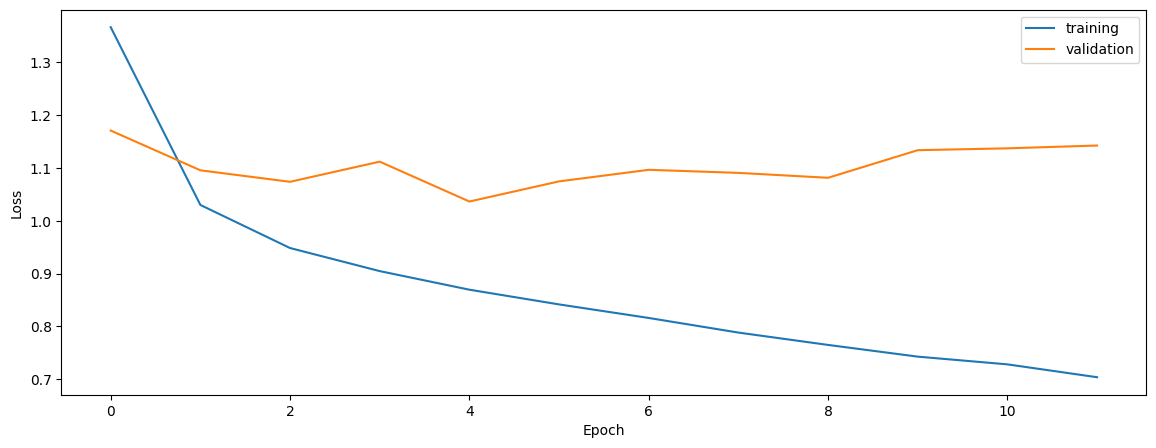

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6736184312264076
0.6147188291439105
0.6383754914581956


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.607358734504525
0.5993706970740104
0.5578072509925396


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.606612232242061
0.5902739575310815
0.5648095508811825


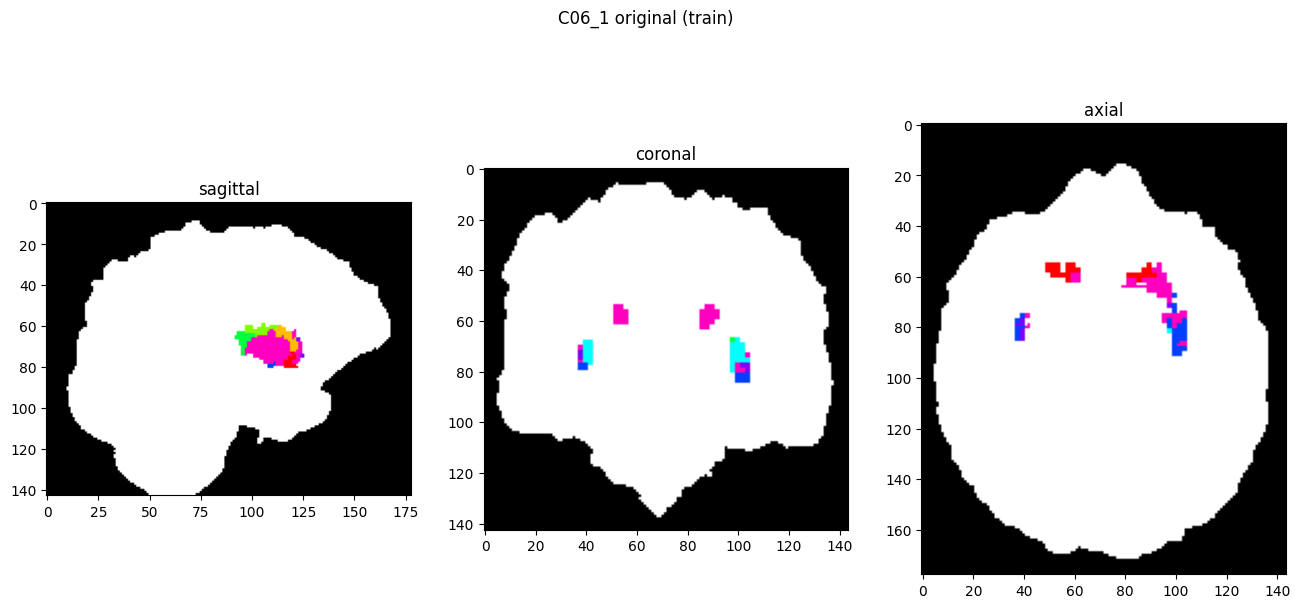

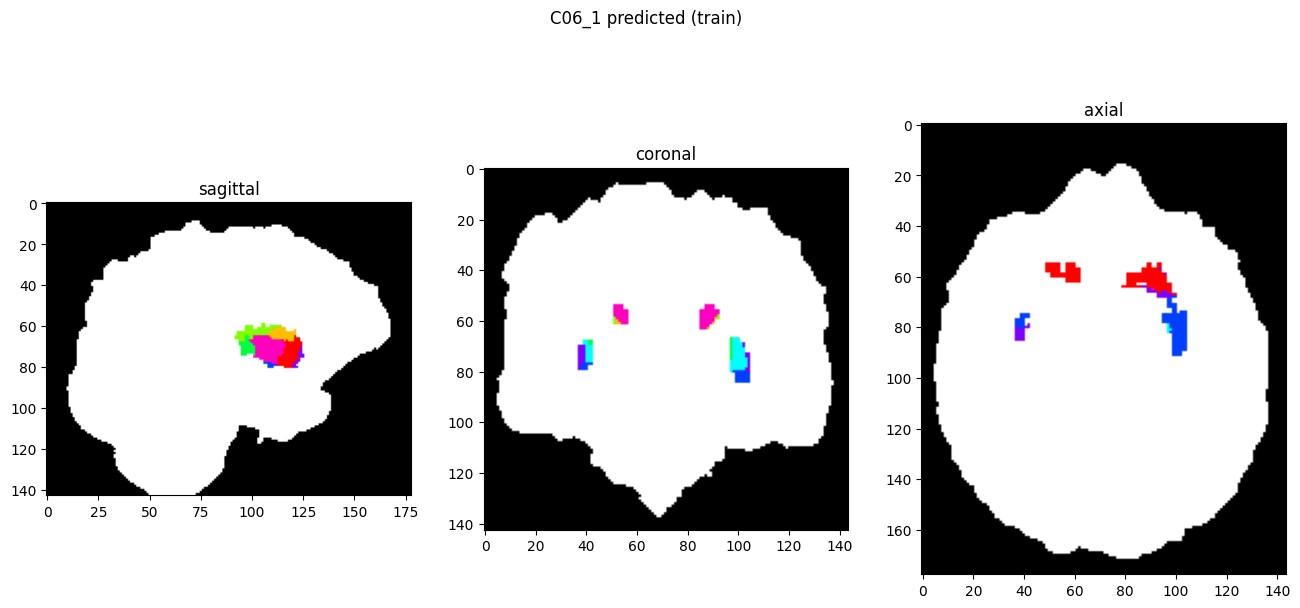

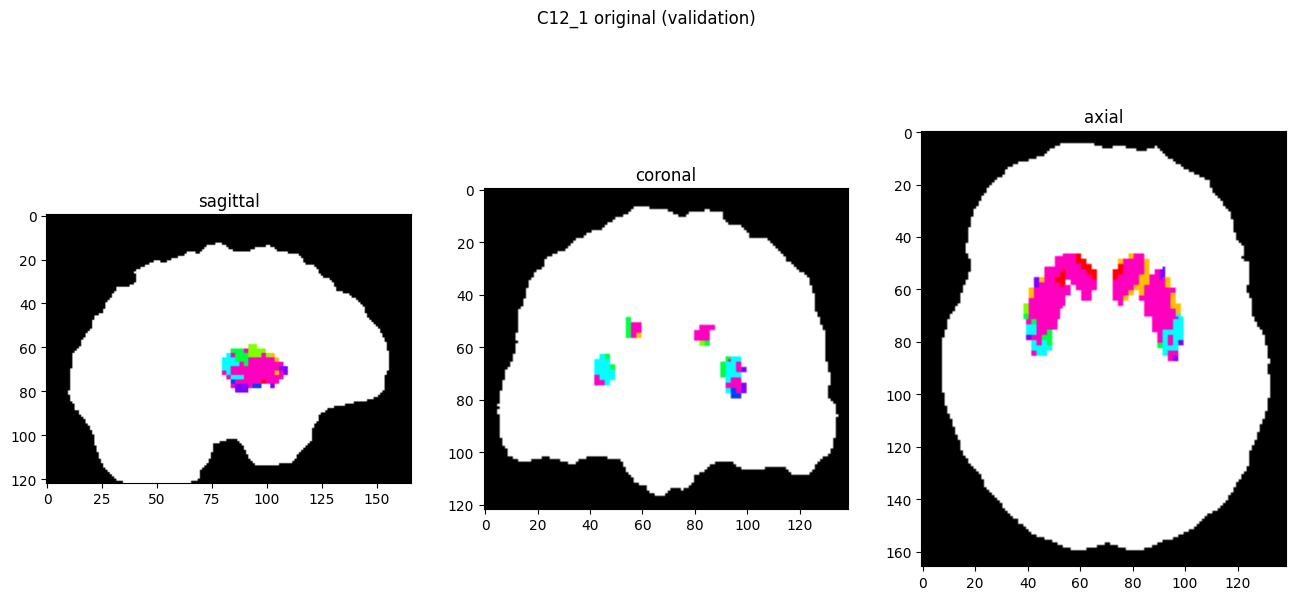

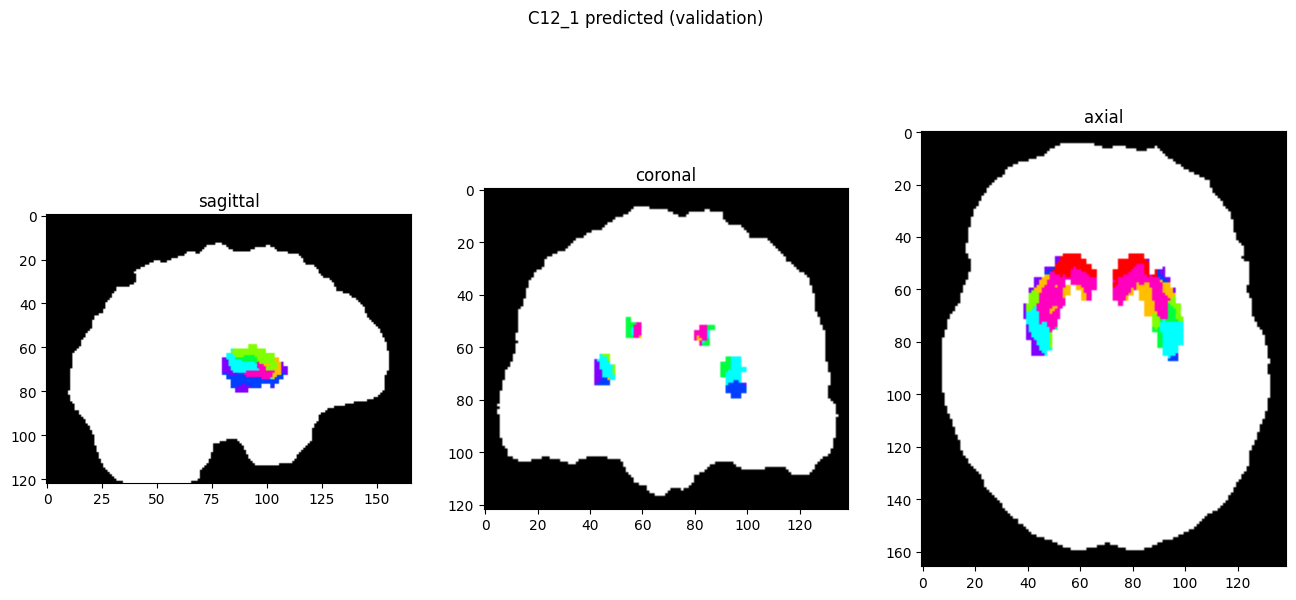

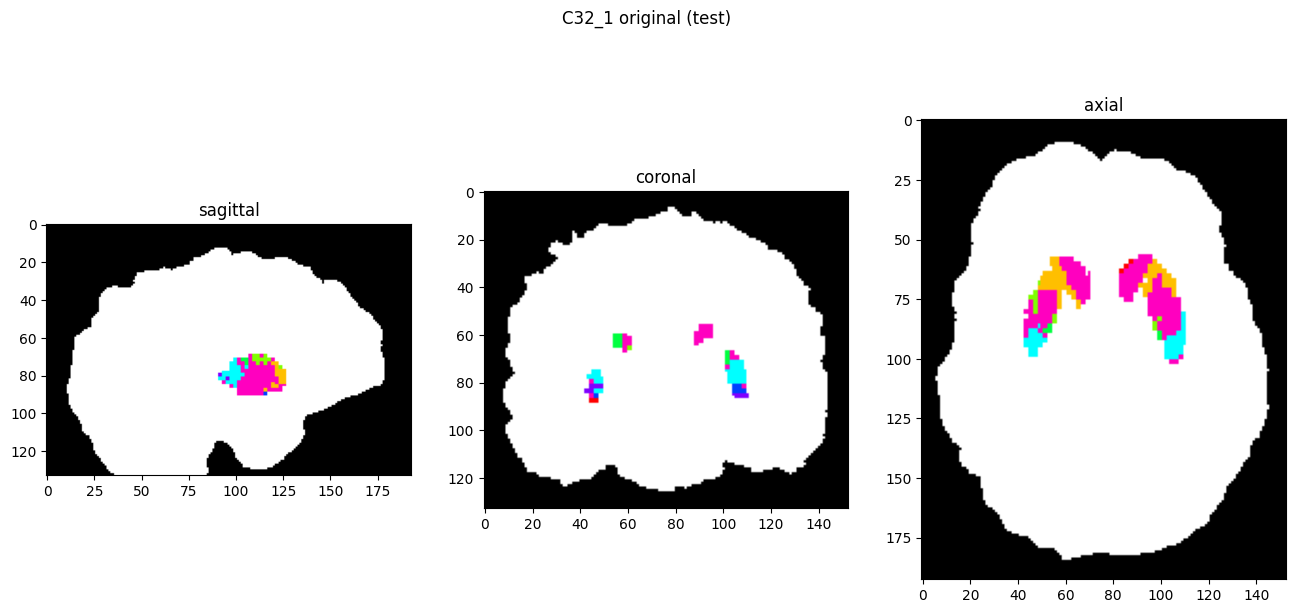

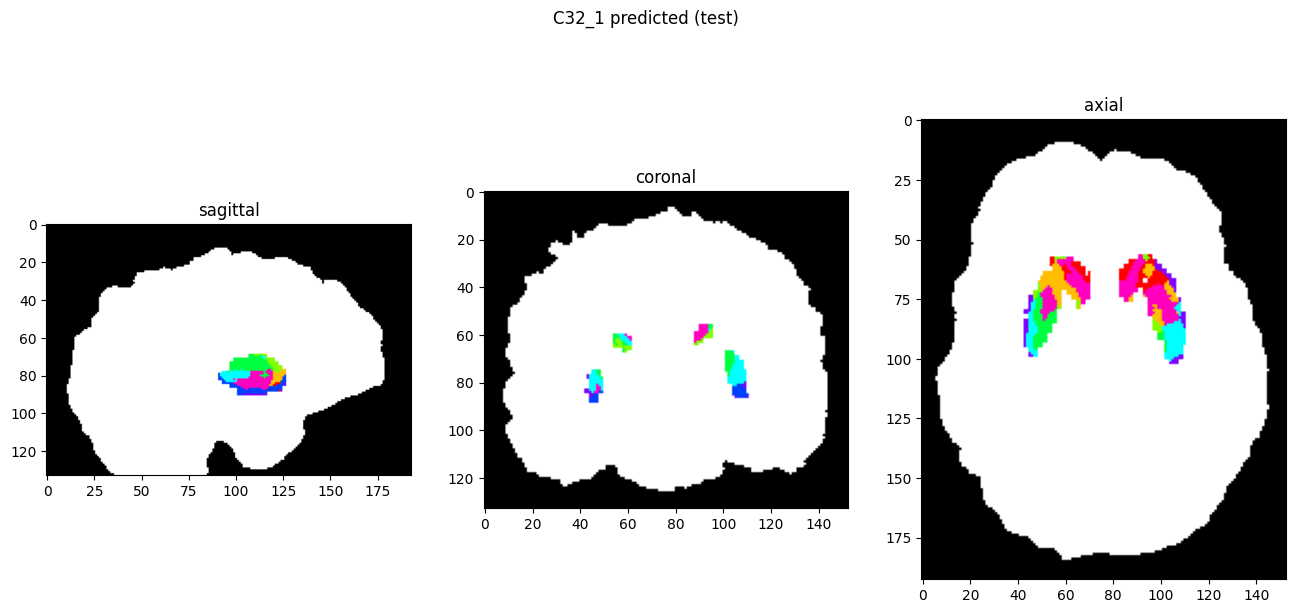

In [10]:
showResults(model, gen, threshold=0)